# Transitions NREM-REM

In [12]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [13]:
import matplotlib as mpl

# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams["svg.fonttype"] = "none"
# %matplotlib qt


# Utils Functions

In [14]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale("log")

In [15]:
def transition(states, template, epsilon=0):
    """
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any transition in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    """
    if epsilon is list:
        print("eplist")
    long = pd.DataFrame()
    for s, i in states.items():
        i["state"] = s
        long = pd.concat((i, long))
        del i["state"]
    order = np.argsort(long.start)
    long = long.iloc[order]

    transition_times = []
    transition_intervals = []
    for i, s in enumerate(long.state):
        tmp = list(long.state[i : i + len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i : i + len(template)]
            #             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start) / 1_000_000
            if np.any(length.values < epsilon):
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre, tmp_post], 0)

            transition_intervals.append(
                [tmp_transition.start.iloc[0], tmp_transition.end.iloc[-1]]
            )
            transition_times.append(tmp_times)

    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(
        start=transition_intervals[:, 0],
        end=transition_intervals[:, 1],
        force_no_fix=True,
    )
    return transition_intervals, transition_times



## Computing

In [16]:
def sanity_check(neurons, states, intervals, timing):
    #     plt.ioff()
    f = plt.figure(figsize=(12, 4), dpi=300)
    ax = plt.subplot(3, 1, 1)
    plt.suptitle(f"Rat : {bk.load.rat} Day : {bk.load.day} - {bk.load.session}")

    for k, s in states.items():
        if k == "Rem":
            c = "orange"
        elif k == "sws":
            c = "grey"
        elif k == "wake":
            c = "pink"
        elif k == "drowsy":
            c = "green"

        bk.plot.intervals(s, c)

    plt.subplot(3, 1, 2, sharex=ax)
    bk.plot.intervals(intervals)
    for i in timing.ravel():
        plt.axvline(i / 1_000_000)

    # plt.subplot(3, 1, 3, sharex=ax)
    # bk.plot.rasterPlot(neurons)
    plt.tight_layout()


#     plt.savefig(f'/home/billel/figs/{bk.load.session}.jpeg')
#     f.clear()
#     plt.close(f)
#     lfp = bk.load.loadLFP()
#     plt.subplot(4,1,4,sharex = ax)
#     plt.plot(lfp.as_units('s'))



In [17]:
def compute_transition_activity_not_normalized(neurons, timing, before, after):
    timing = timing / 1_000_000
    transition_activity = []
    spec = []
    for t in timing:  # For each transitions
        chan = bk.load.random_channel("BLA")
        start = t - before
        stop = t + after
        _, b = bk.compute.binSpikes(neurons, binSize=1, start=start, stop=stop)
        transition_activity.append(b)
        lfp = bk.load.lfp(chan, start, stop)

        f, t, Sxx = scipy.signal.spectrogram(
            lfp.values, 1250, nperseg=5000, noverlap=2500
        )
        spec.append(Sxx)
    plt.figure(figsize=[12, 4])
    plt.pcolormesh(t, f, np.log(np.mean(spec, 0)), shading="gouraud")
    plt.clim([8, 10])
    plt.ylim([0, 20])
    plt.xlim(0, 120)
    plt.title("BLA")

    #     print((np.array(spec).shape))
    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity, 0, 2)

    transition_spec = np.array(spec)
    transition_spec = np.moveaxis(transition_spec, 0, 2)

    return transition_activity, [f, t, transition_spec]


def main_non_normalized(
    local_path="Rat08/Rat08-20130713", arg=None, plot=True, save=False
):
    bk.load.current_session_linux(local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    transition_name = ["sws", "Rem"]

    print(f"Computing {transition_name} transitions")
    intervals, timing = transition(
        states, transition_name, epsilon=[90, 30]
    )  # Find the timing of the transitions
    print(f"Found {len(intervals)} transitions")

    (
        transition_activity,
        (f, t, transition_spec),
    ) = compute_transition_activity_not_normalized(neurons, timing, 90, 31)

    if plot:
        #         y_bla_pyr = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Pyr')],2).T,0),1)
        #         y_bla_int = np.mean(scipy.stats.zscore(np.mean(transition_activity[(metadata.Region == "BLA") & (metadata.Type == 'Int')],2).T,0),1)
        bla_std = scipy.stats.sem(
            np.mean(
                transition_activity[
                    (metadata.Region == "BLA") & (metadata.Type == "Pyr")
                ],
                2,
            ).T,
            1,
        )
        y_bla_pyr = np.mean(
            np.mean(
                transition_activity[
                    (metadata.Region == "BLA") & (metadata.Type == "Pyr")
                ],
                2,
            ).T,
            1,
        )
        #         y_hpc = np.mean(scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0),1)

        plt.figure(figsize=[12, 4])
        #         plt.plot(y_bla_int,'k--')
        plt.plot(y_bla_pyr, "green")
        plt.plot(y_bla_pyr + bla_std, "g--", y_bla_pyr - bla_std, "g--")
        plt.xlim(0, 120)
        plt.axvspan(89, 119, color="orange", alpha=0.5)
        #         plt.plot(y_hpc,'blue')

        plt.title(f"Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}")
        plt.show()

    return transition_activity, (f, t, transition_spec), metadata



In [29]:
def compute_transition_activity(neurons, intervals, timing, bin_epochs, n_event):

    transition_activity = []
    for event, t in zip(intervals.iloc, timing):  # For each transitions
        if n_event == 2:
            epochs = np.array([(event.start, t[0]), (t[0], event.end)], dtype=np.int64)
        if n_event == 3:
            epochs = np.array([[event.start, t[0]], [t[0], t[1]], [t[1], event.end]])
        epochs = nts.IntervalSet(start=epochs[:, 0], end=epochs[:, 1])
        # Creates intervals for each state of the transitions events.

        #         binned = np.array(shape = (252,np.sum(bin_epochs)))
        #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
        binned = np.empty(shape=(len(neurons), 1))
        for i, epoch in enumerate(epochs.as_units("s").iloc):
            start = epoch.start
            end = epoch.end
            nbins = bin_epochs[i]
            _, b = bk.compute.binSpikes(neurons, start=start, stop=end, nbins=nbins)
            b = b / ((end - start) / nbins)  # Converting to firing rates
            binned = np.hstack((binned, b))
        binned = binned[:, 1:]
        transition_activity.append(binned)

    transition_activity = np.array(transition_activity)
    transition_activity = np.moveaxis(transition_activity, 0, 2)

    return transition_activity


def main(local_path="Rat08/Rat08-20130713", arg=None, plot=False, save=False):
    # Variables :
    if arg == None:
        transition_interest = [
            ["Rem", "sws", "Rem"]
        ]  # Template of transitions to follow.
        bin_epochs = [12, 30, 12]
        n_event = 3
    else:
        transition_interest = [arg[0]]
        bin_epochs = arg[1]
        n_event = arg[2]

    bk.load.current_session_linux(base_folder = '/media/billel/GGLab-01-BK/DATA/GG-Dataset/',local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    for i, transition_name in enumerate(
        transition_interest
    ):  # For each kind of transitions
        print(f"Computing {transition_name} transitions")
        intervals, timing = transition(
            states, transition_name, epsilon=50
        )  # Find the timing of the transitions
        print(f"Found {len(intervals)} transitions")

        transition_activity = compute_transition_activity(
            neurons, intervals, timing, bin_epochs, n_event
        )

        if plot:
            print(np.mean(transition_activity[metadata.Region == "BLA"], 2).T.shape)
            y_bla = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "BLA"], 2).T, 0
            )
            y_hpc = scipy.stats.zscore(
                np.mean(transition_activity[metadata.Region == "Hpc"], 2).T, 0
            )

            plt.figure()
            plt.plot(y_bla, "green")
            plt.plot(y_hpc, "blue")

            plt.title(f"Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}")
        print(os.getcwd())
        # sanity_check(neurons,states,intervals,timing)
        return np.array(transition_activity), metadata



In [19]:
def NREM_Control(local_path="Rat08/Rat08-20130713", args=None, plot=False, save=False):

    NREM_length = 250
    REM_length = 80 * 1_000_000
    bin_epochs = [30, 12, 30]
    n_events = len(bin_epochs)

    bk.load.current_session_linux(base_folder = "/media/billel/GGLab-01-BK/DATA/GG-Dataset", local_path=local_path)
    neurons, metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()

    intervals, _ = transition(states, ["sws"], NREM_length)
    m = (intervals.start + intervals.end) / 2
    timing = np.array([m - (REM_length / 2), m + (REM_length / 2)]).T
    print(f"Found {len(intervals)} transitions")

    transition_activity = compute_transition_activity(
        neurons, intervals, timing, bin_epochs,n_events
    )
    
    sanity_check(neurons,states,intervals,timing)

    return np.array(transition_activity), metadata


In [8]:
arg = [["sws", "Rem"], [30, 12], 2]
NREM_REM = bk.load.batch(main, arg, verbose=False, linux=True)

100%|██████████| 61/61 [01:38<00:00,  1.61s/it]

Batch finished in 98.03957915306091
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722']
3.278688524590164 %


In [9]:
arg = [["sws", "Rem", "sws"], [30, 12, 30], 3]
NREM_REM_NREM = bk.load.batch(main, arg, verbose=False, linux=True)
arg = [["Rem", "sws", "Rem"], [12, 30, 12], 3]
REM_NREM_REM = bk.load.batch(main, arg, verbose=False, linux=True)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713


  0%|          | 0/61 [00:00<?, ?it/s]

Loading Data from Rat08-20130708
Rat : 8 on day : 1
Working with session Rat08-20130708 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130708
Data already saved in Numpy format, loading them from here:
Rat08-20130708-neurons.npy


100%|██████████| 61/61 [01:51<00:00,  1.83s/it]


Batch finished in 111.59204888343811
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


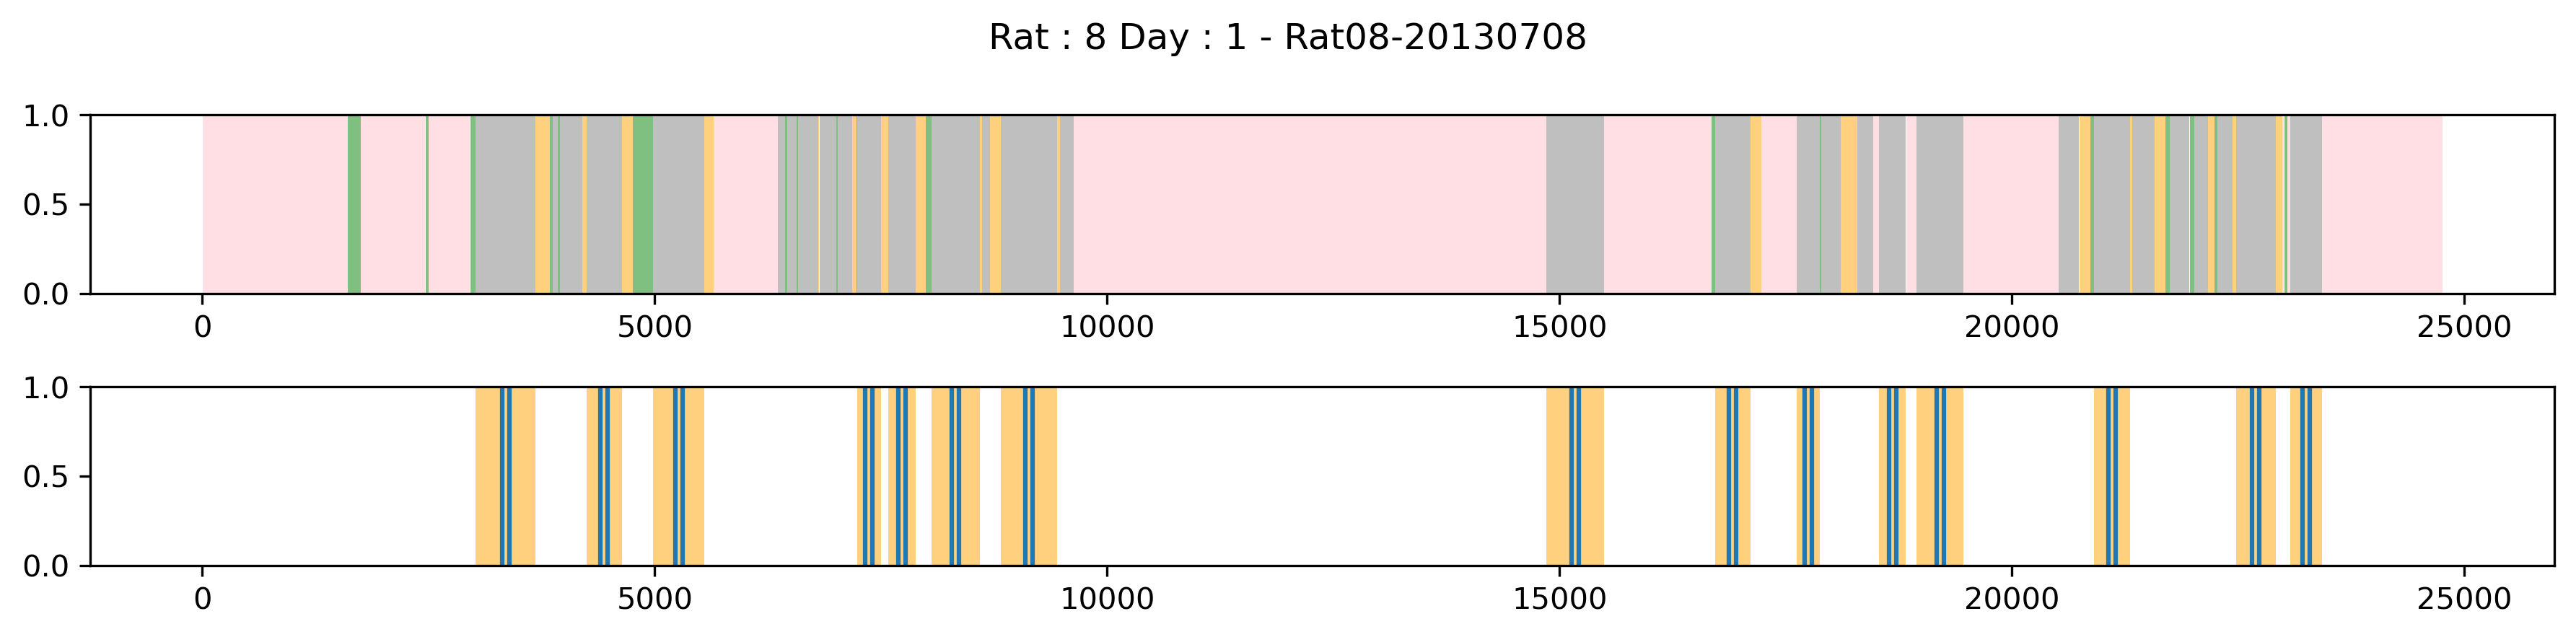

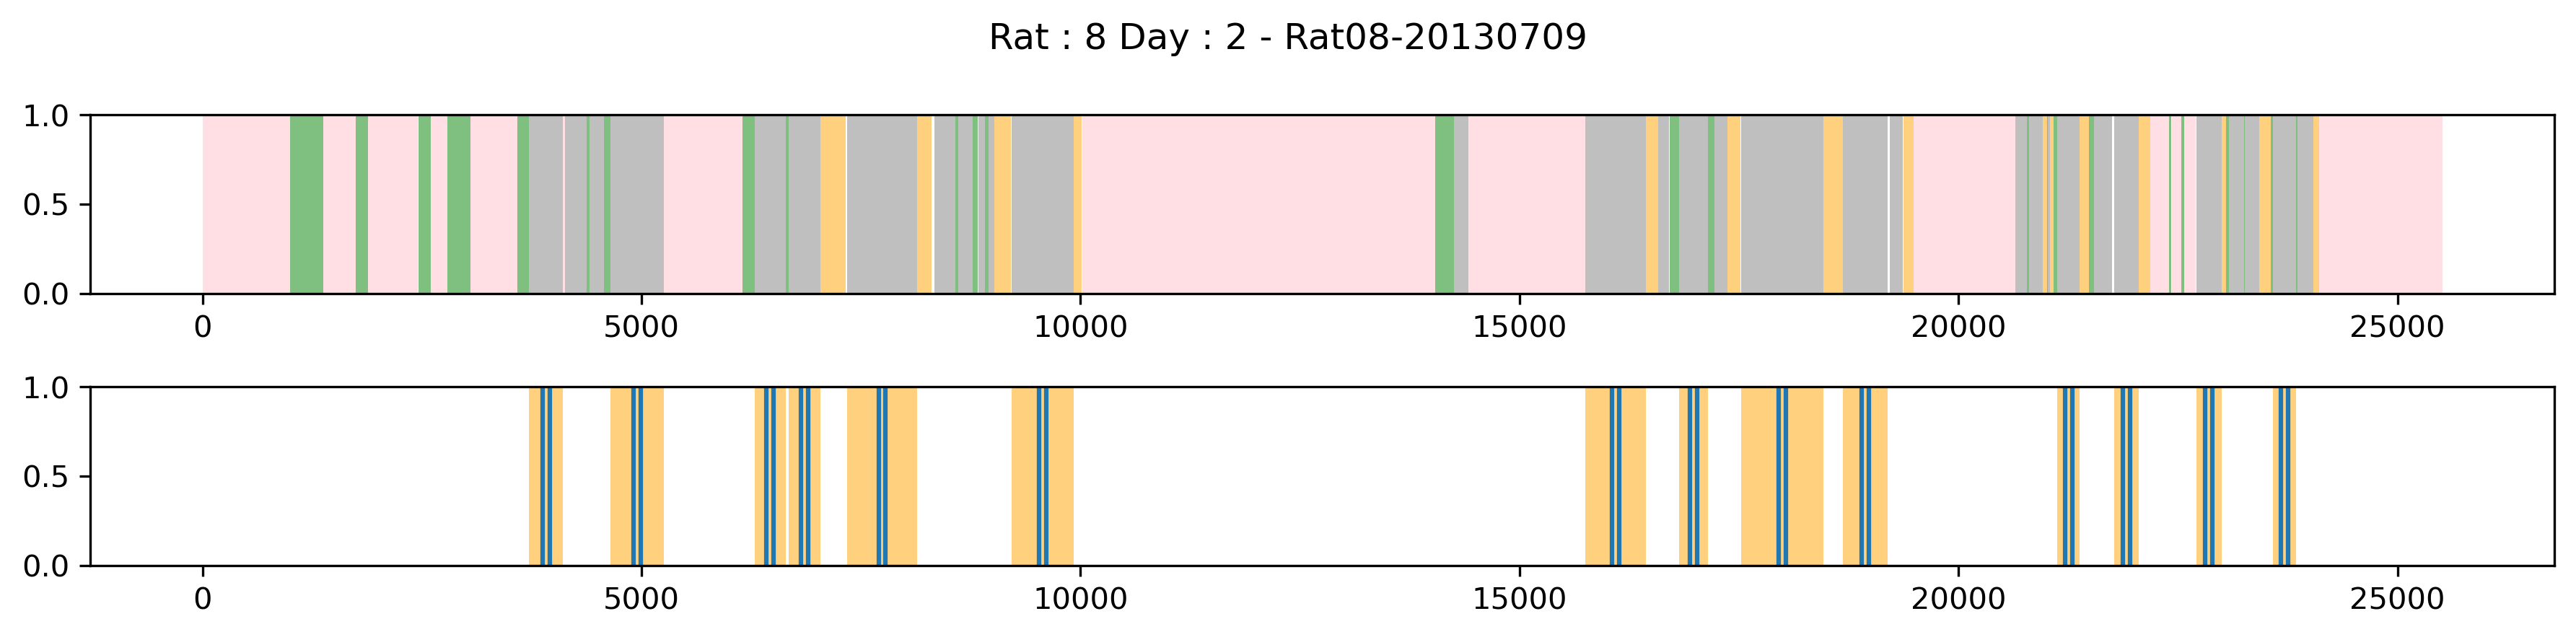

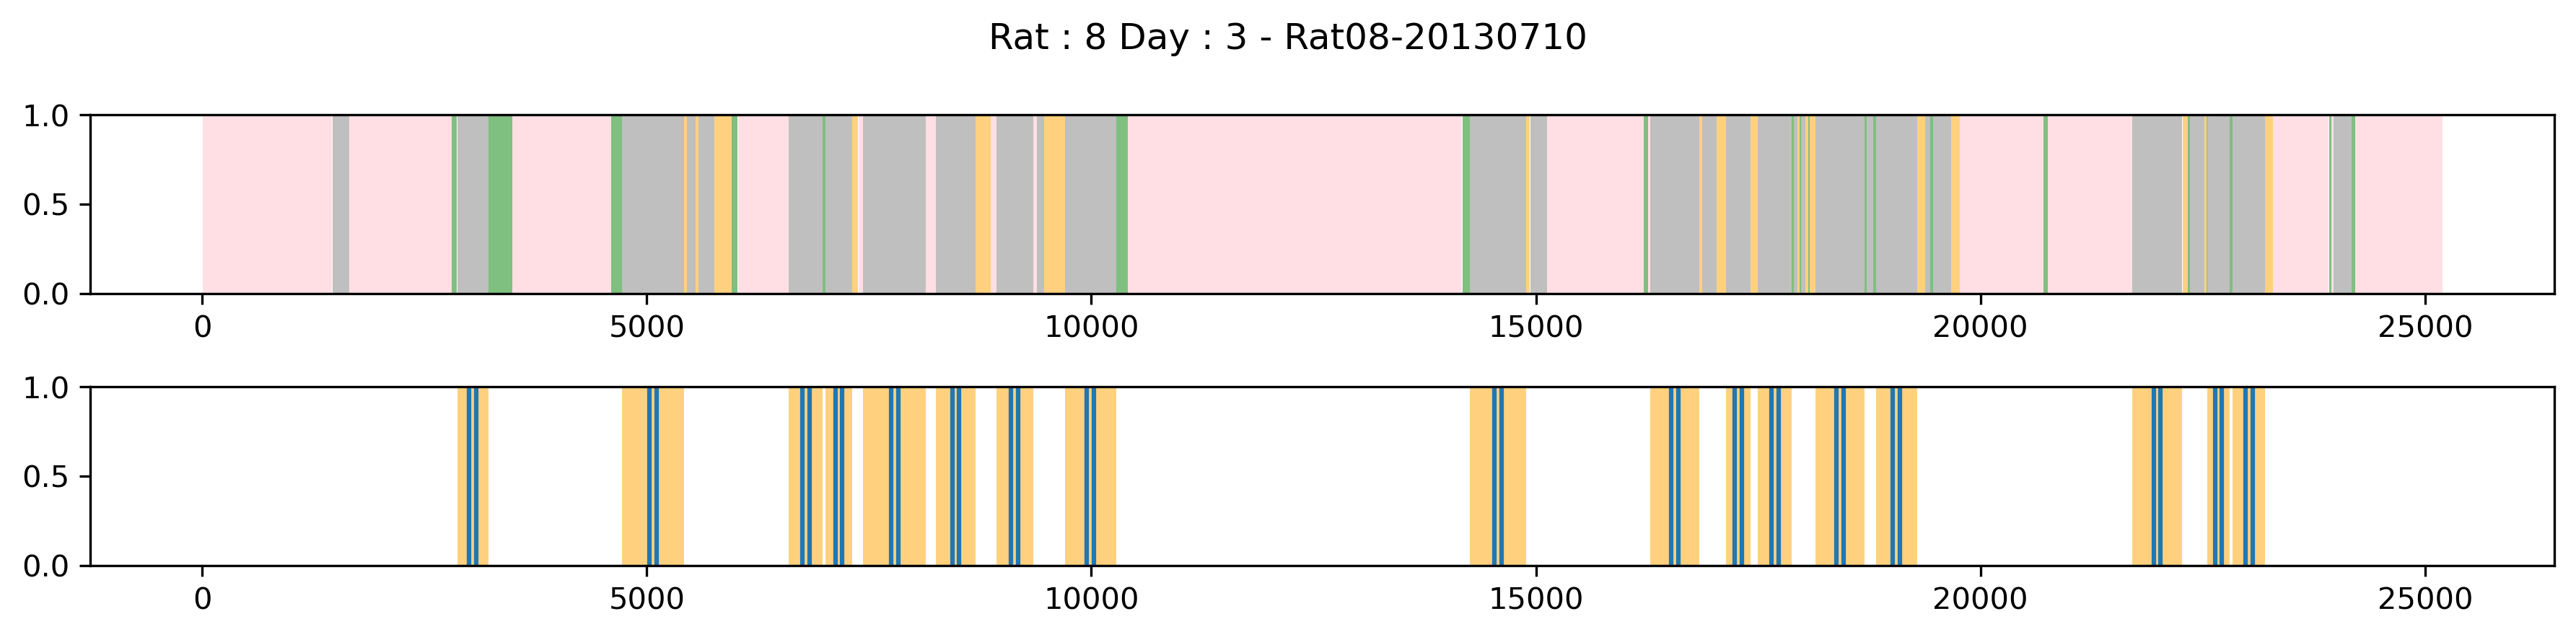

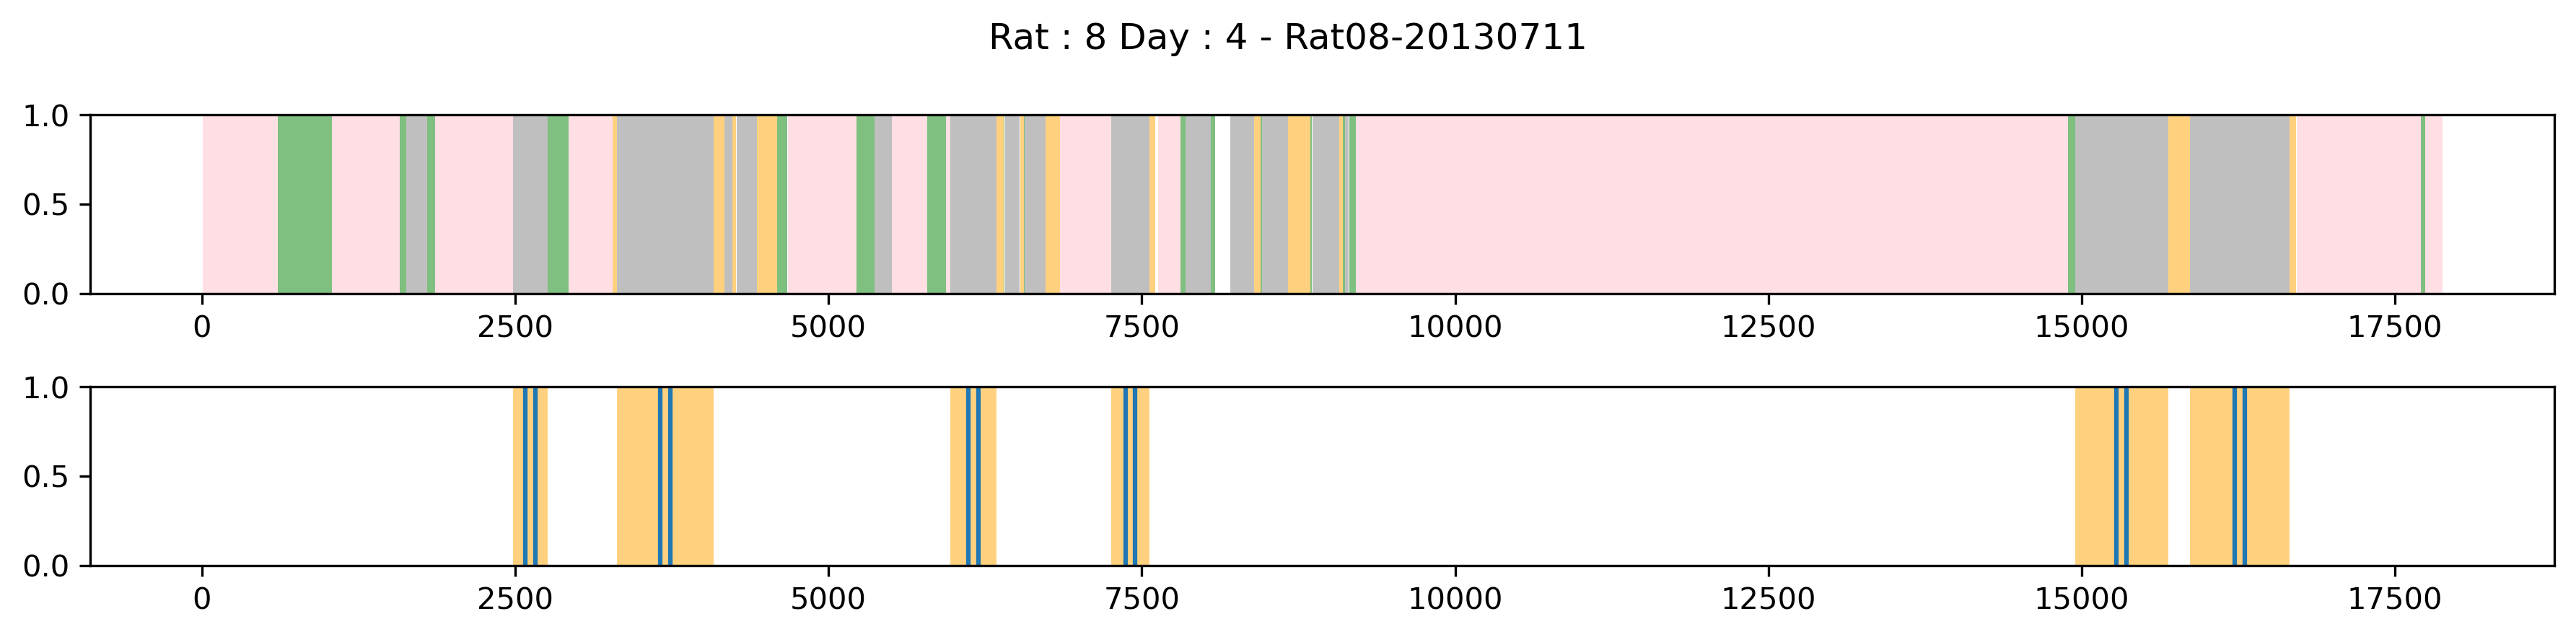

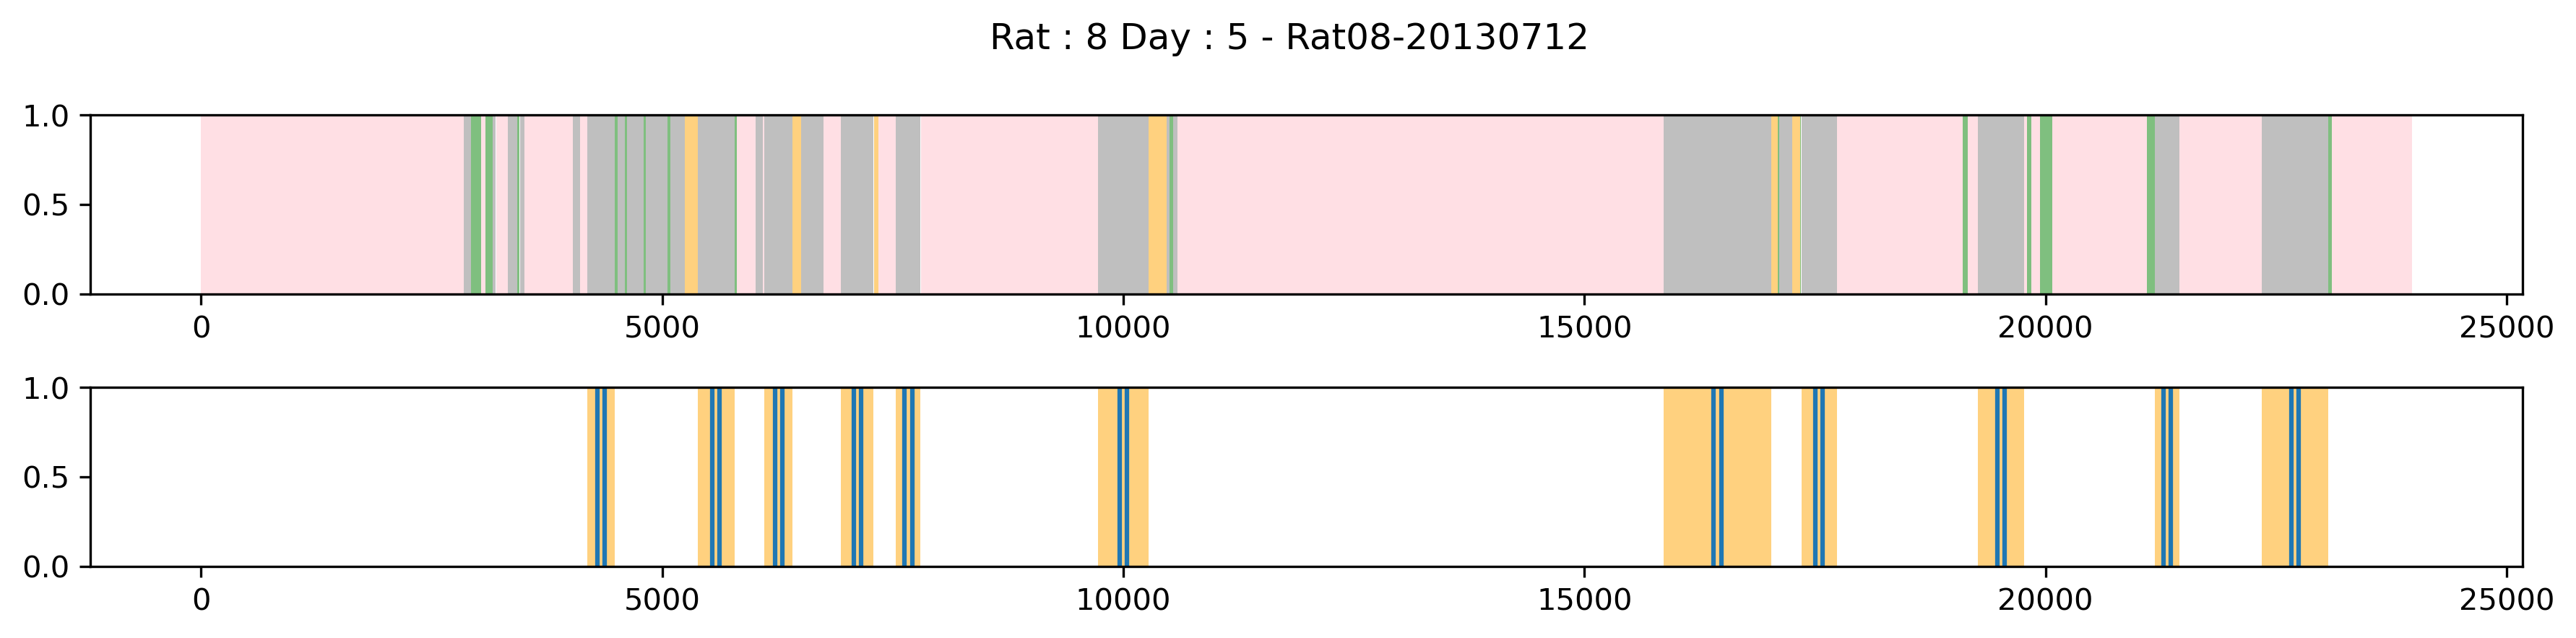

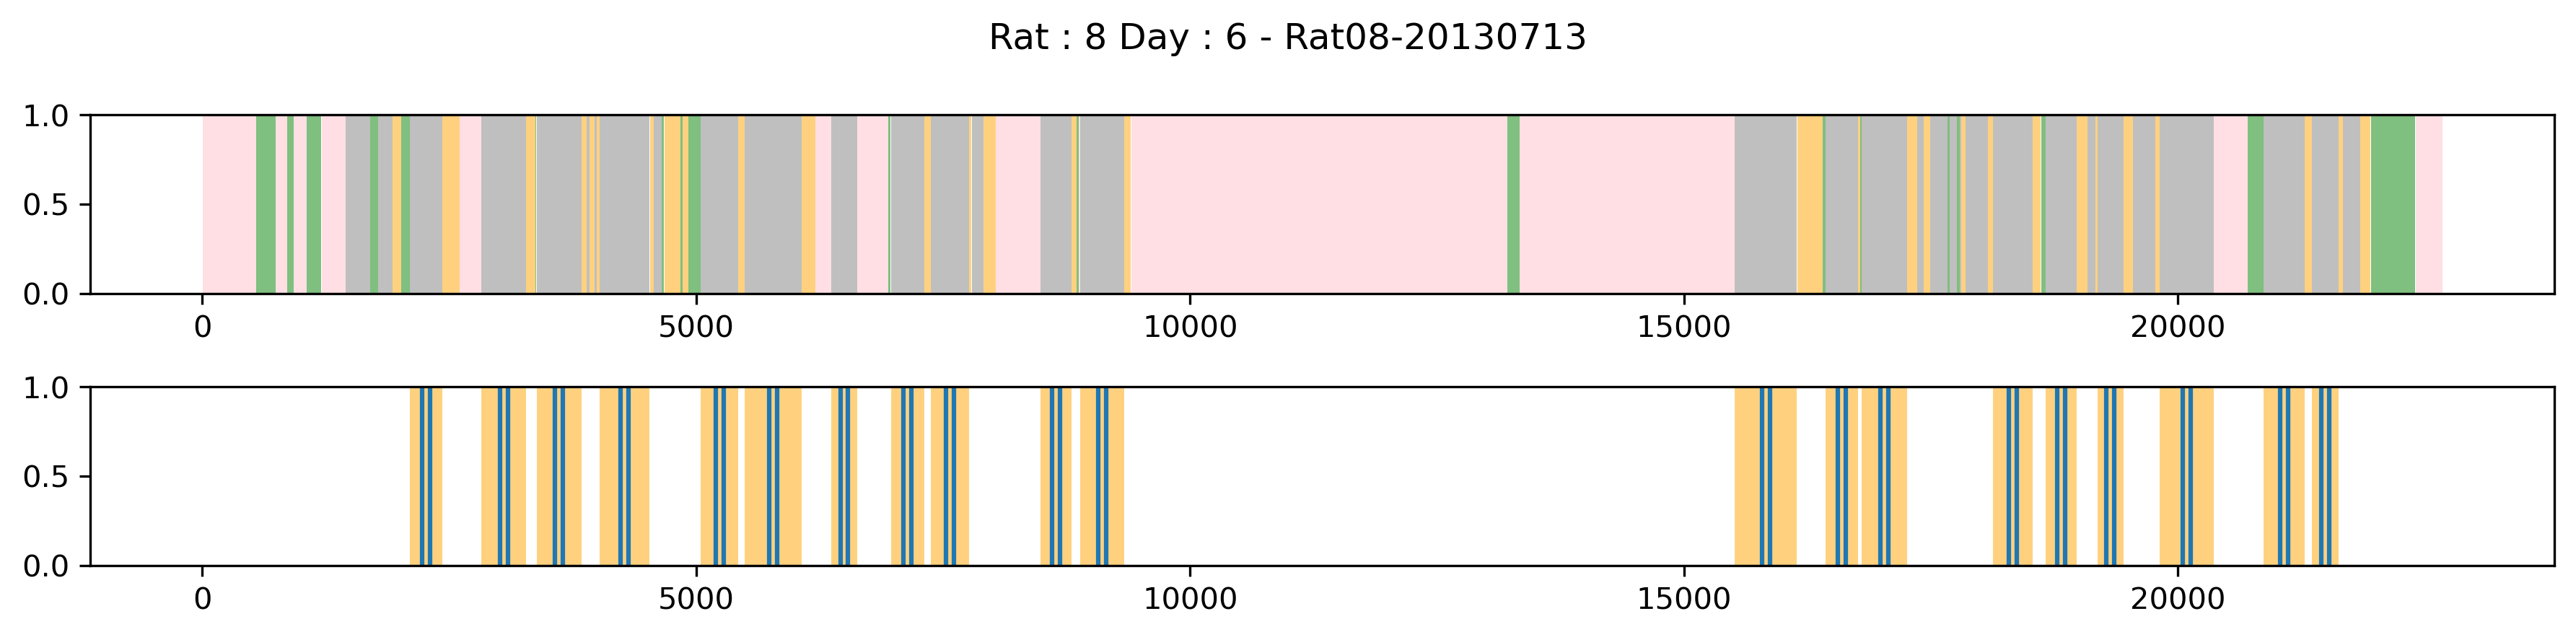

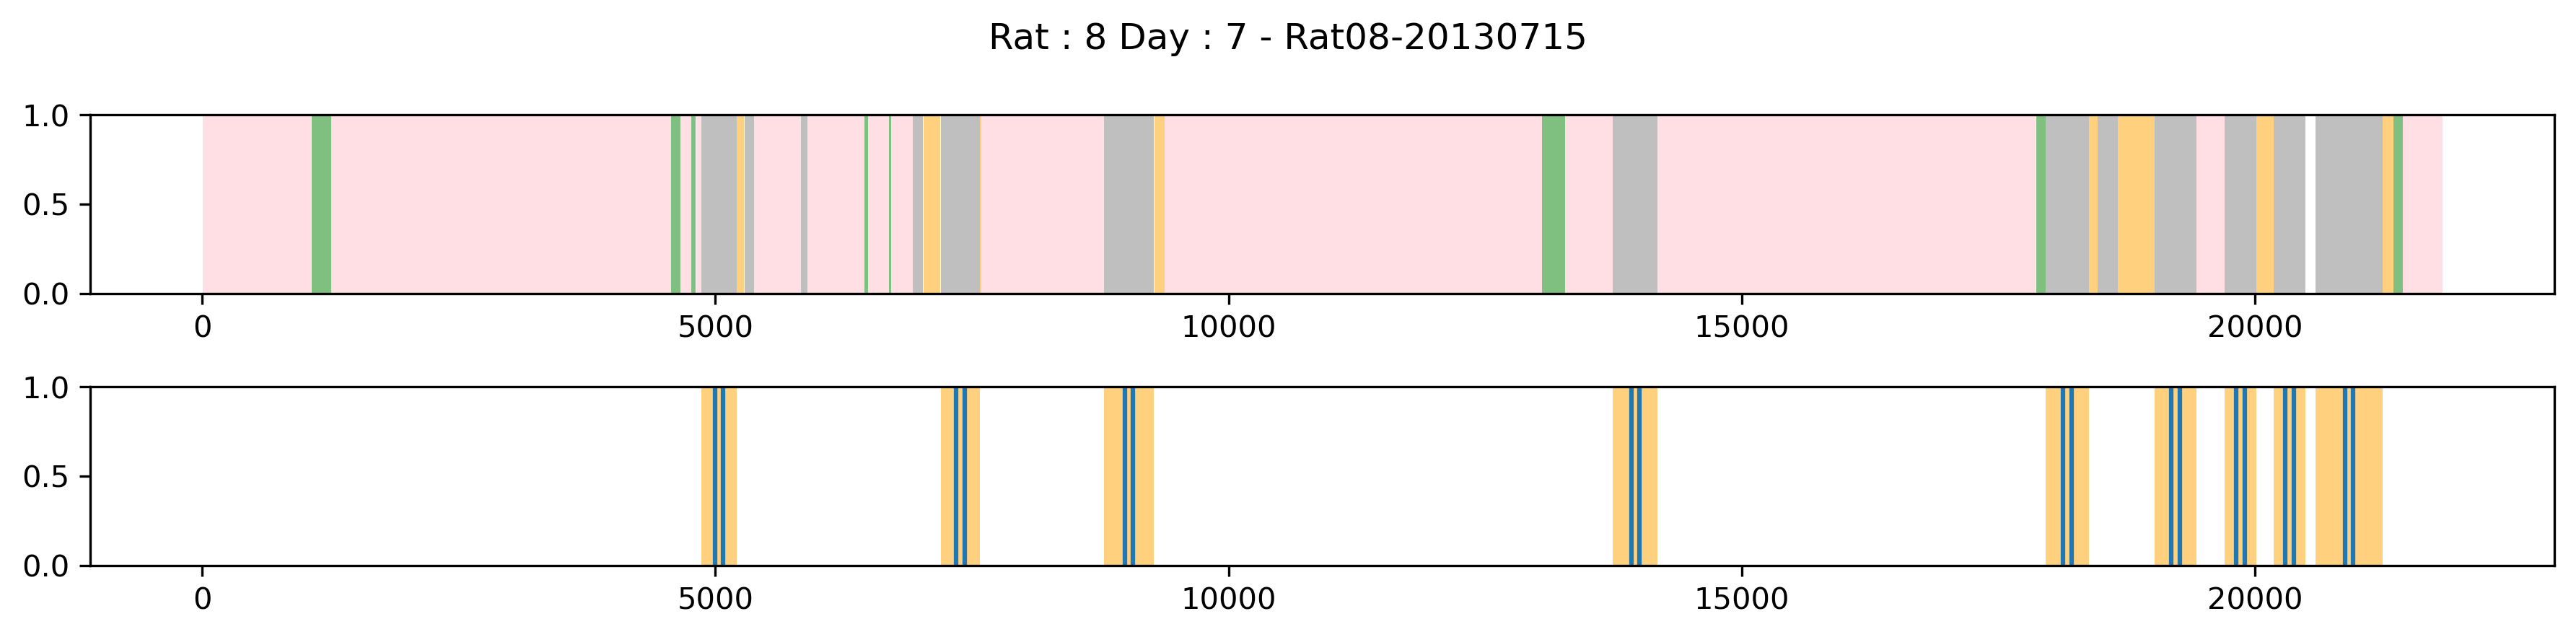

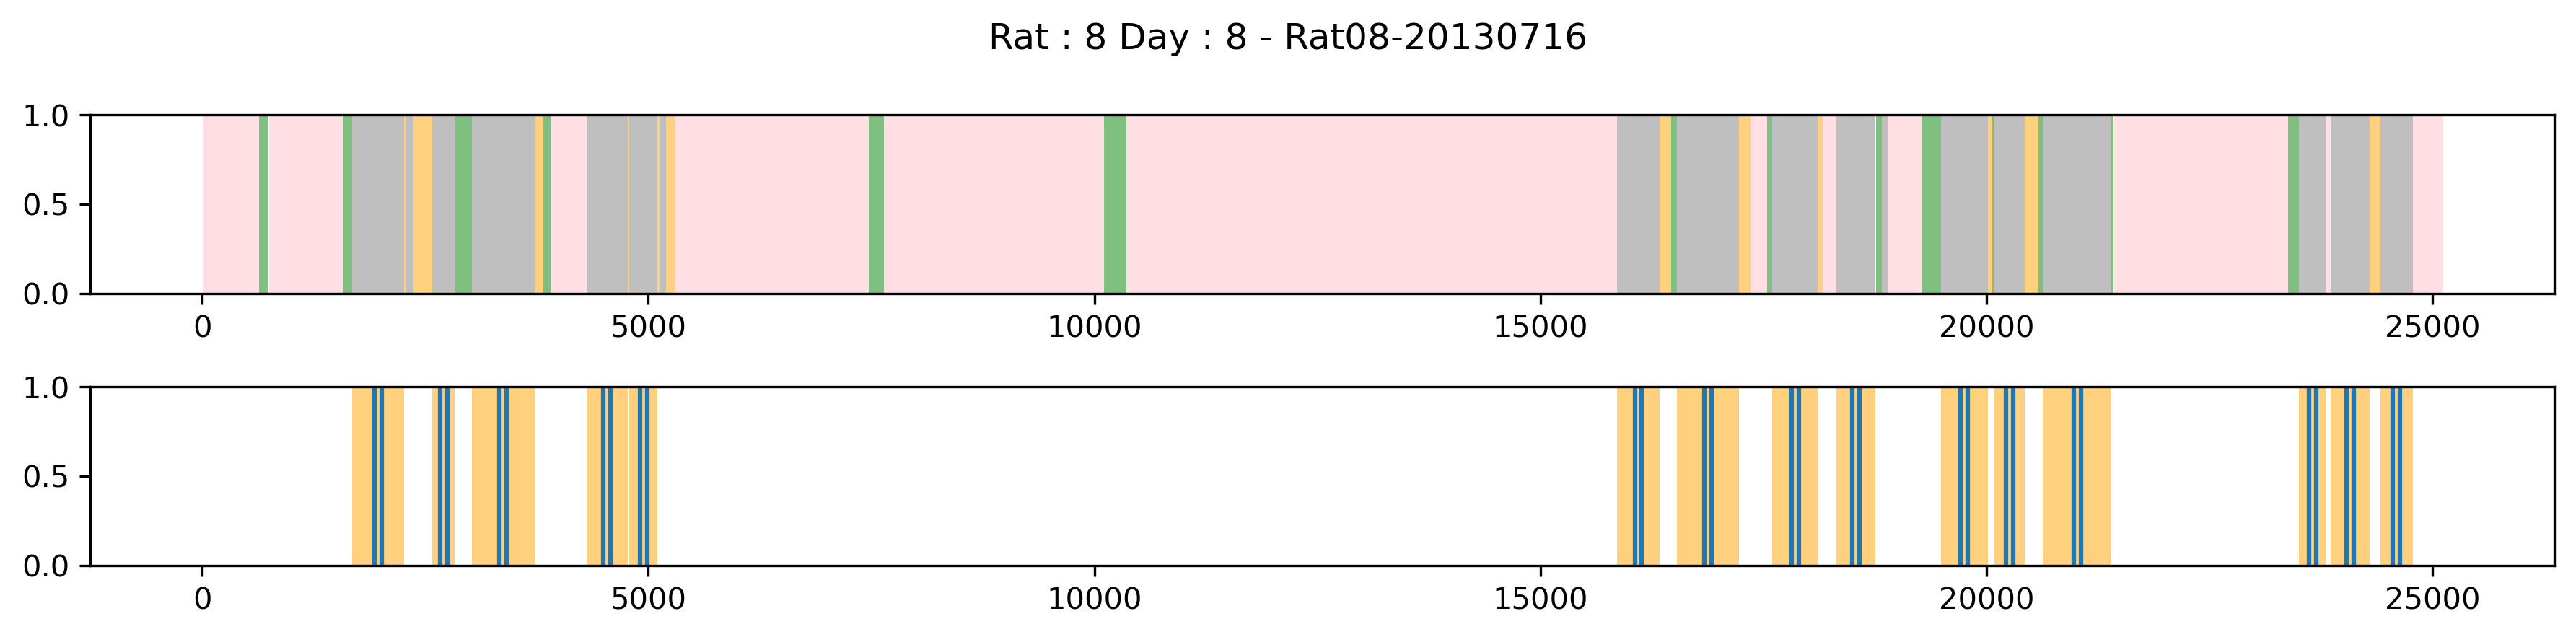

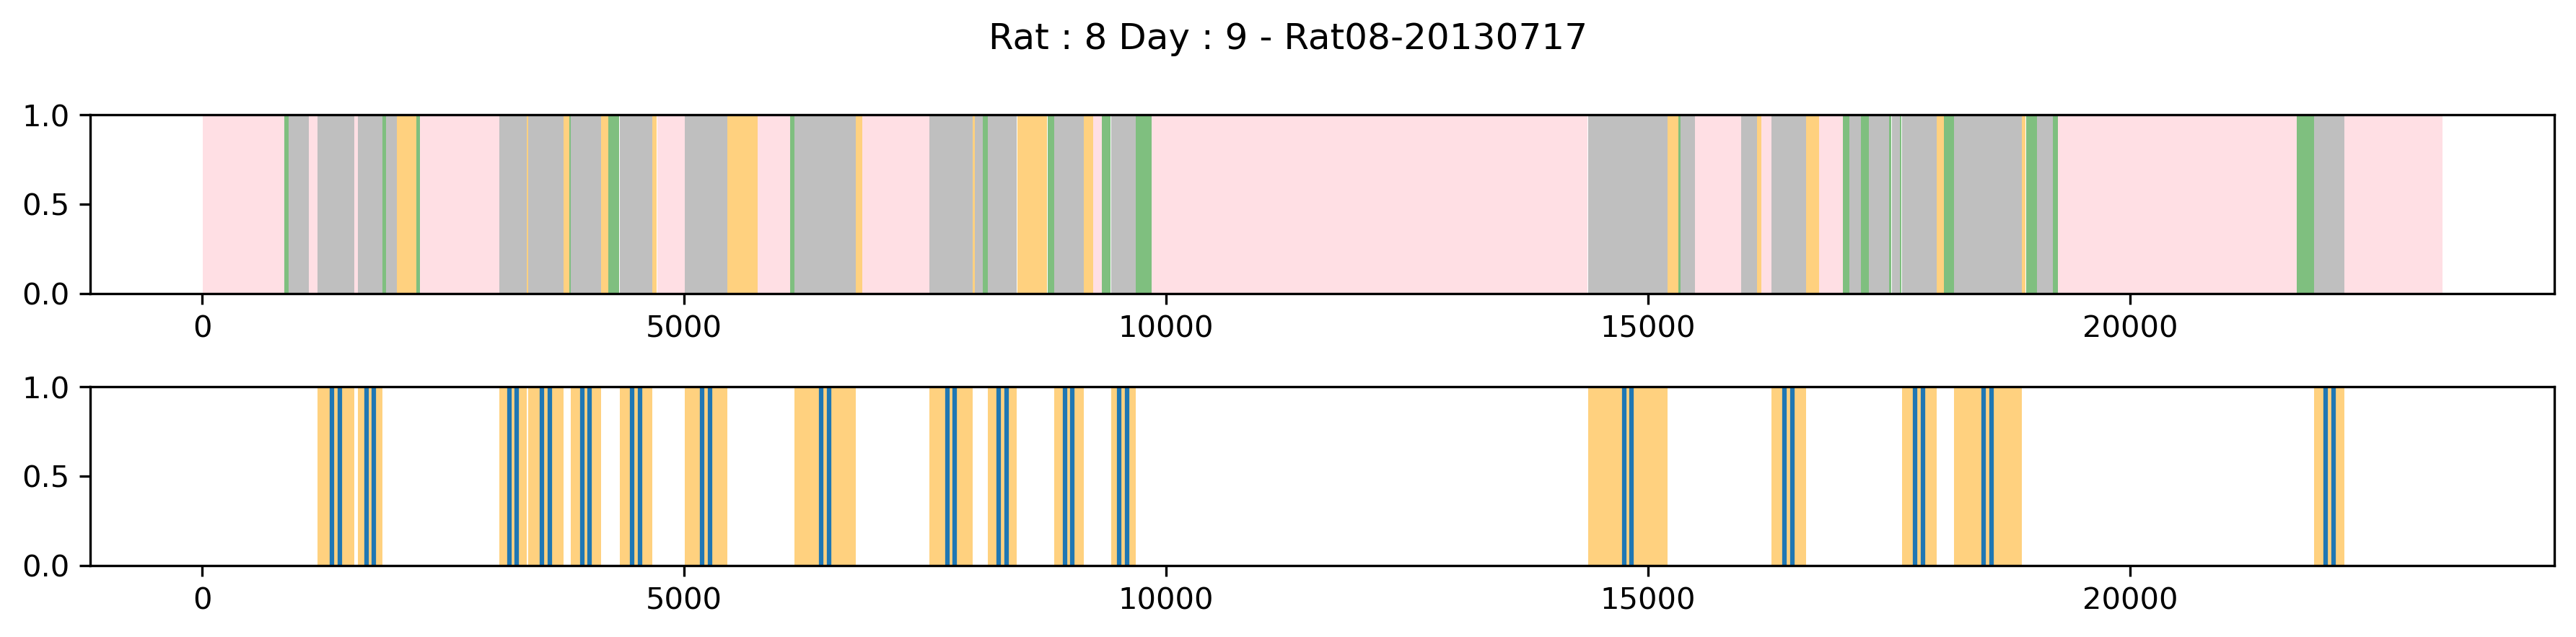

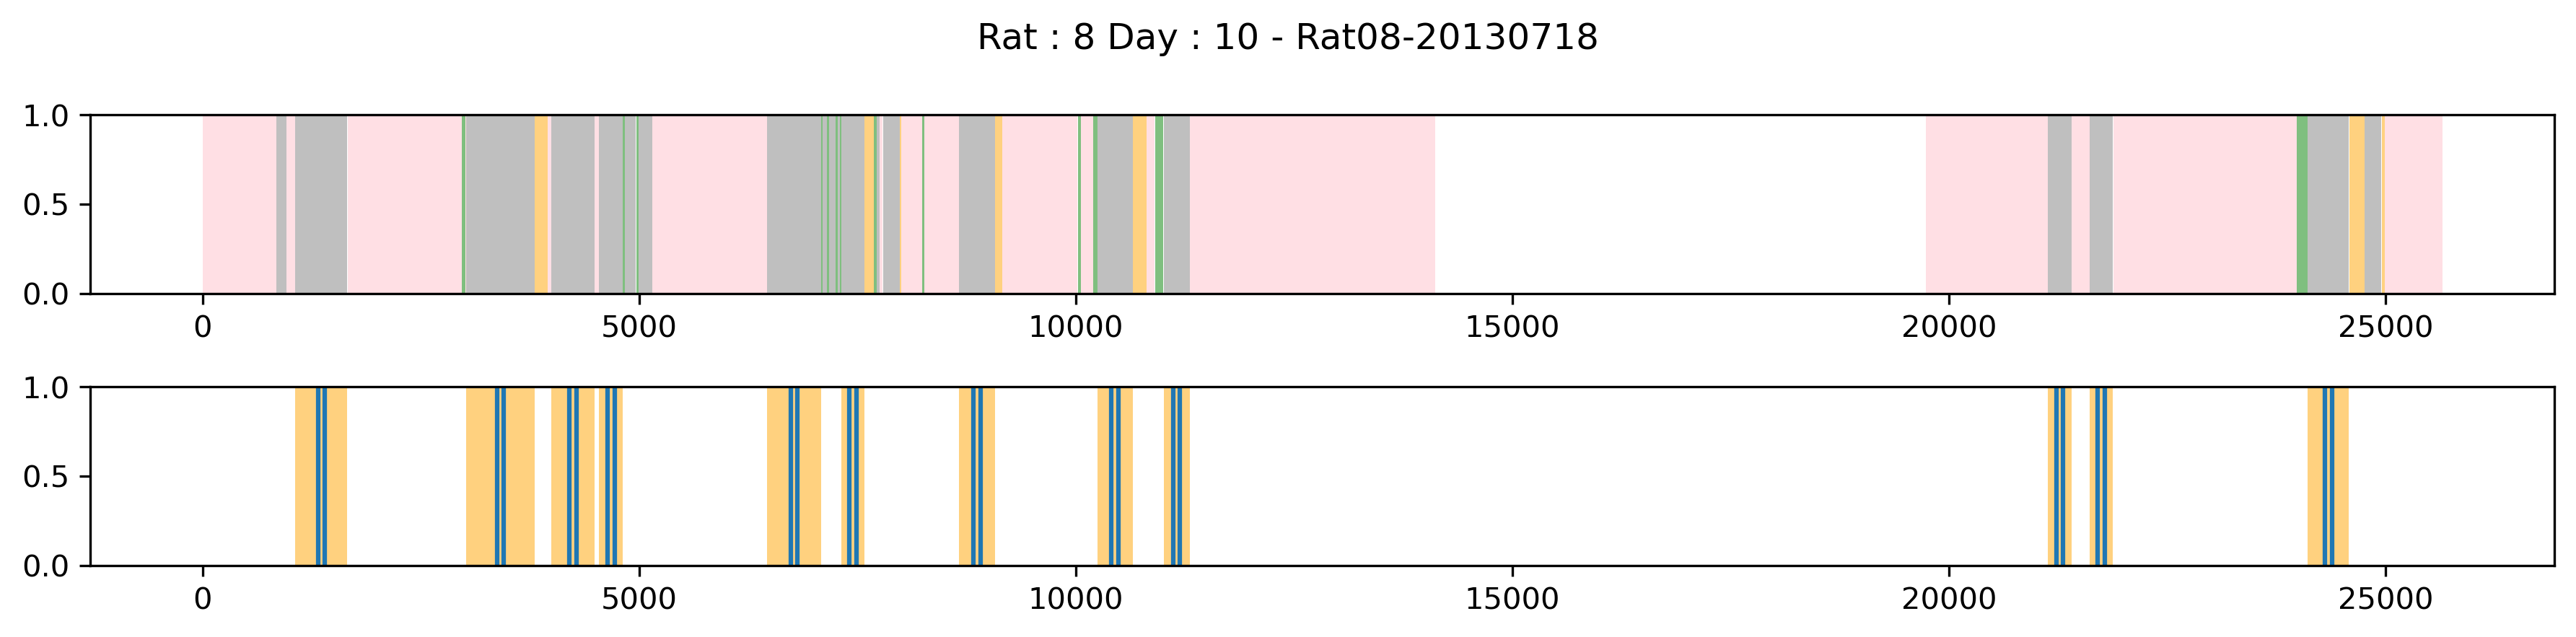

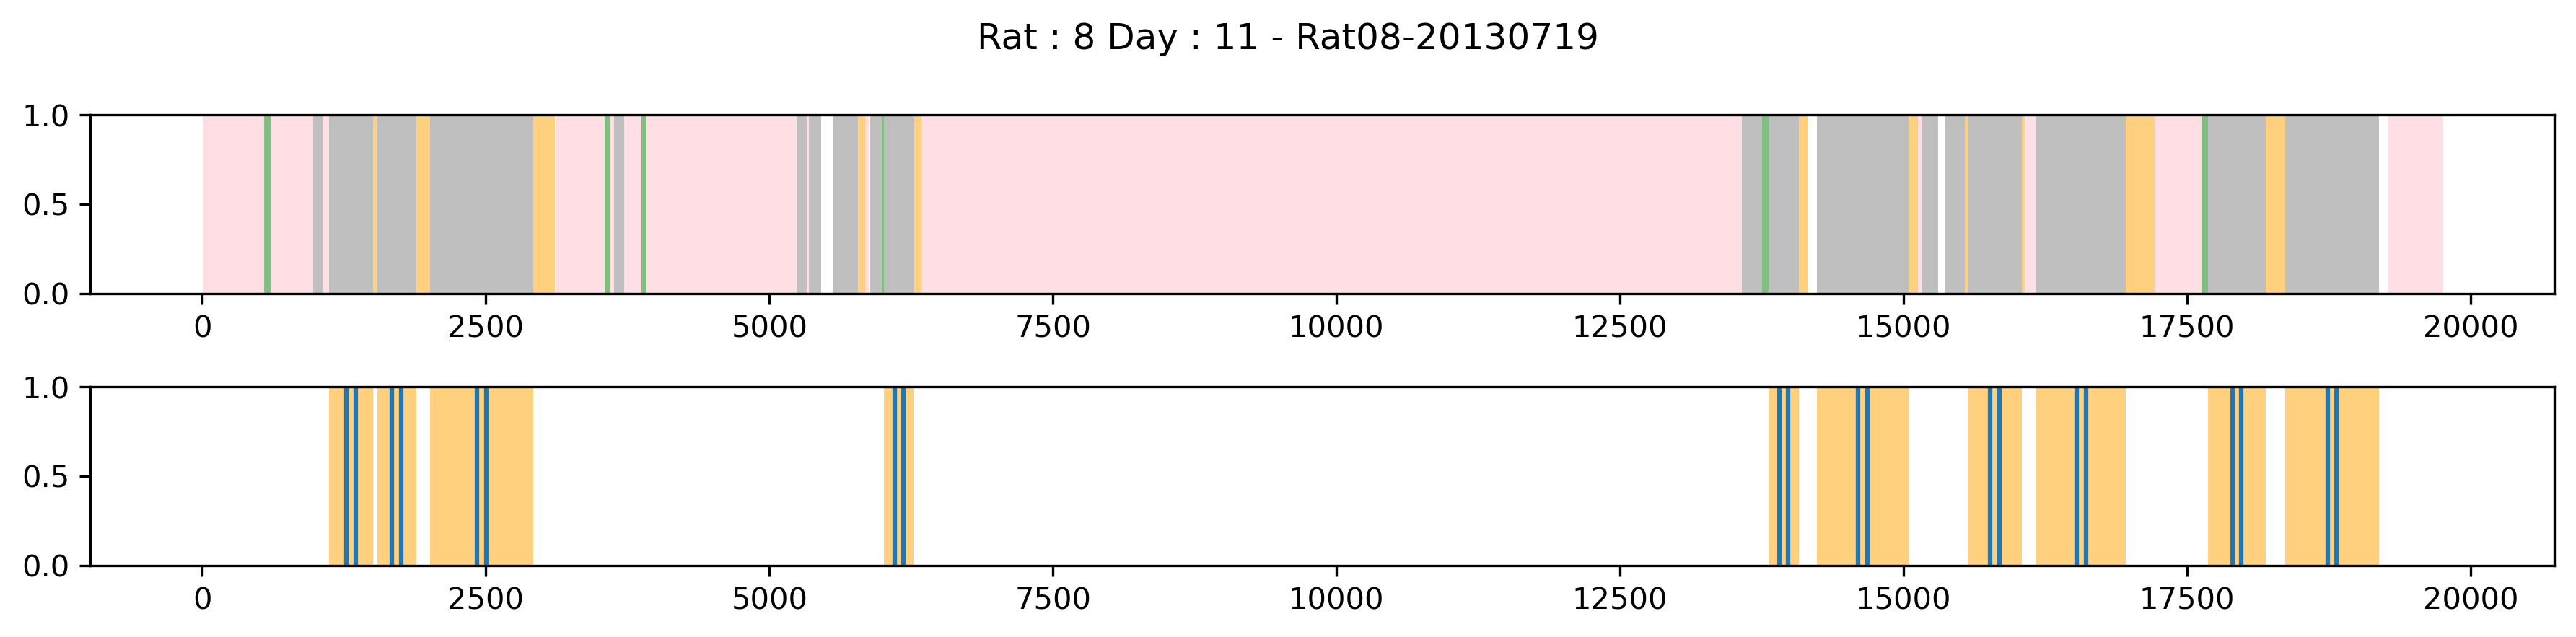

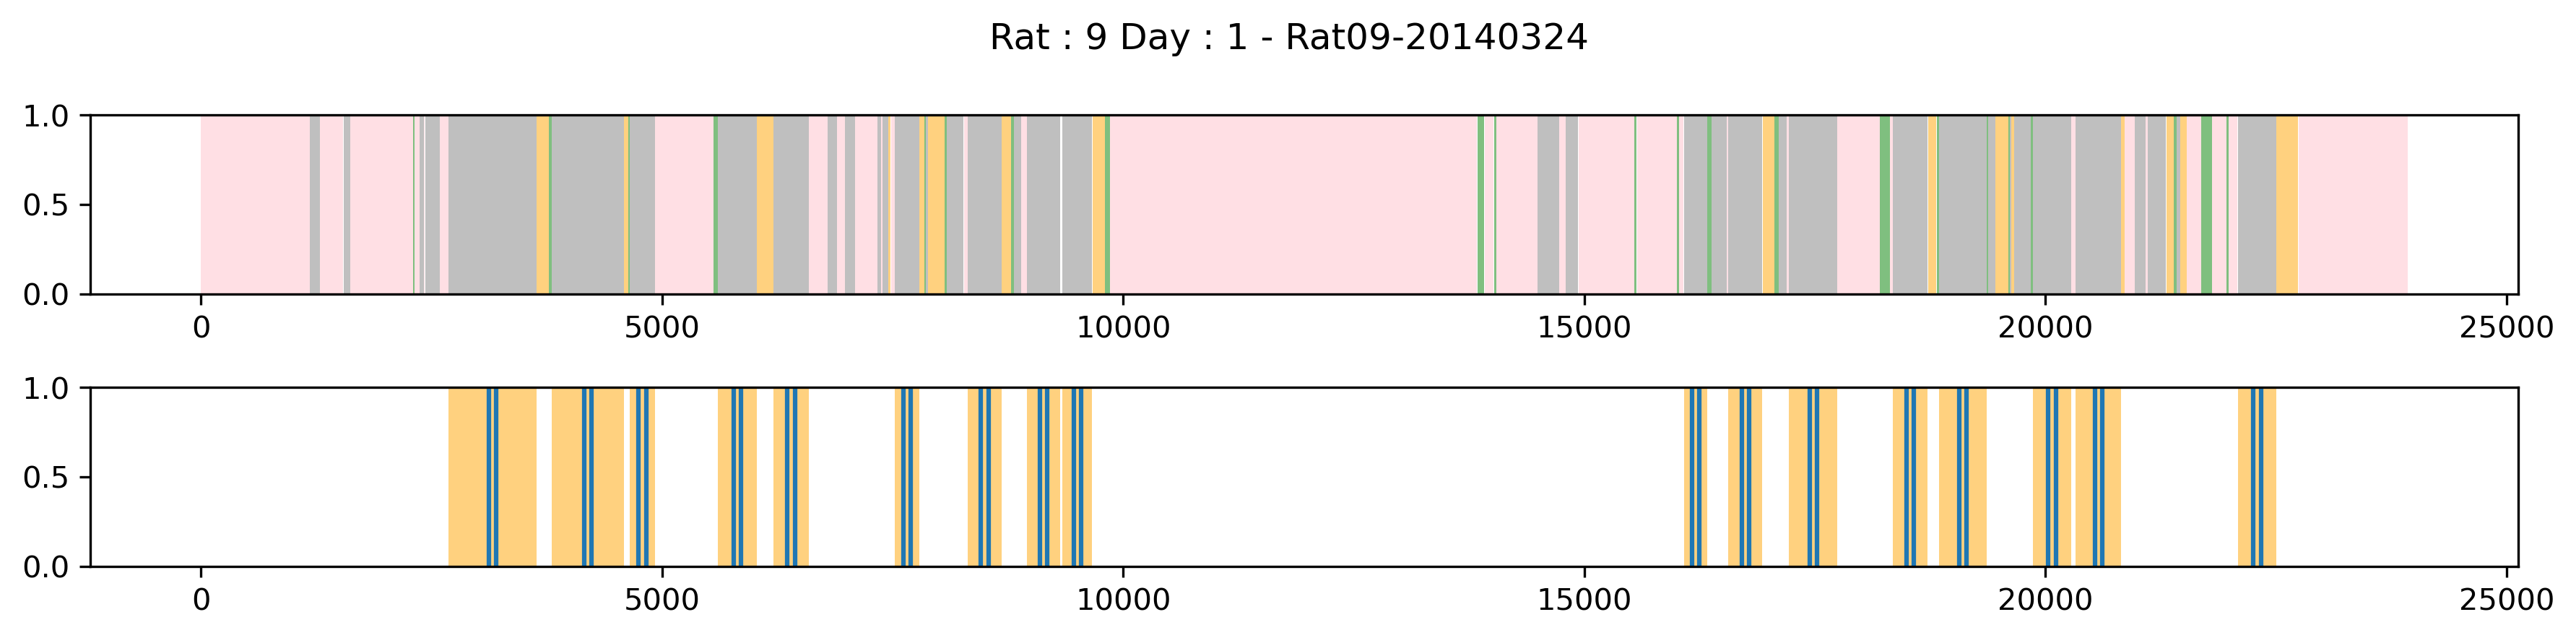

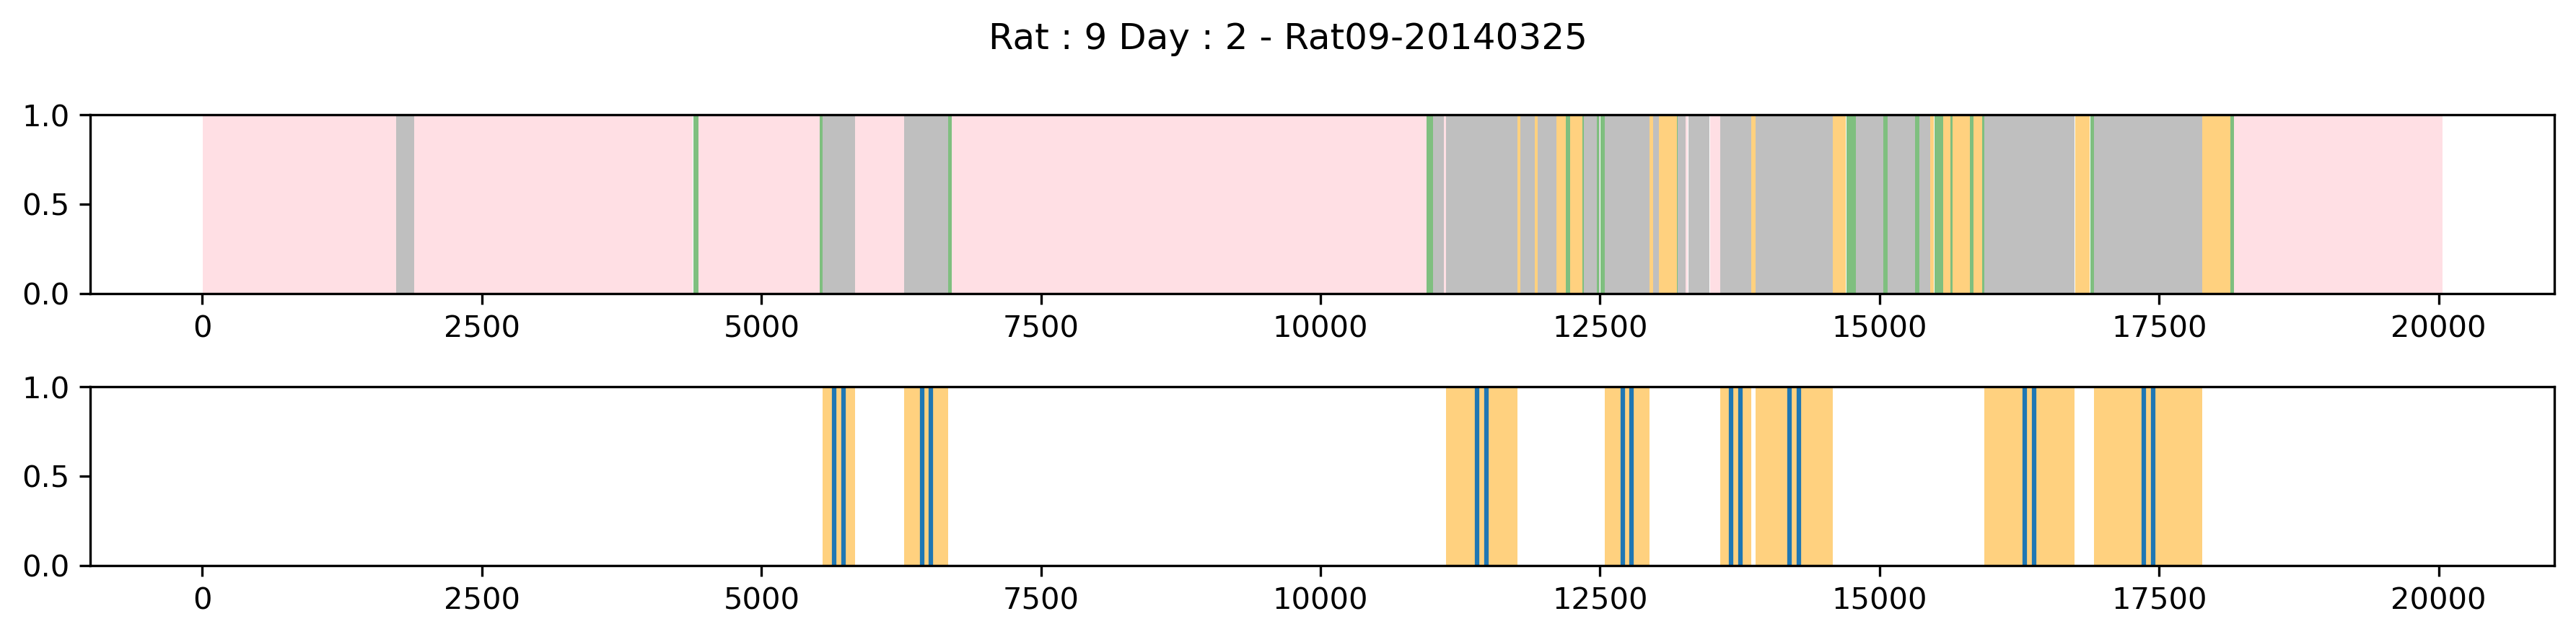

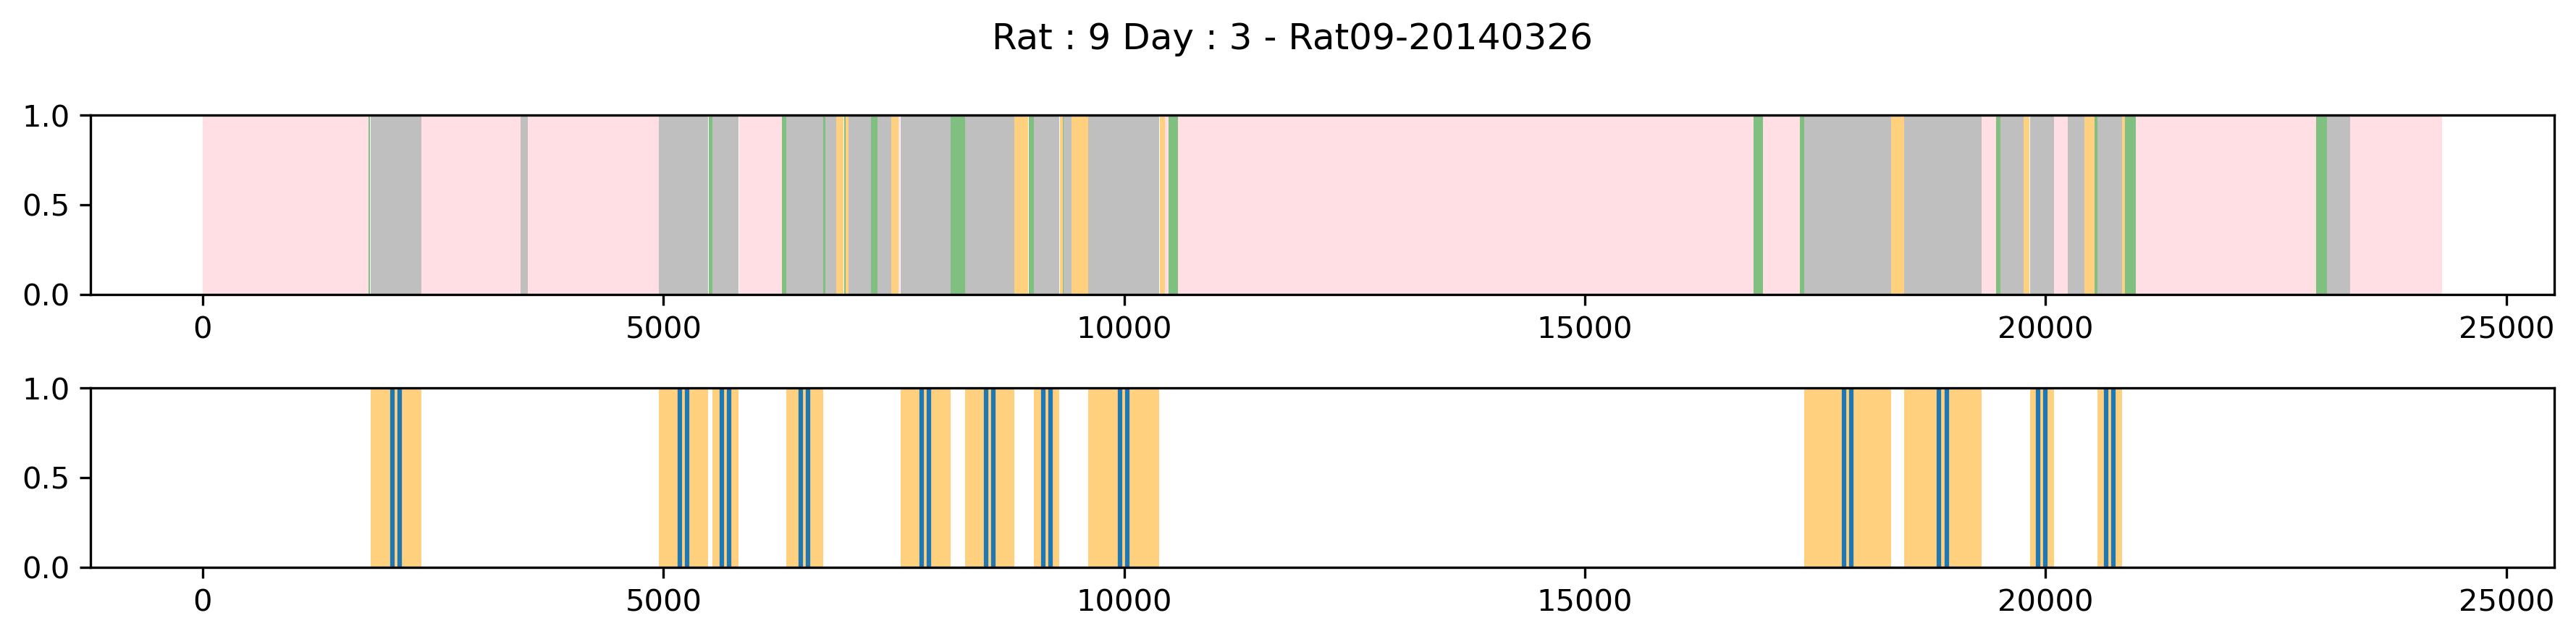

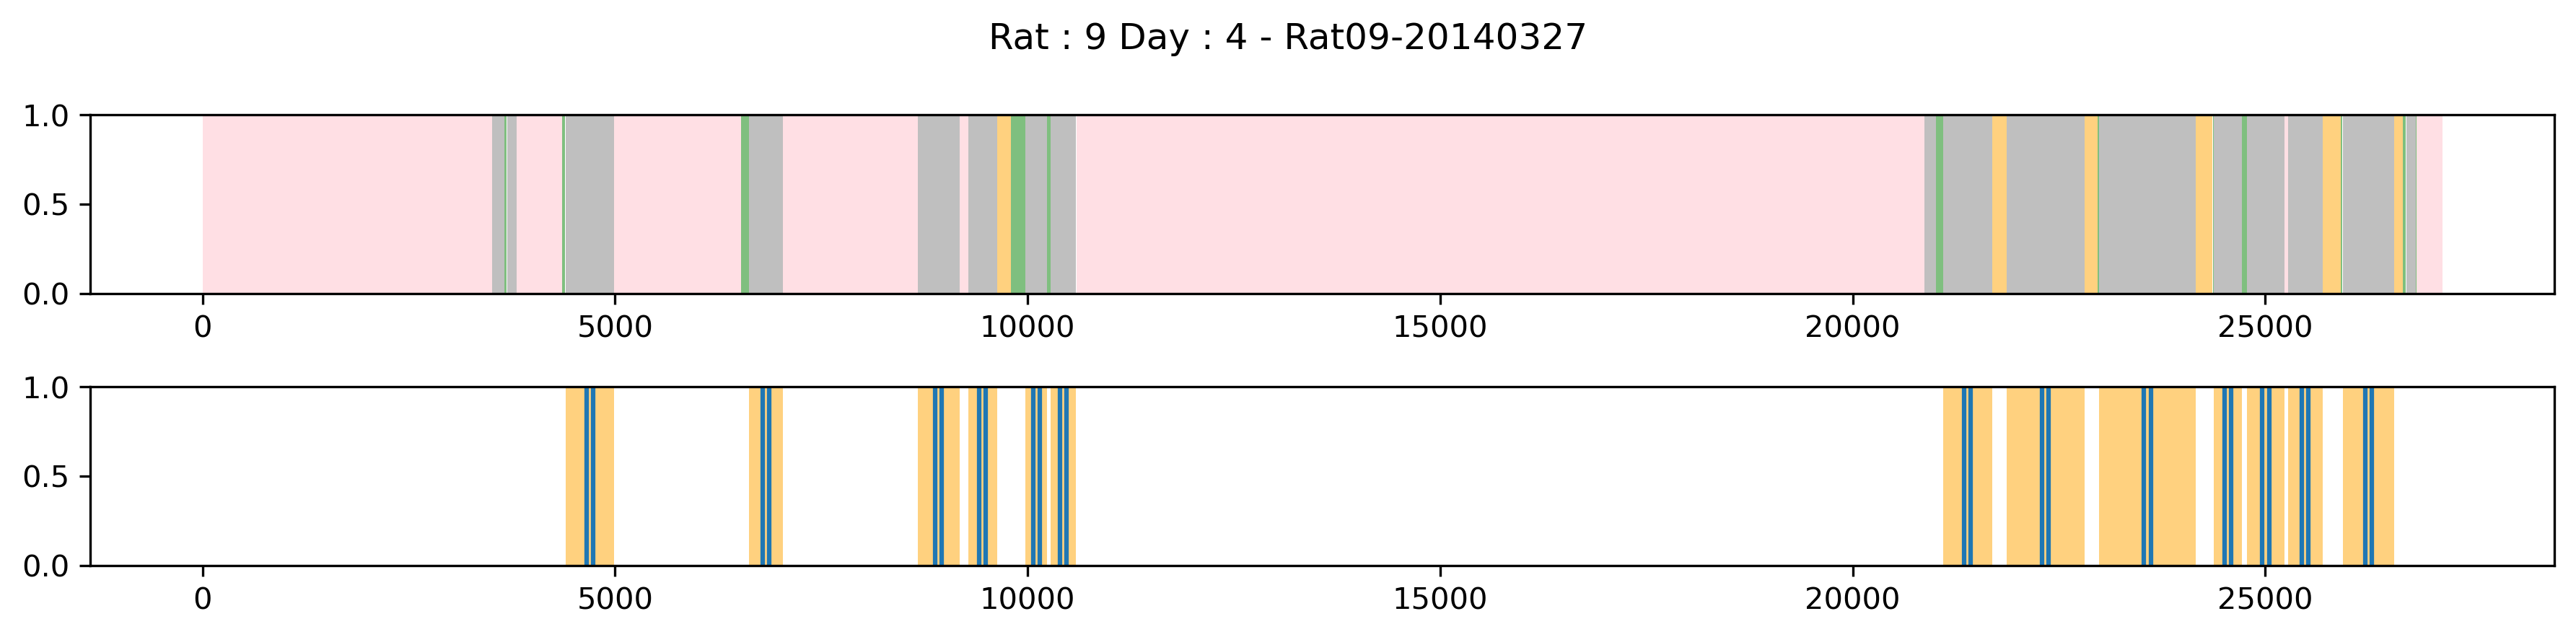

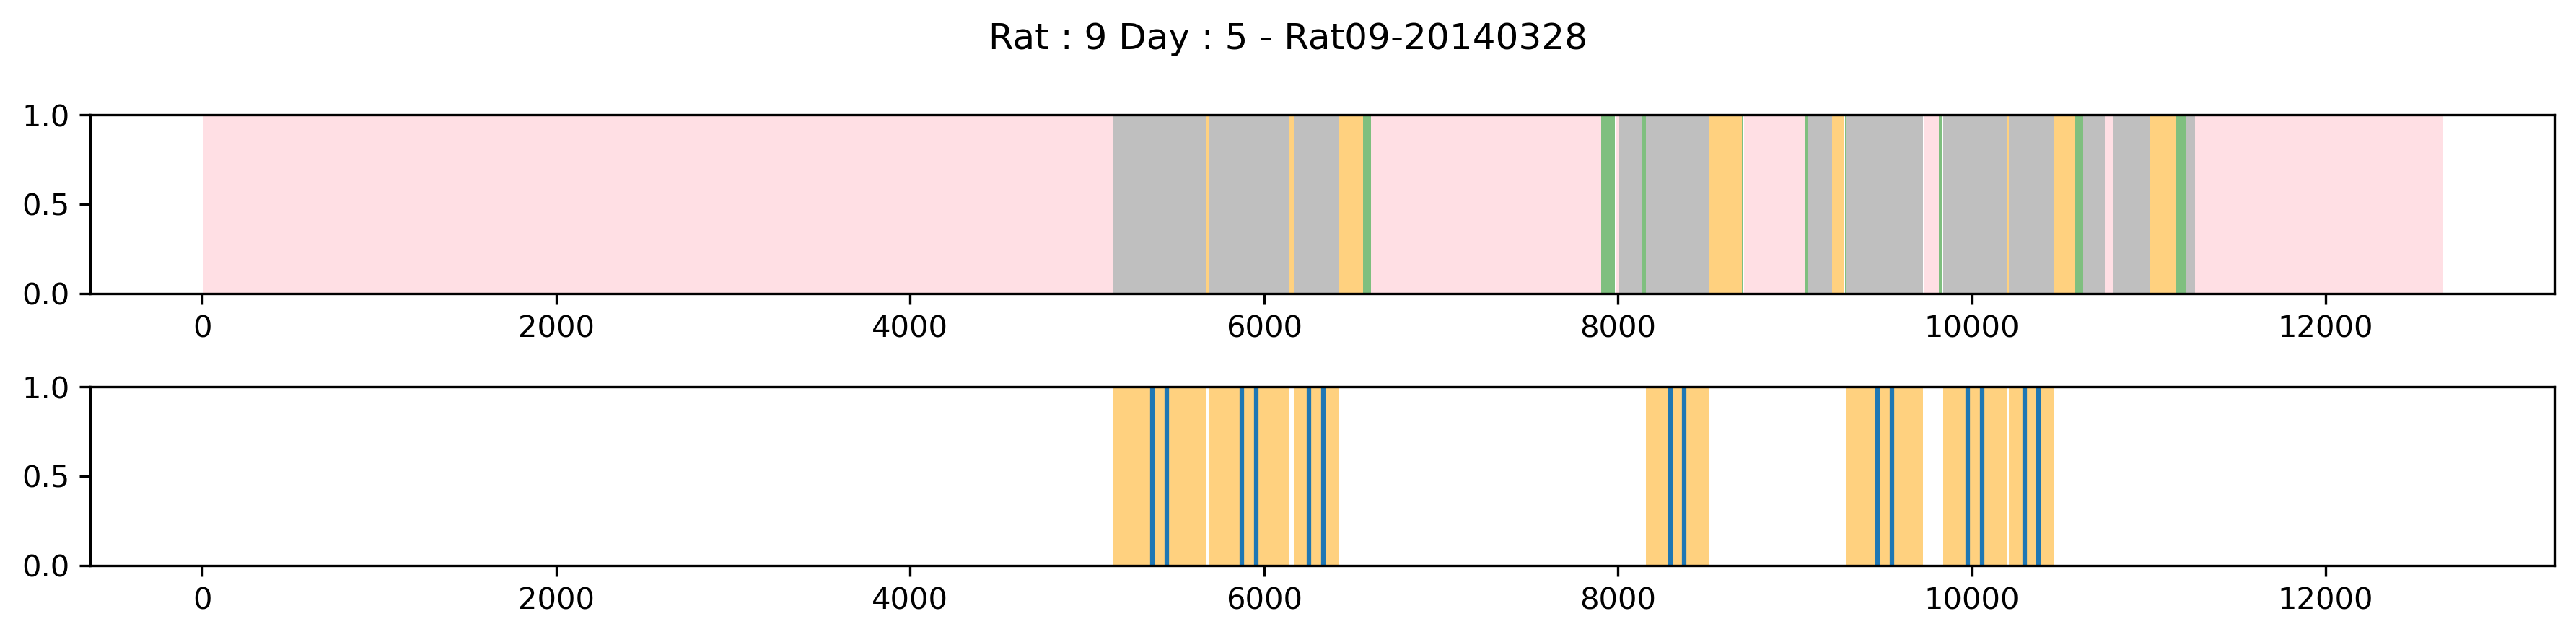

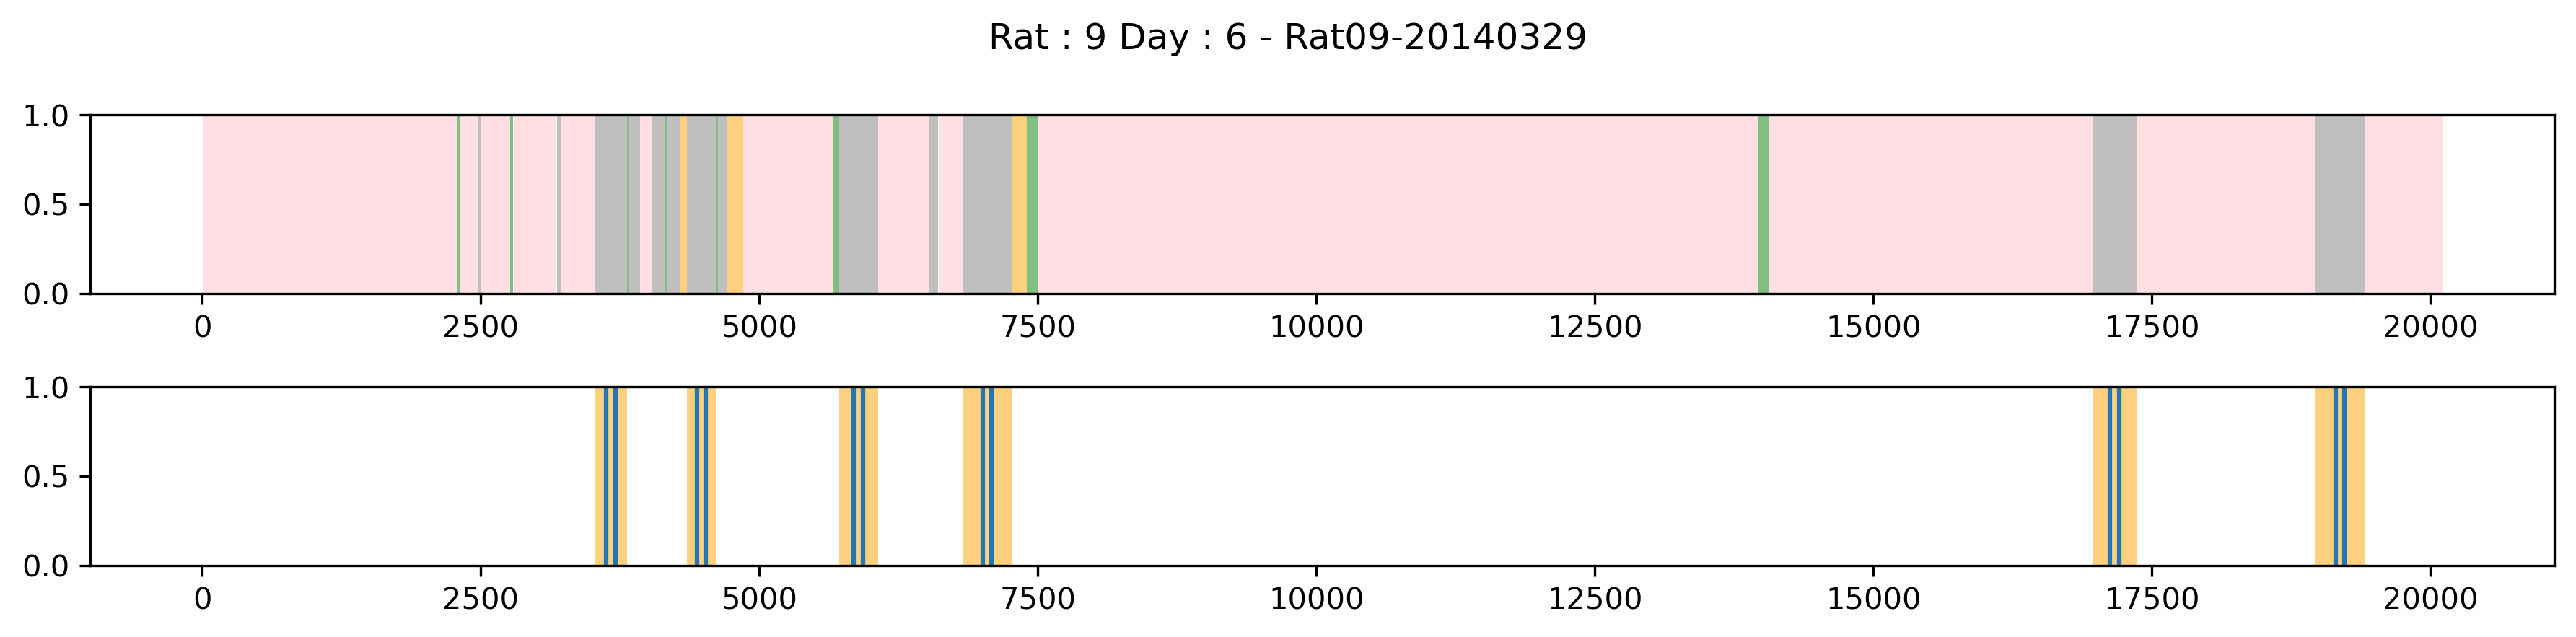

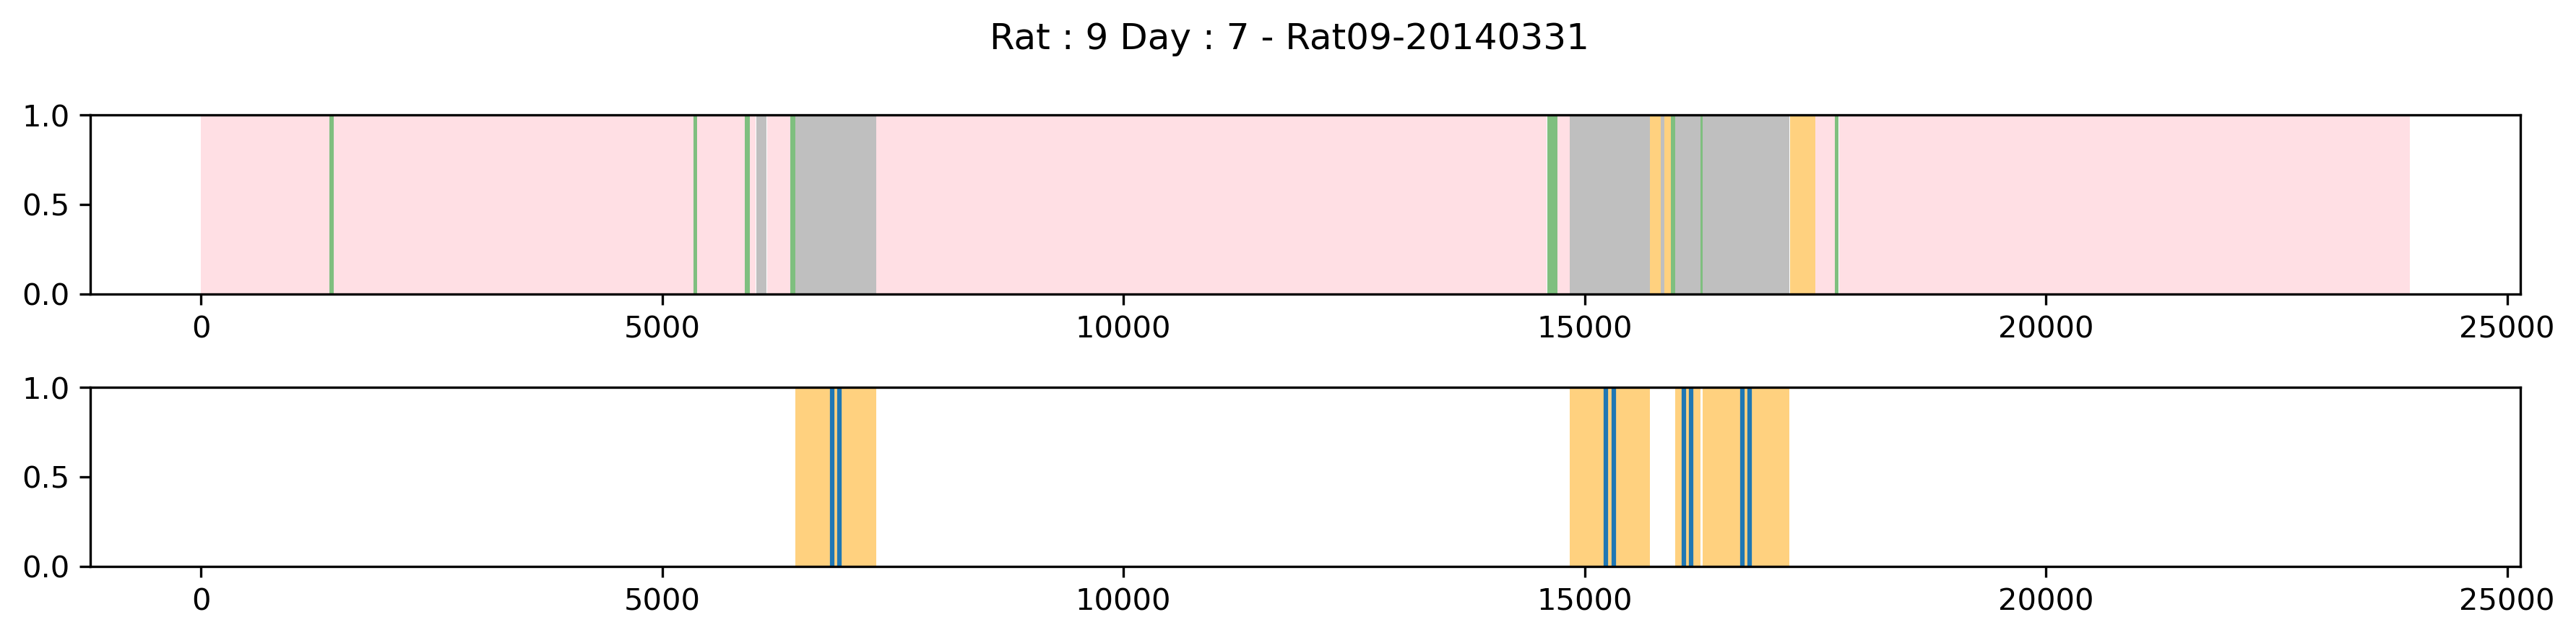

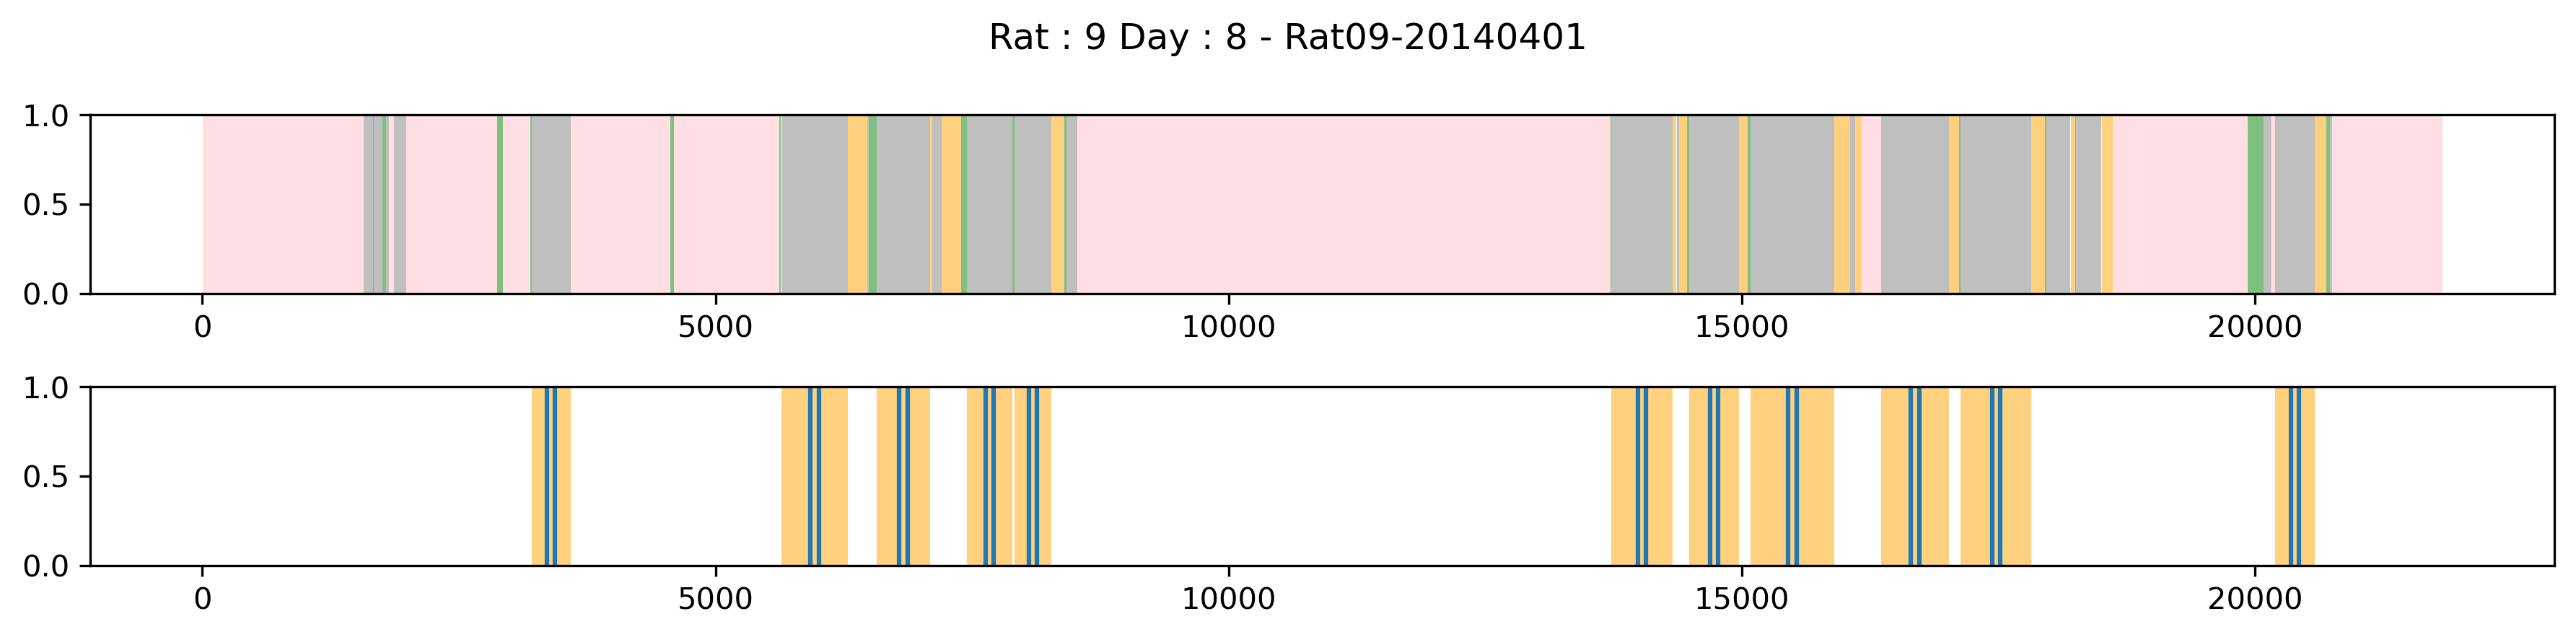

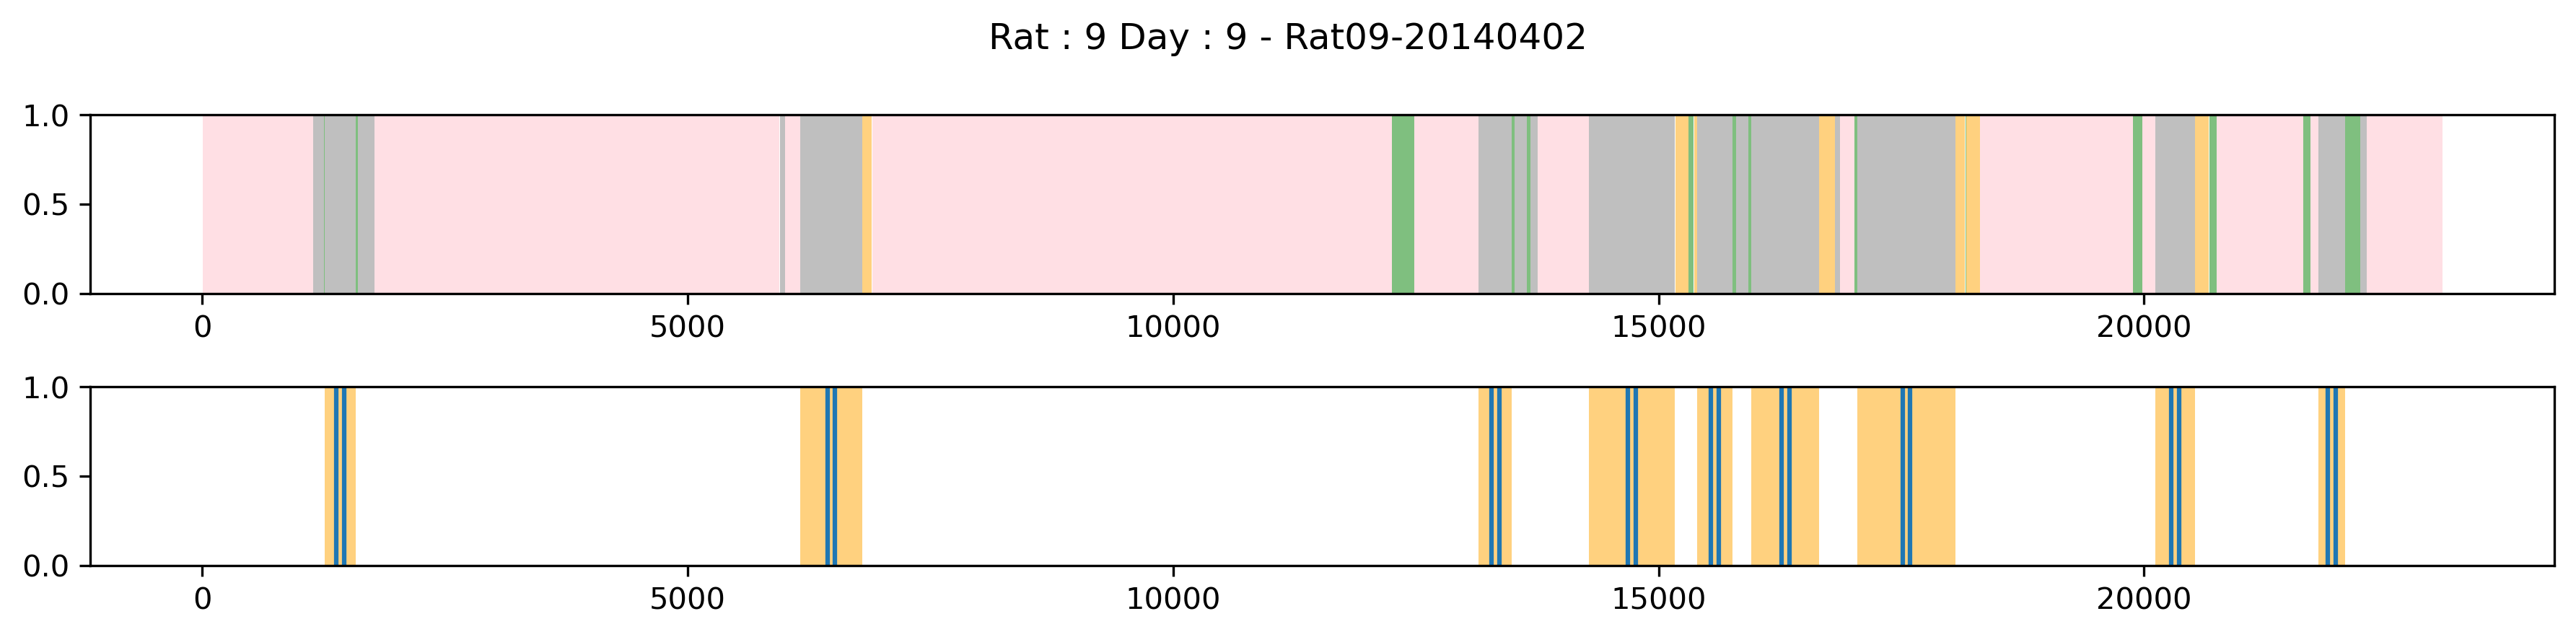

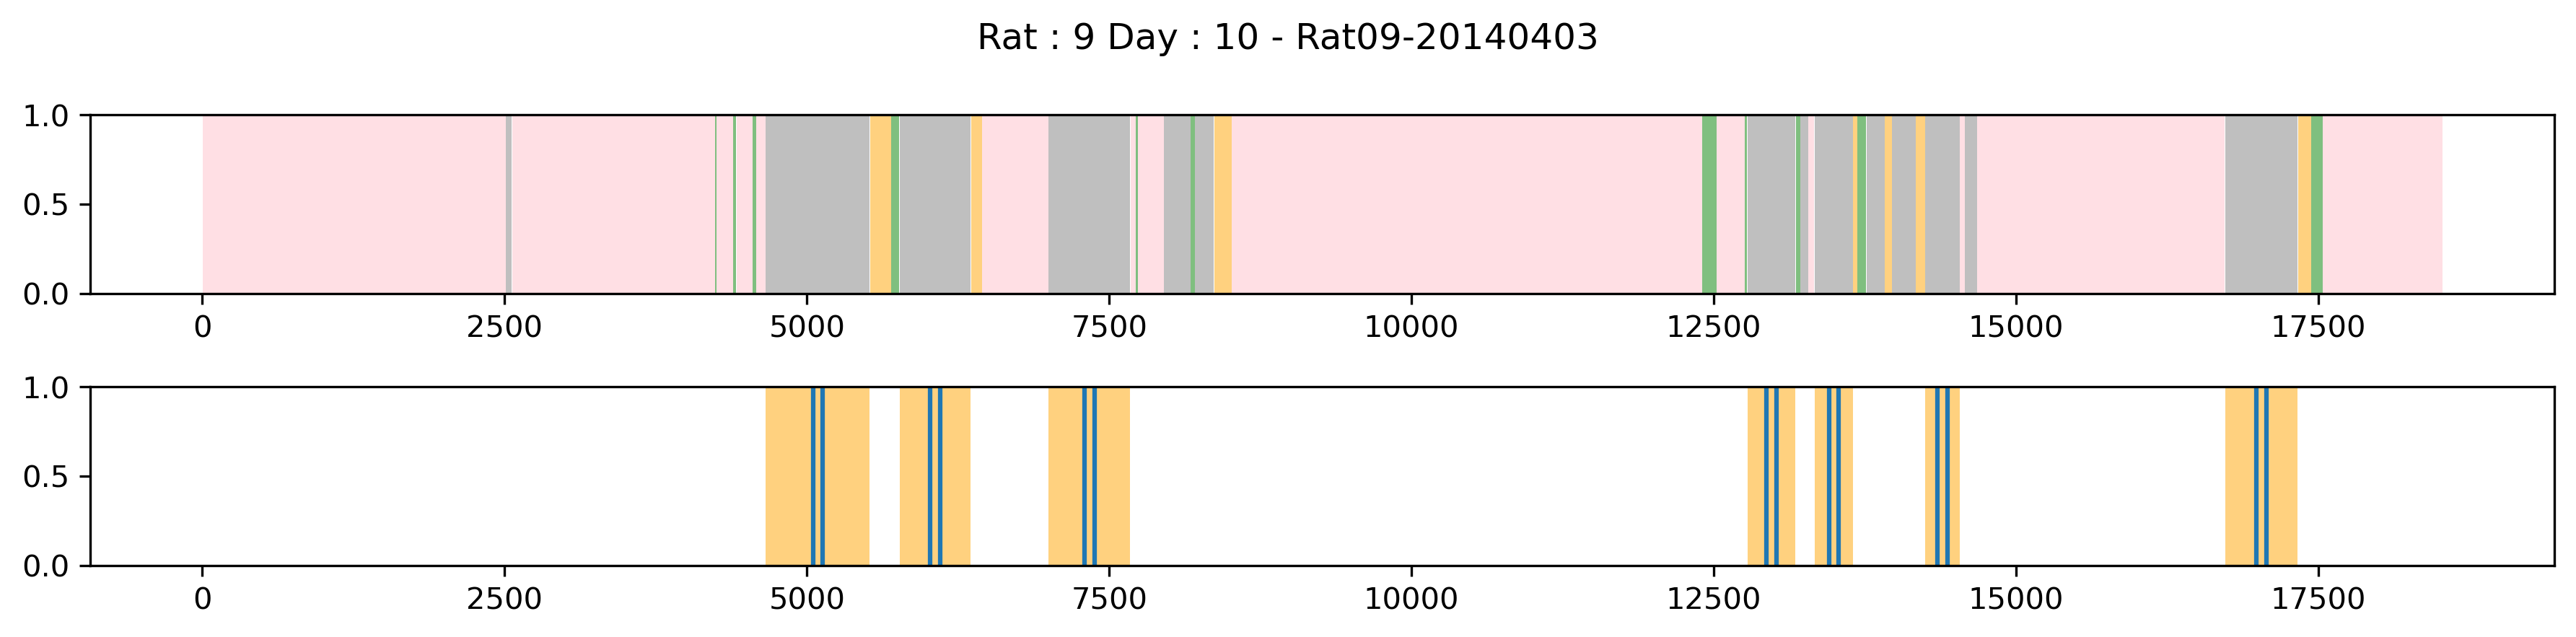

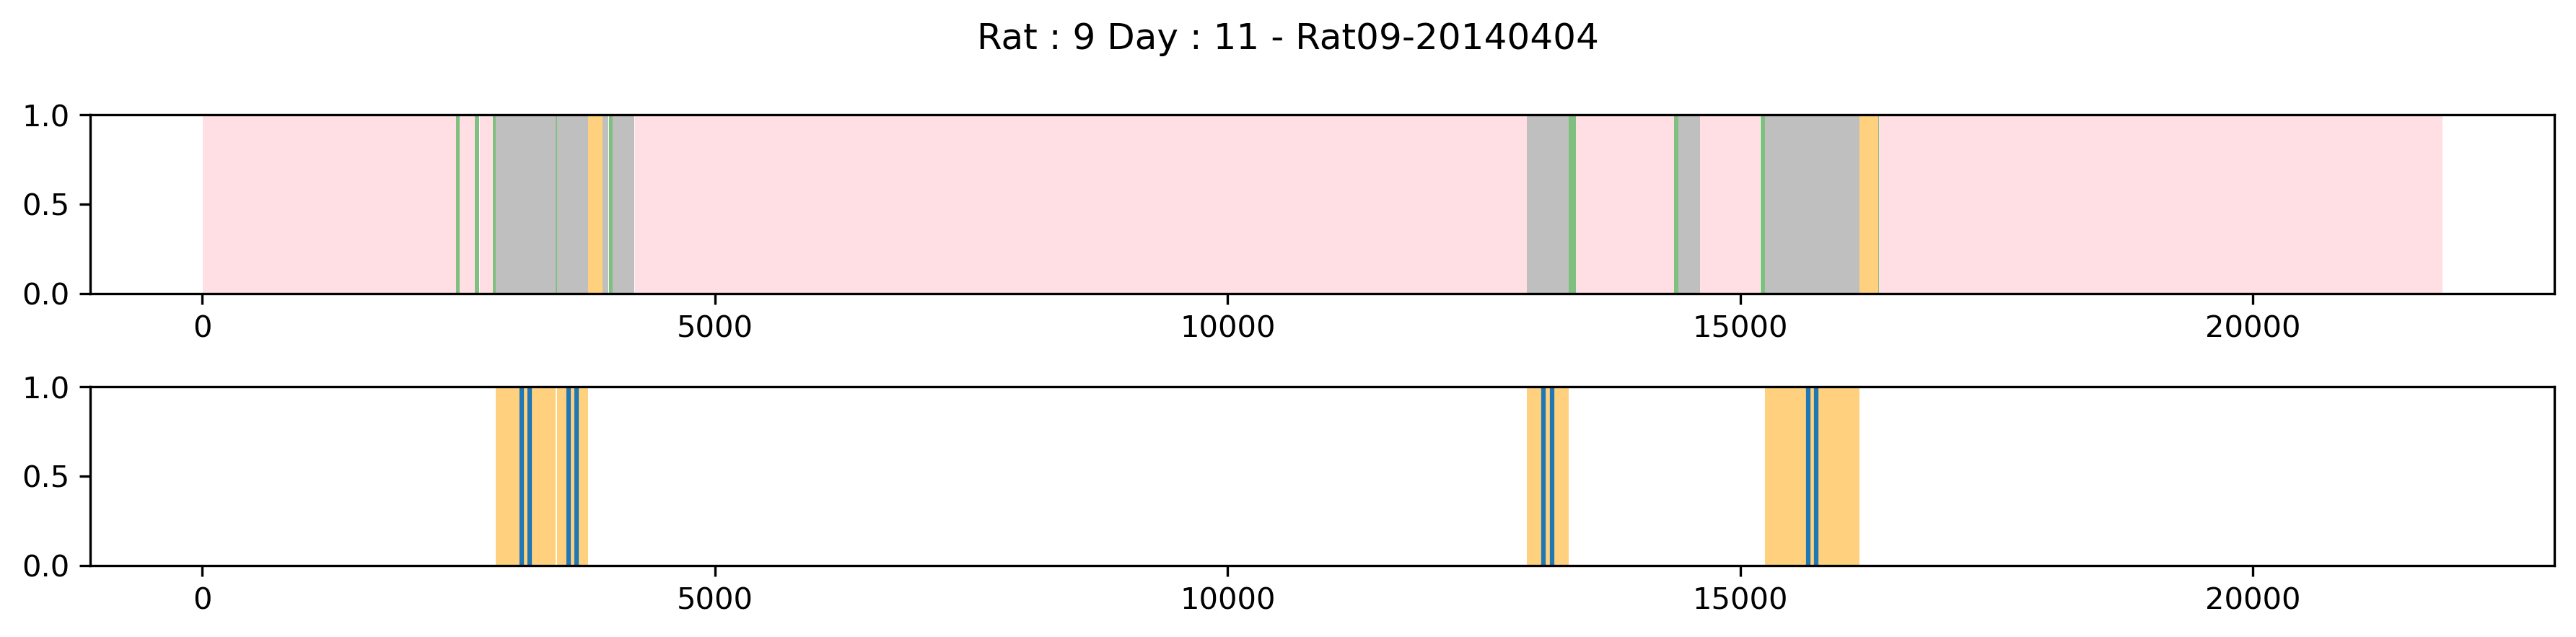

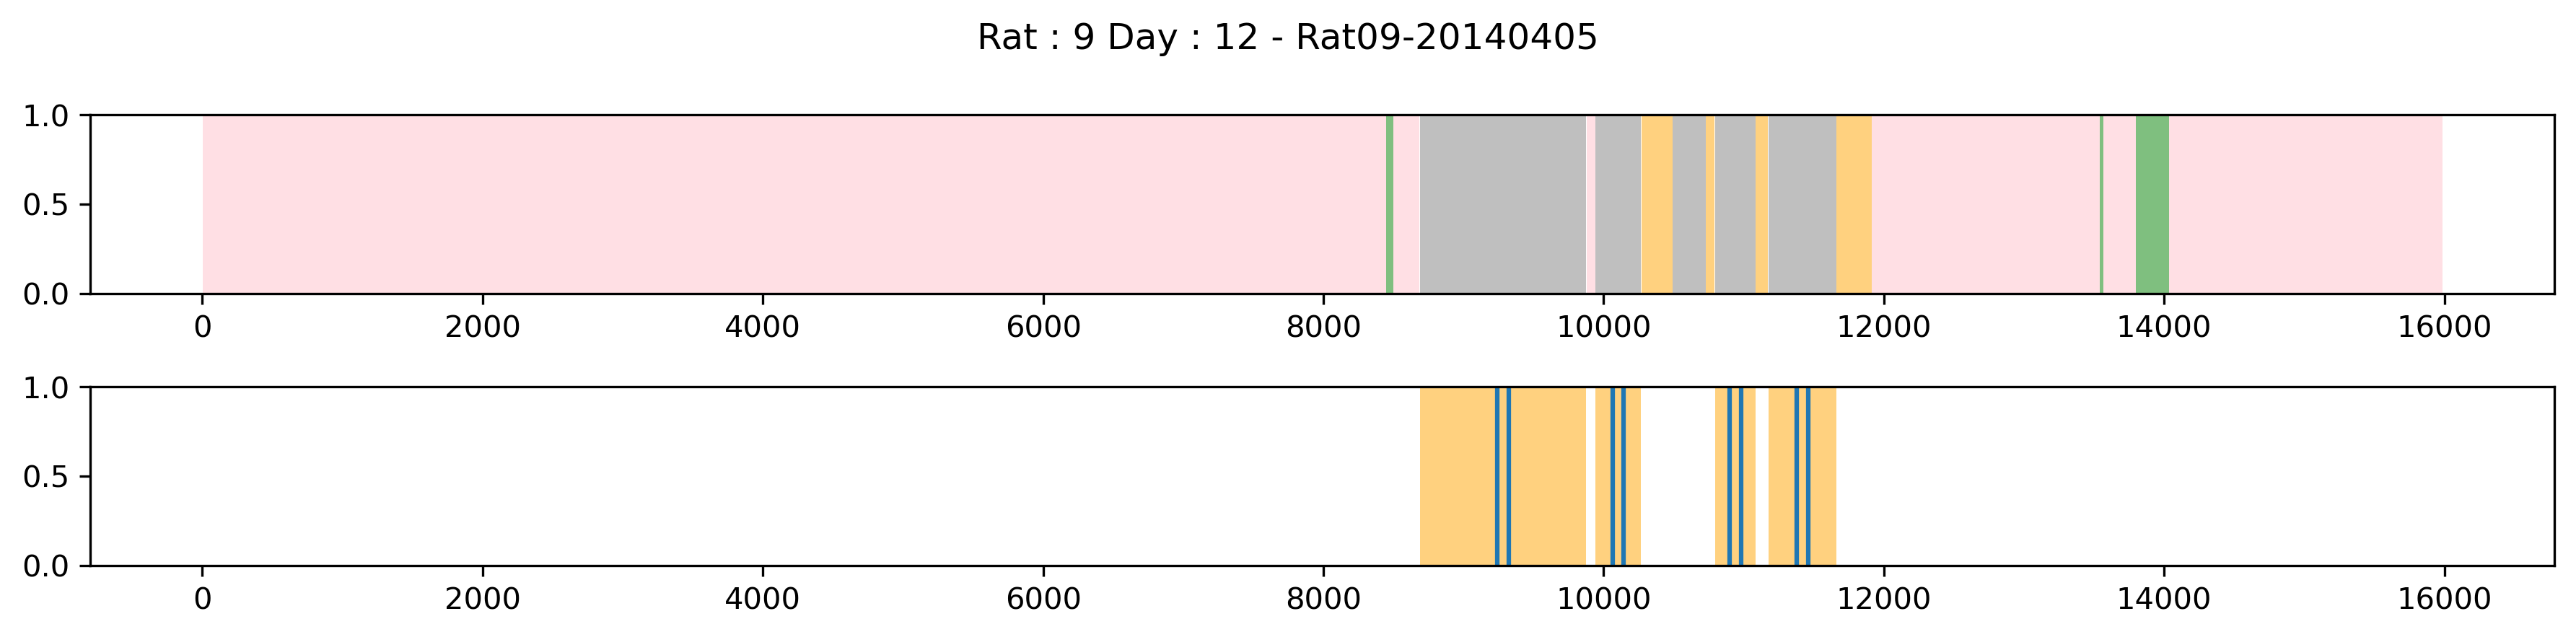

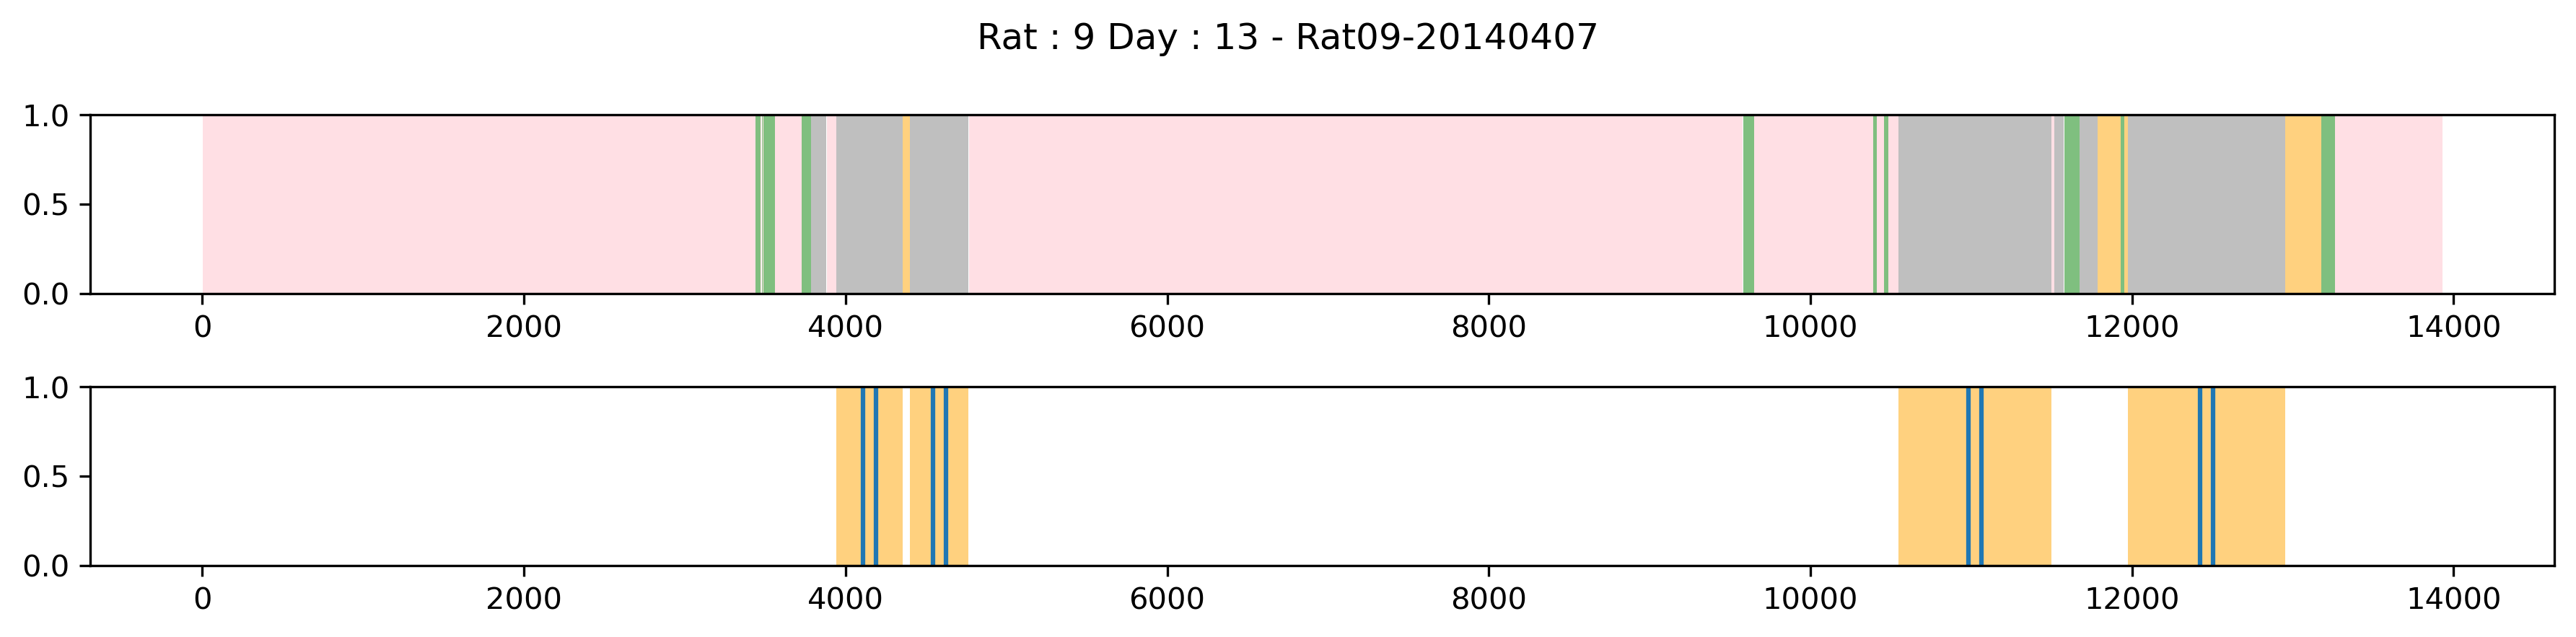

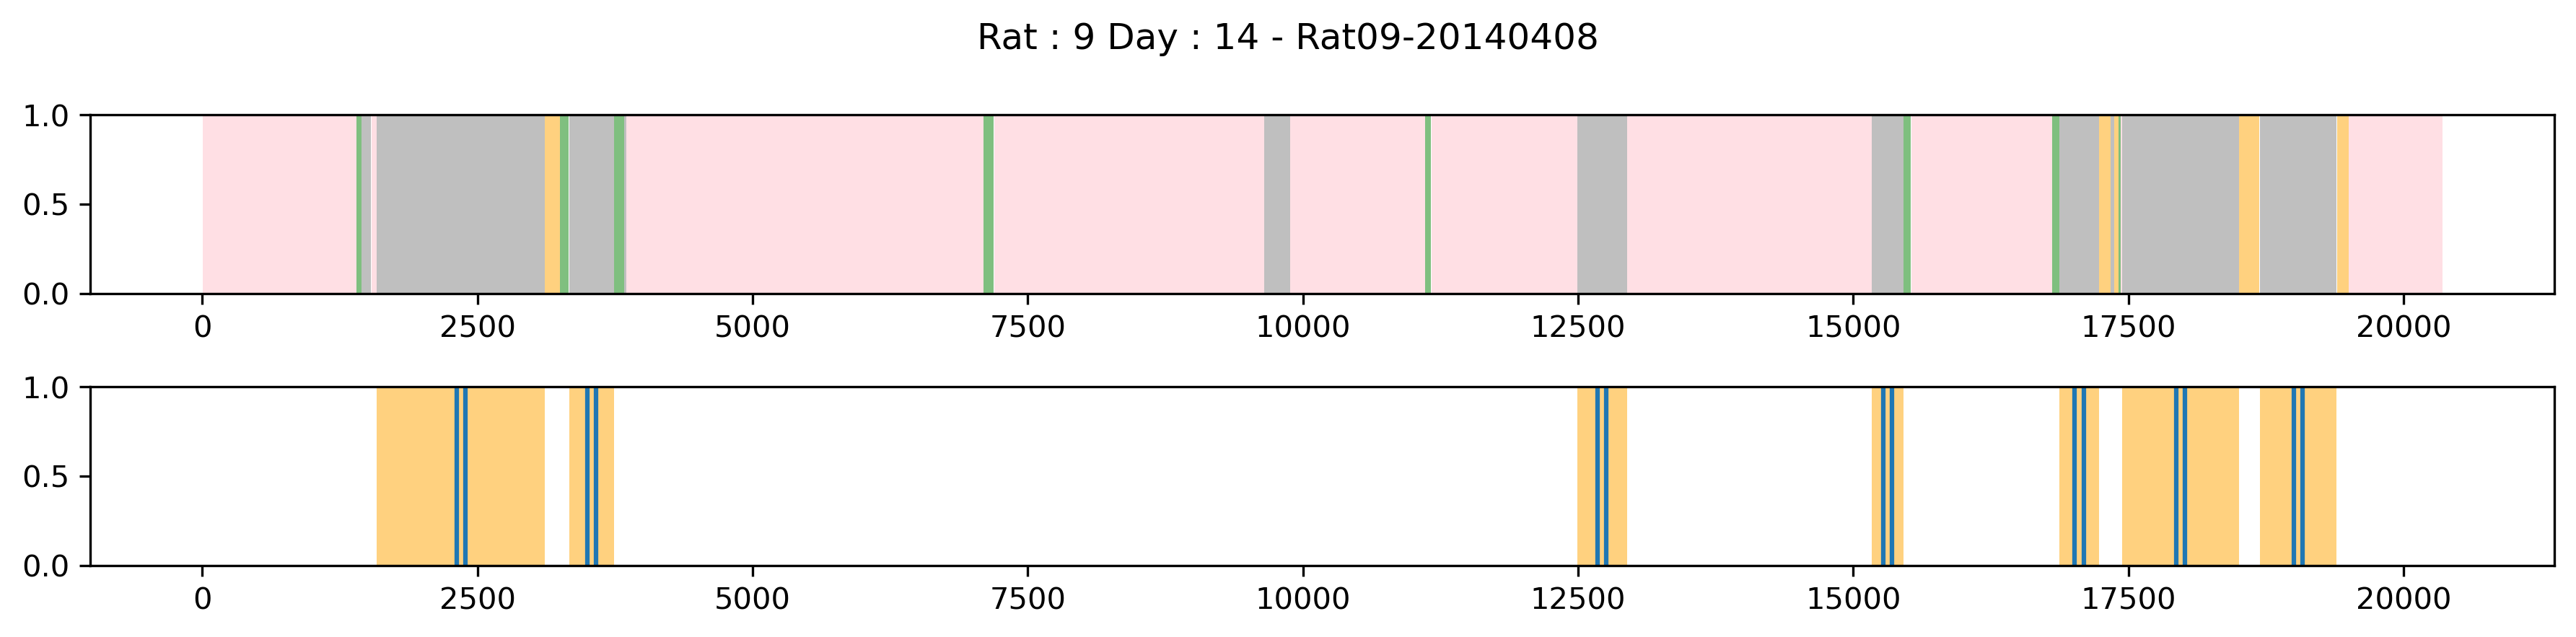

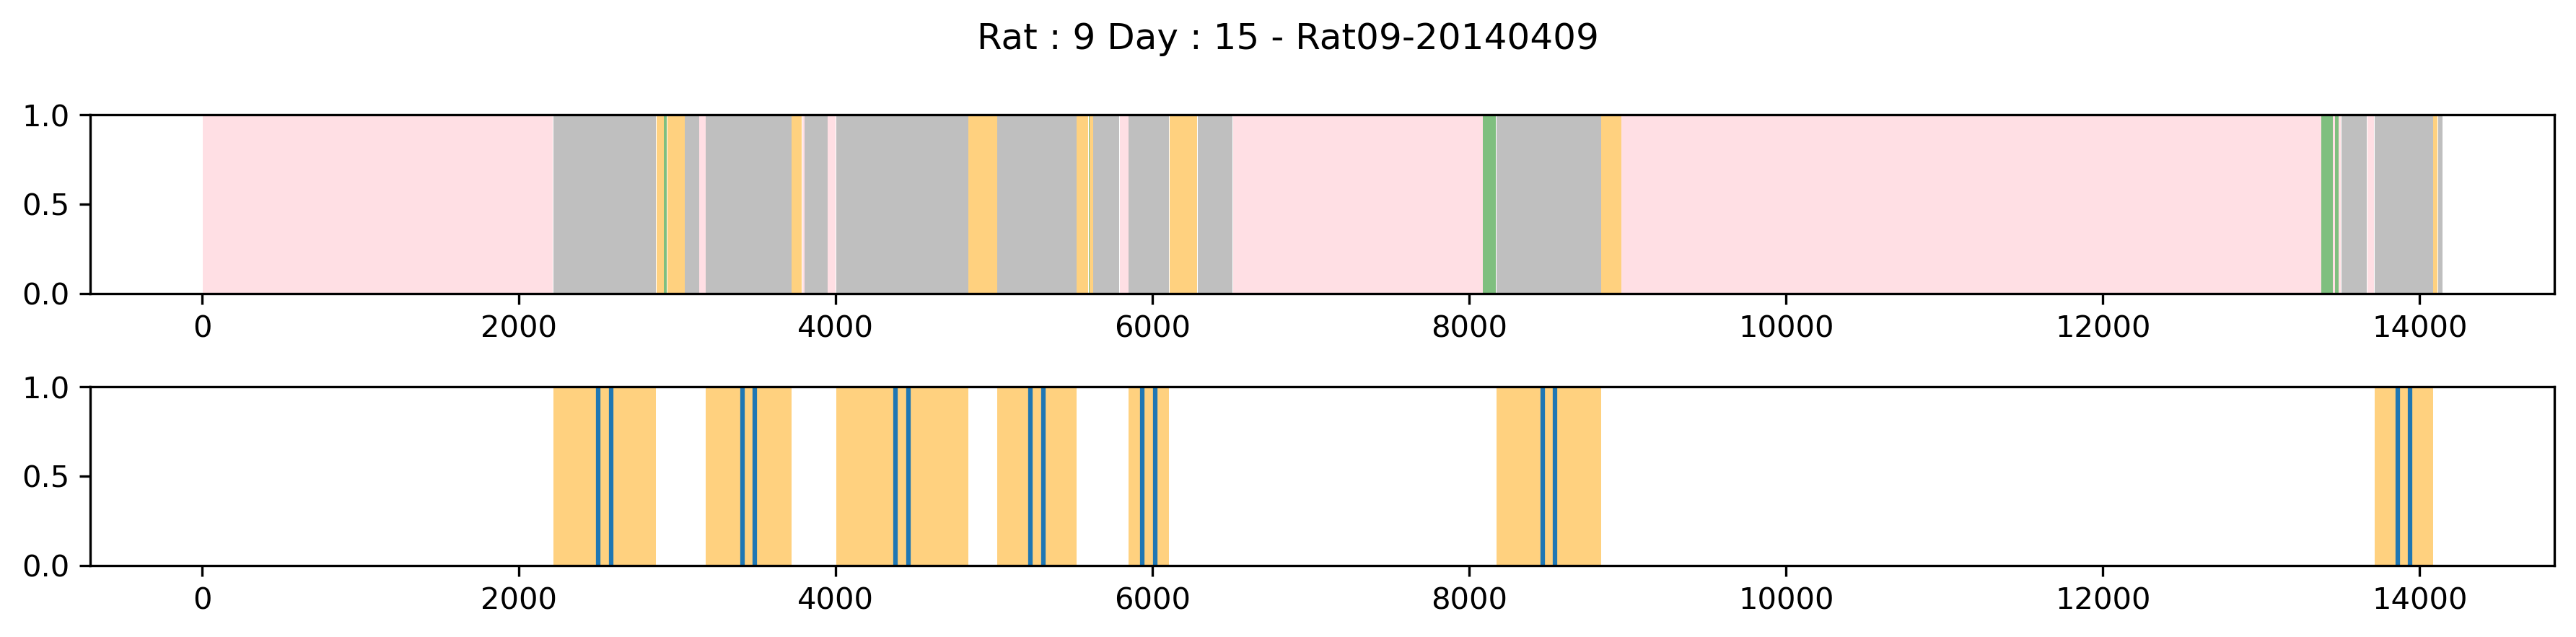

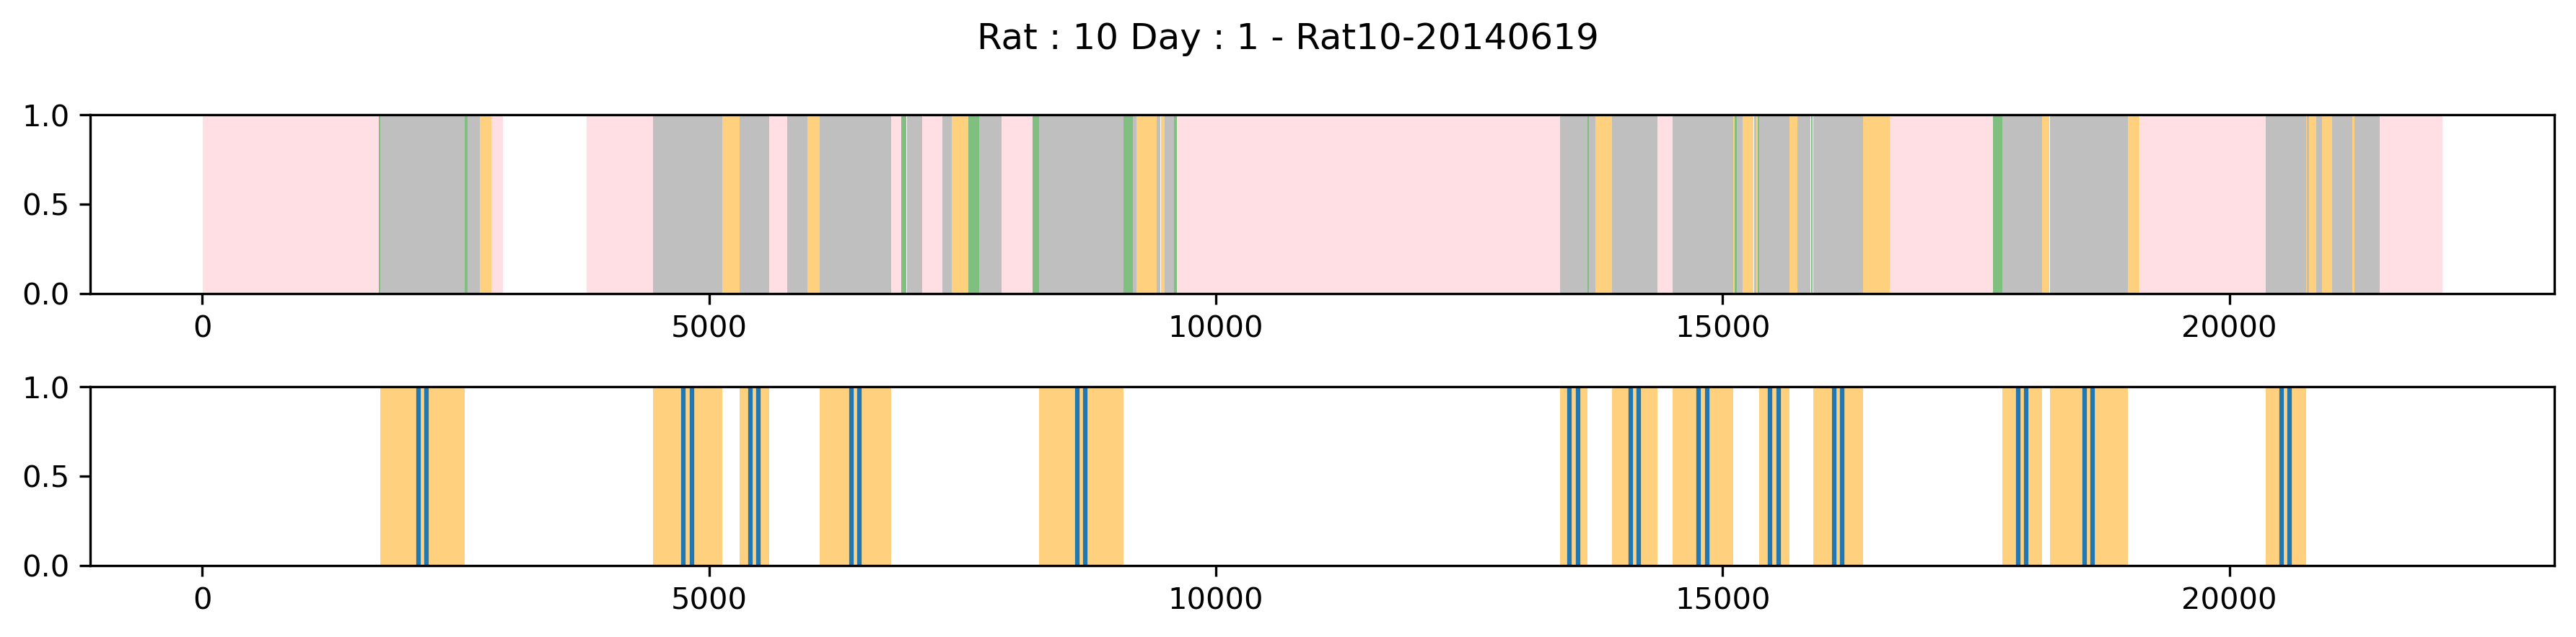

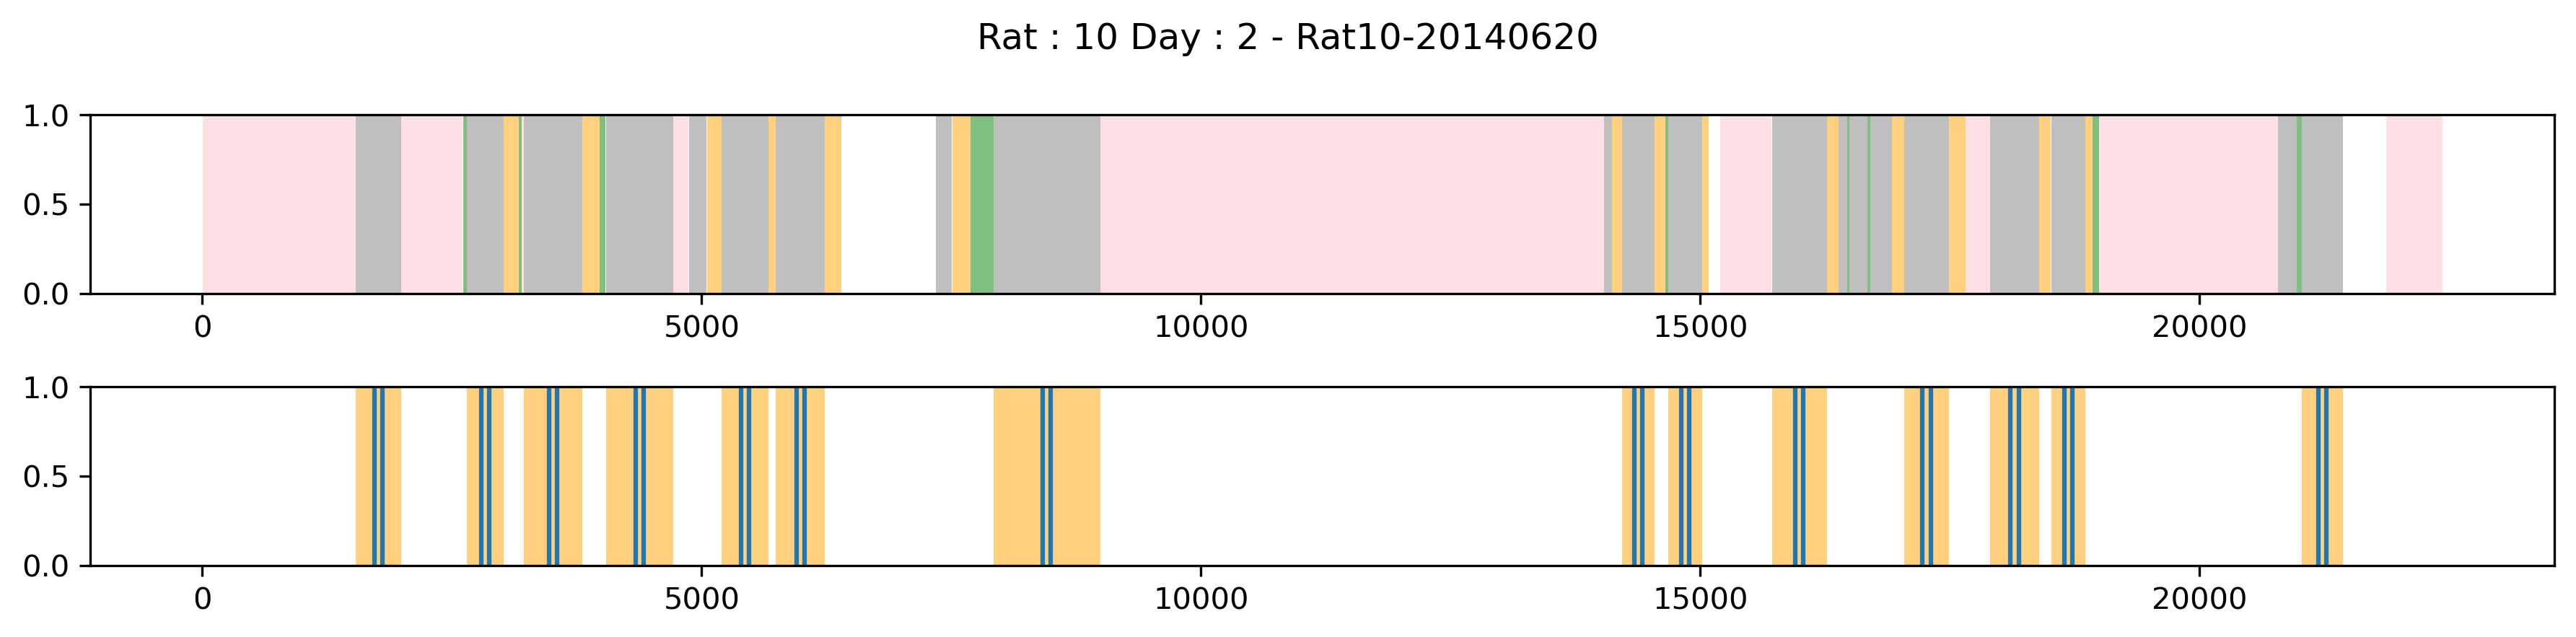

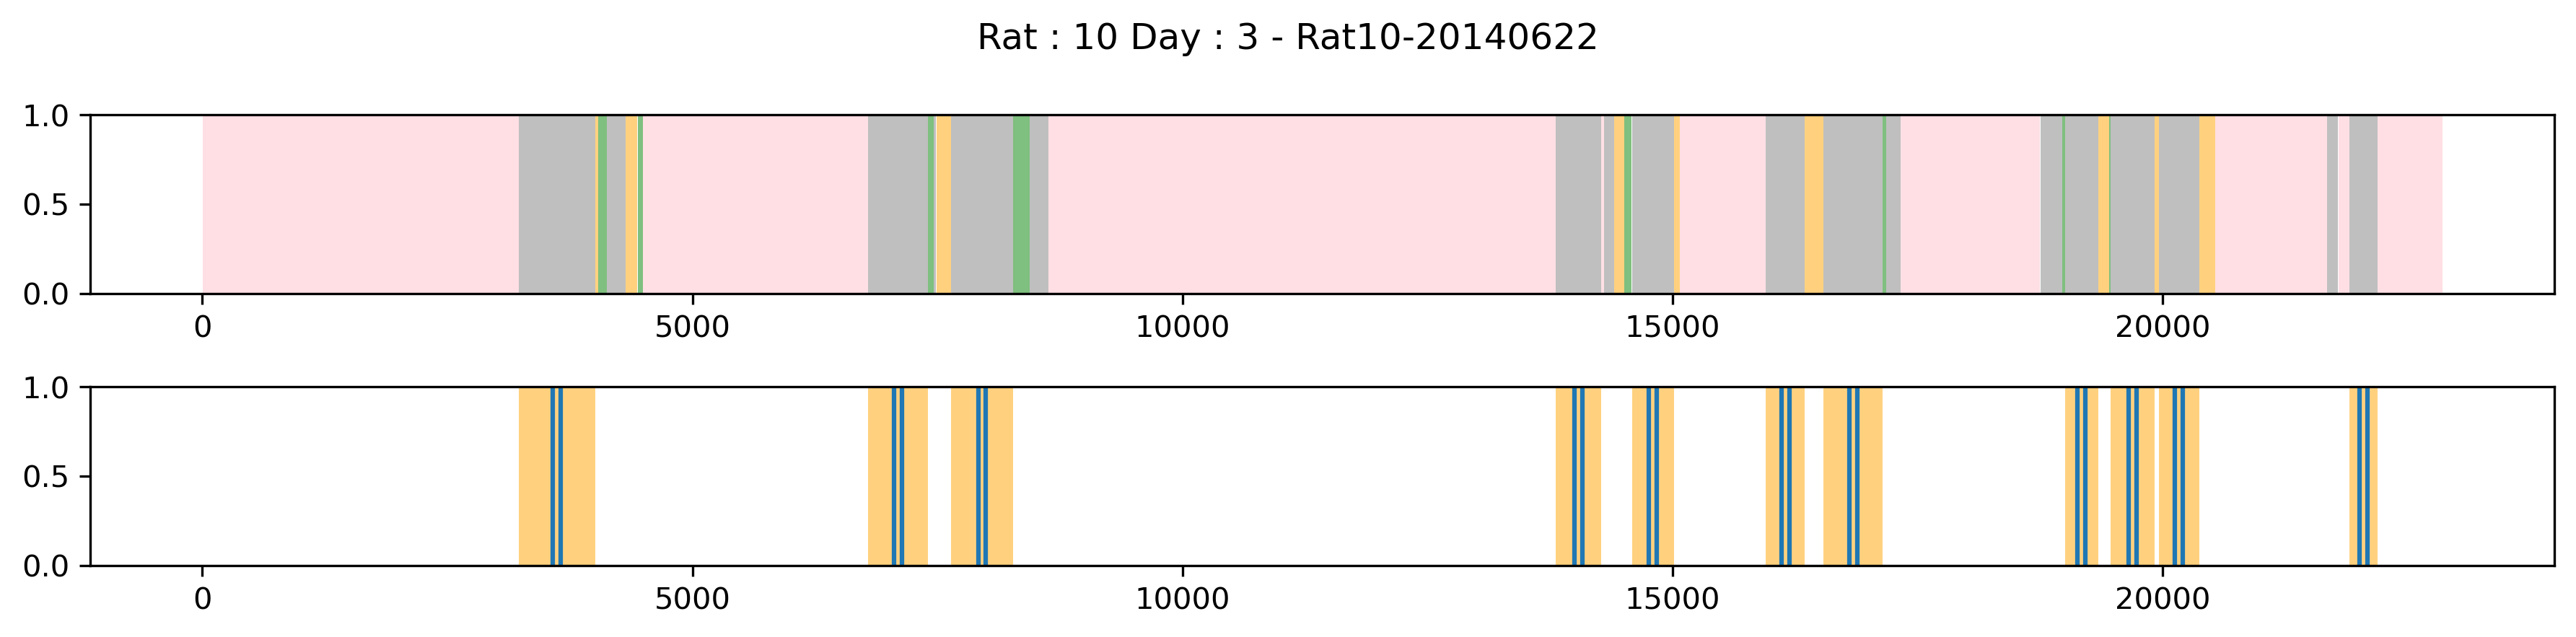

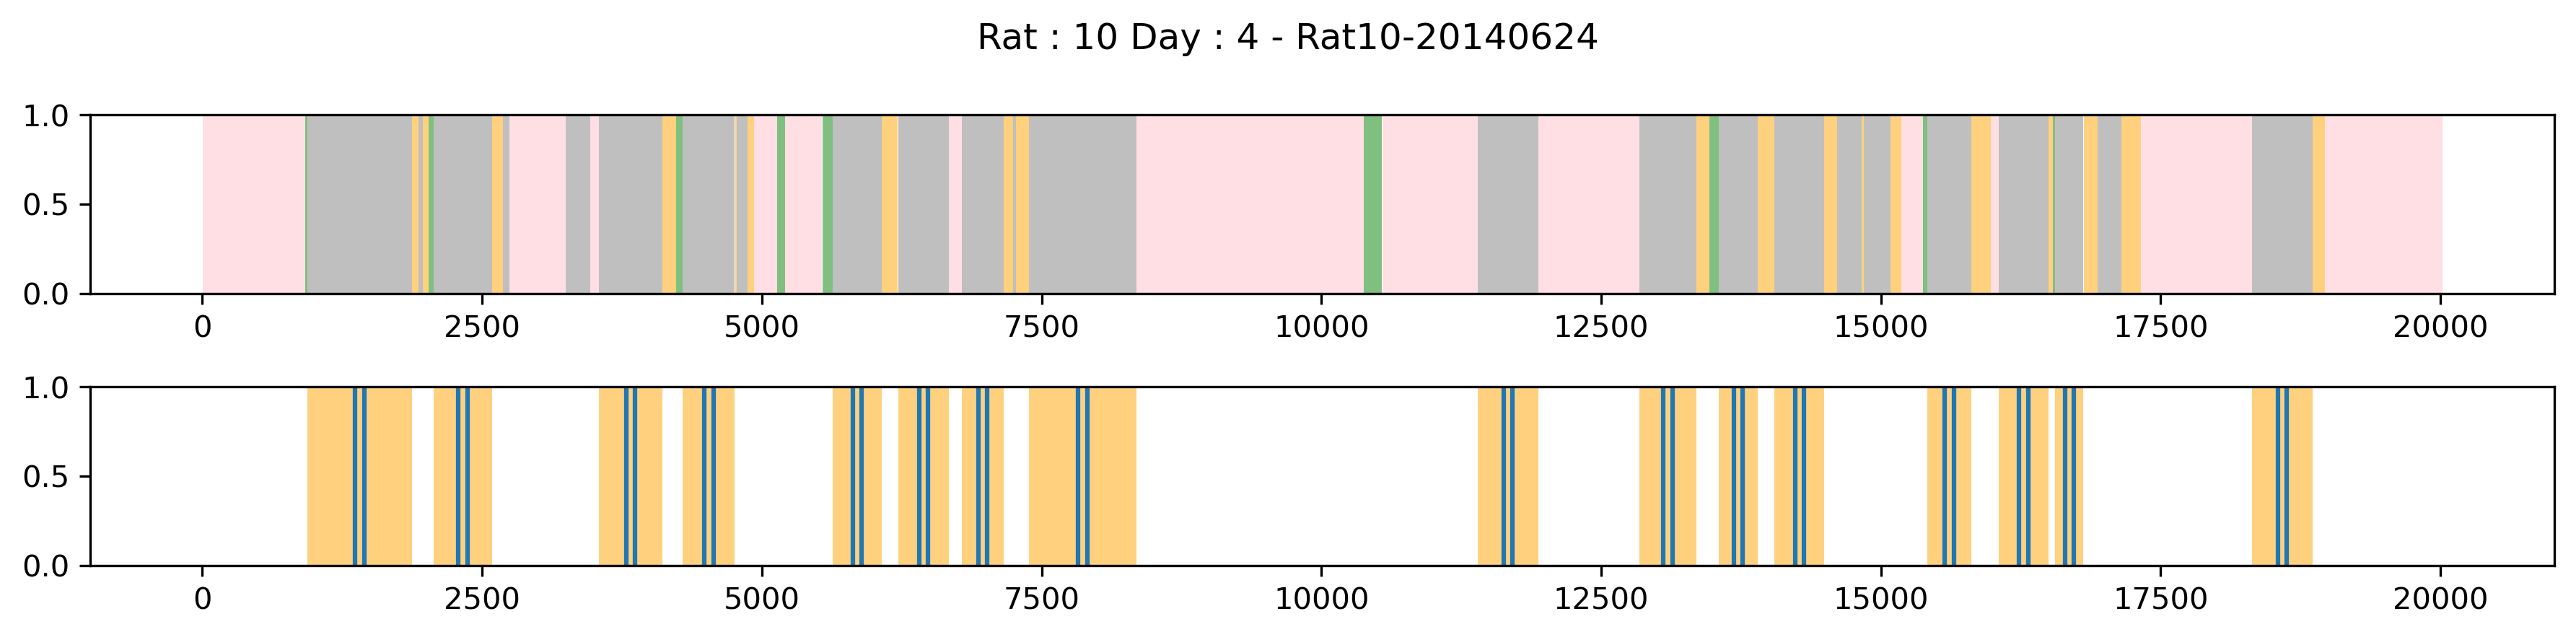

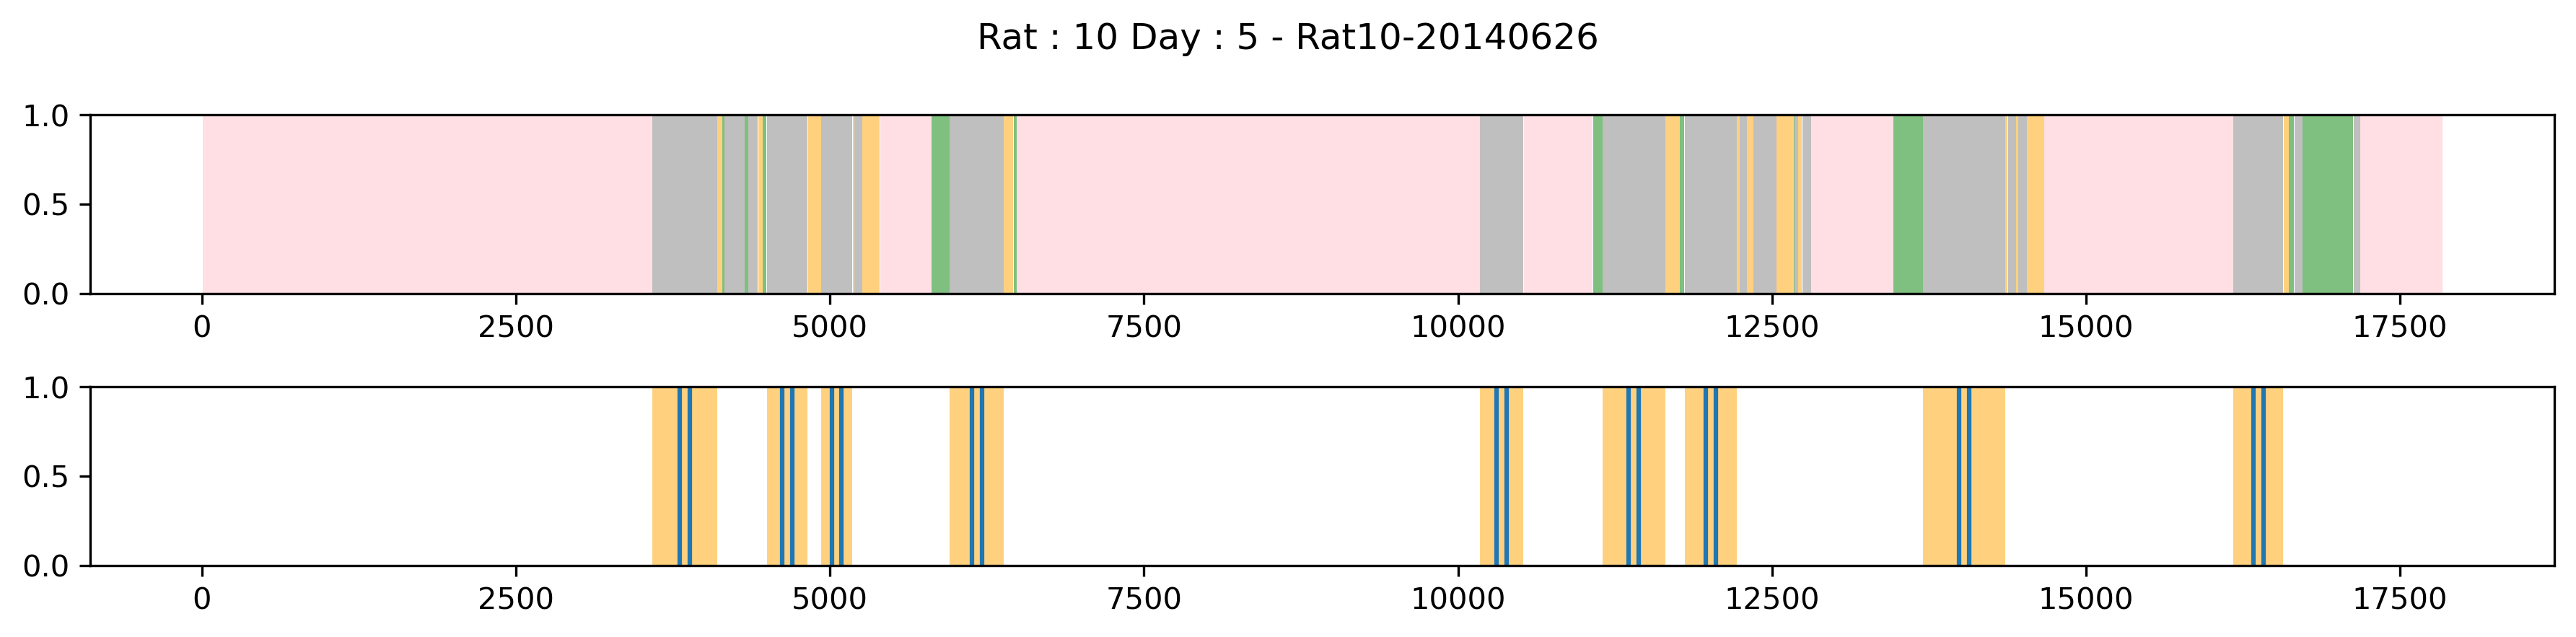

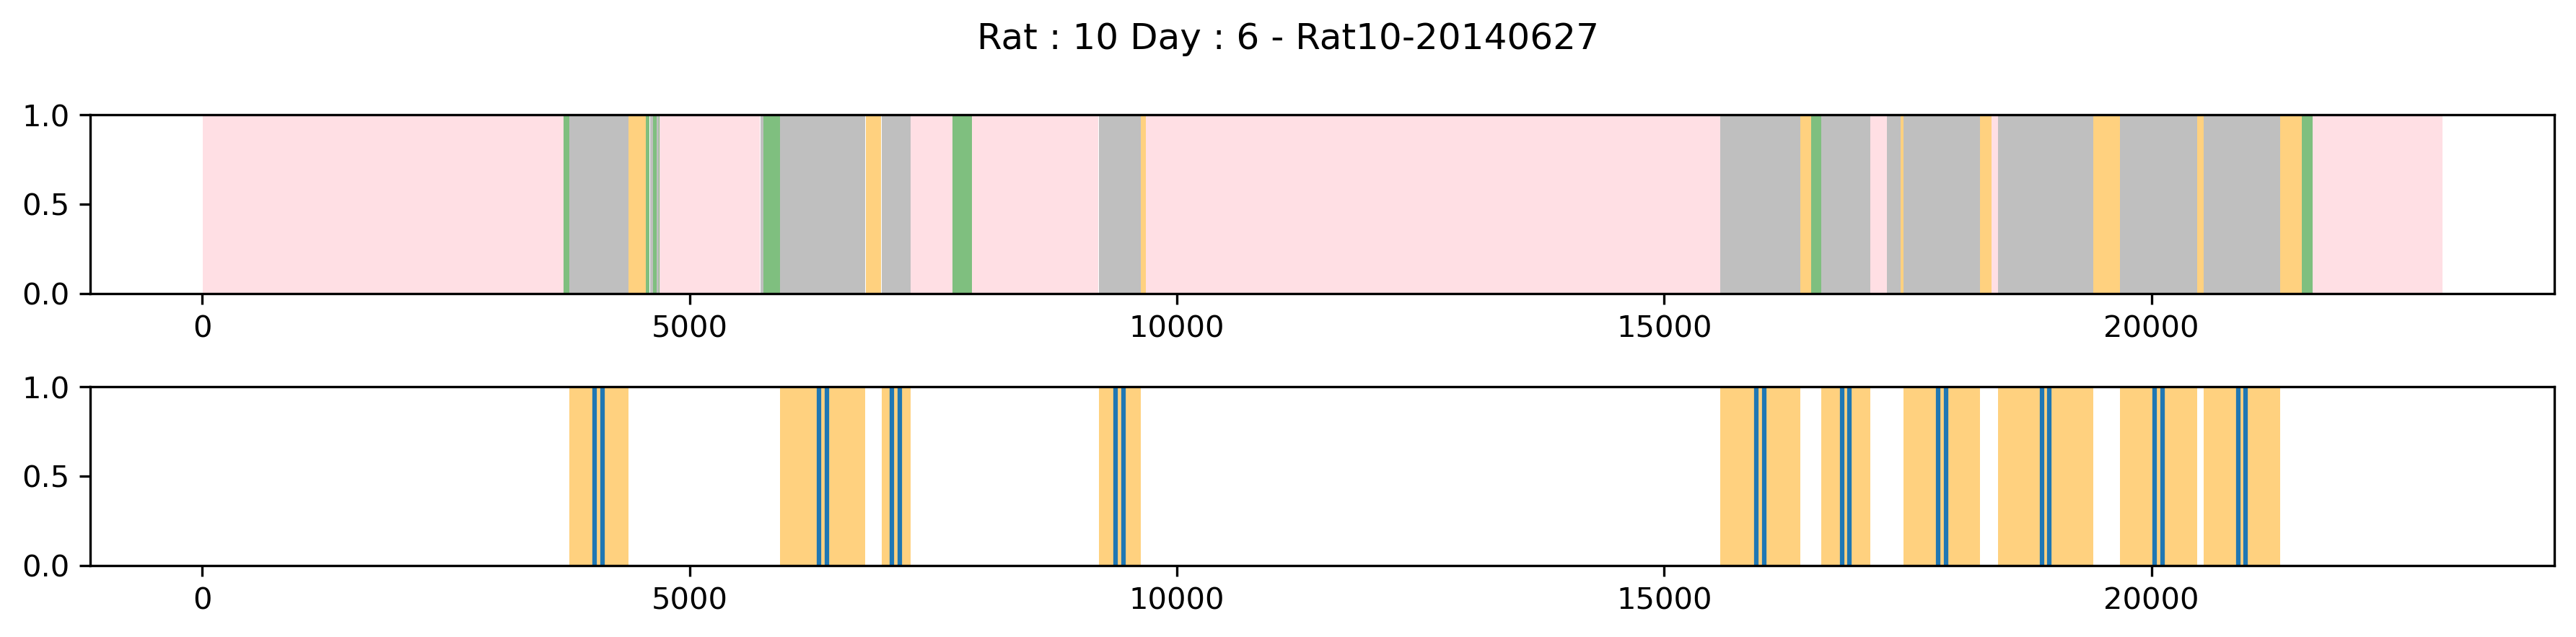

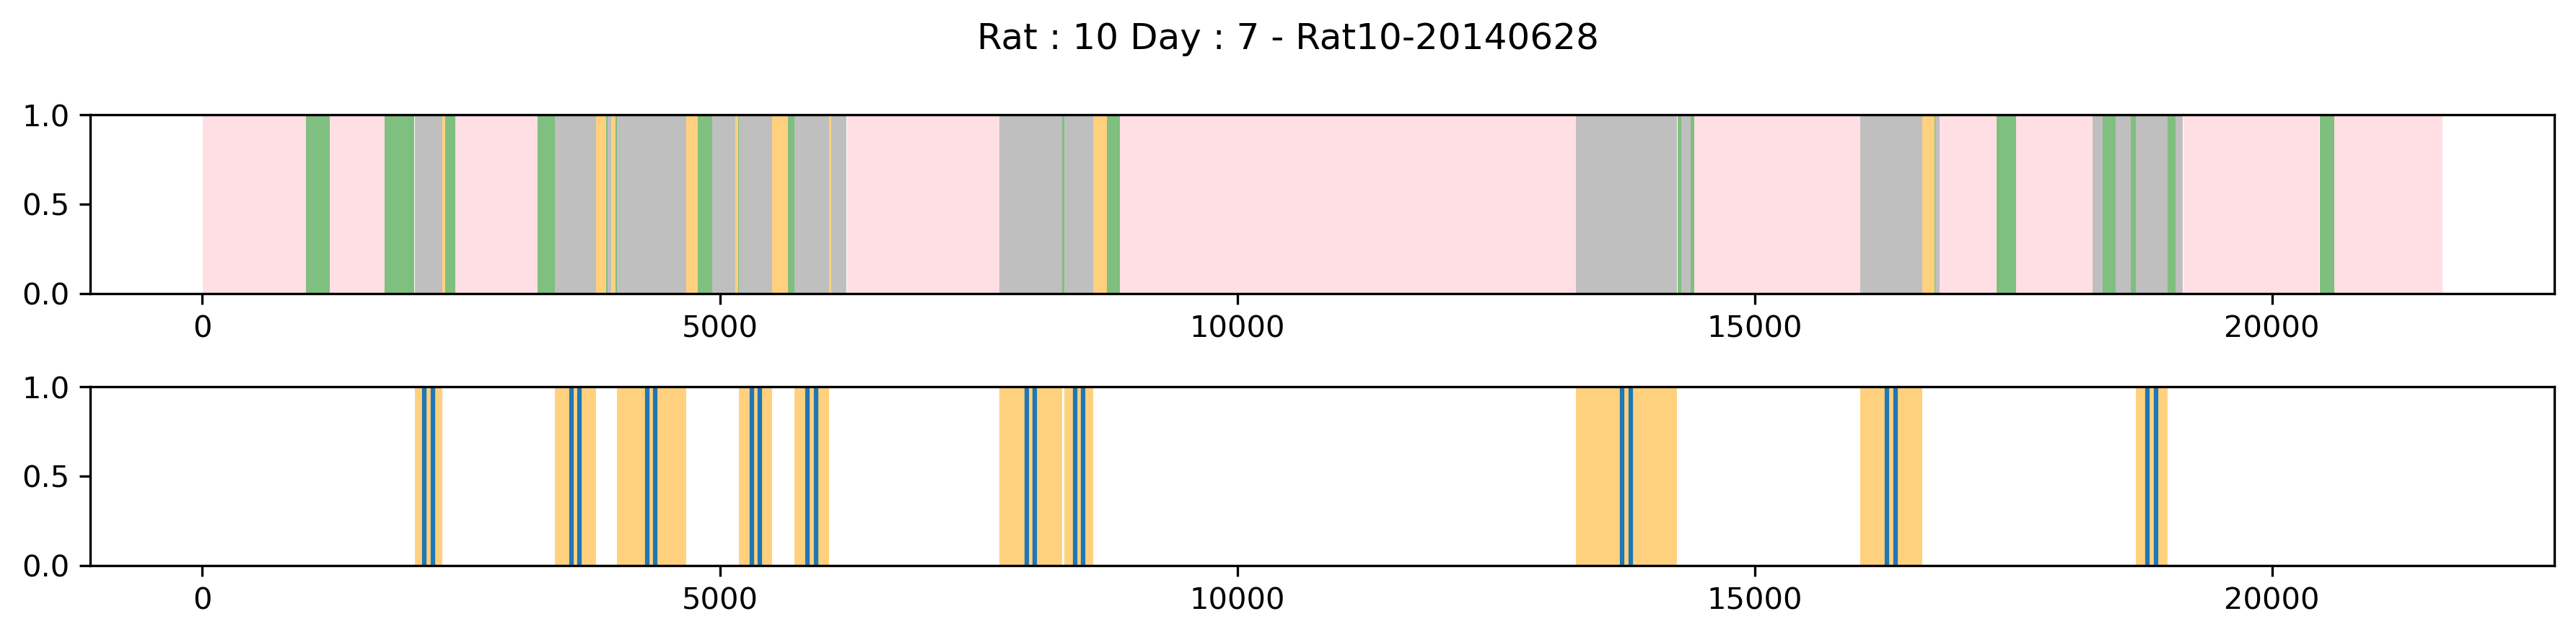

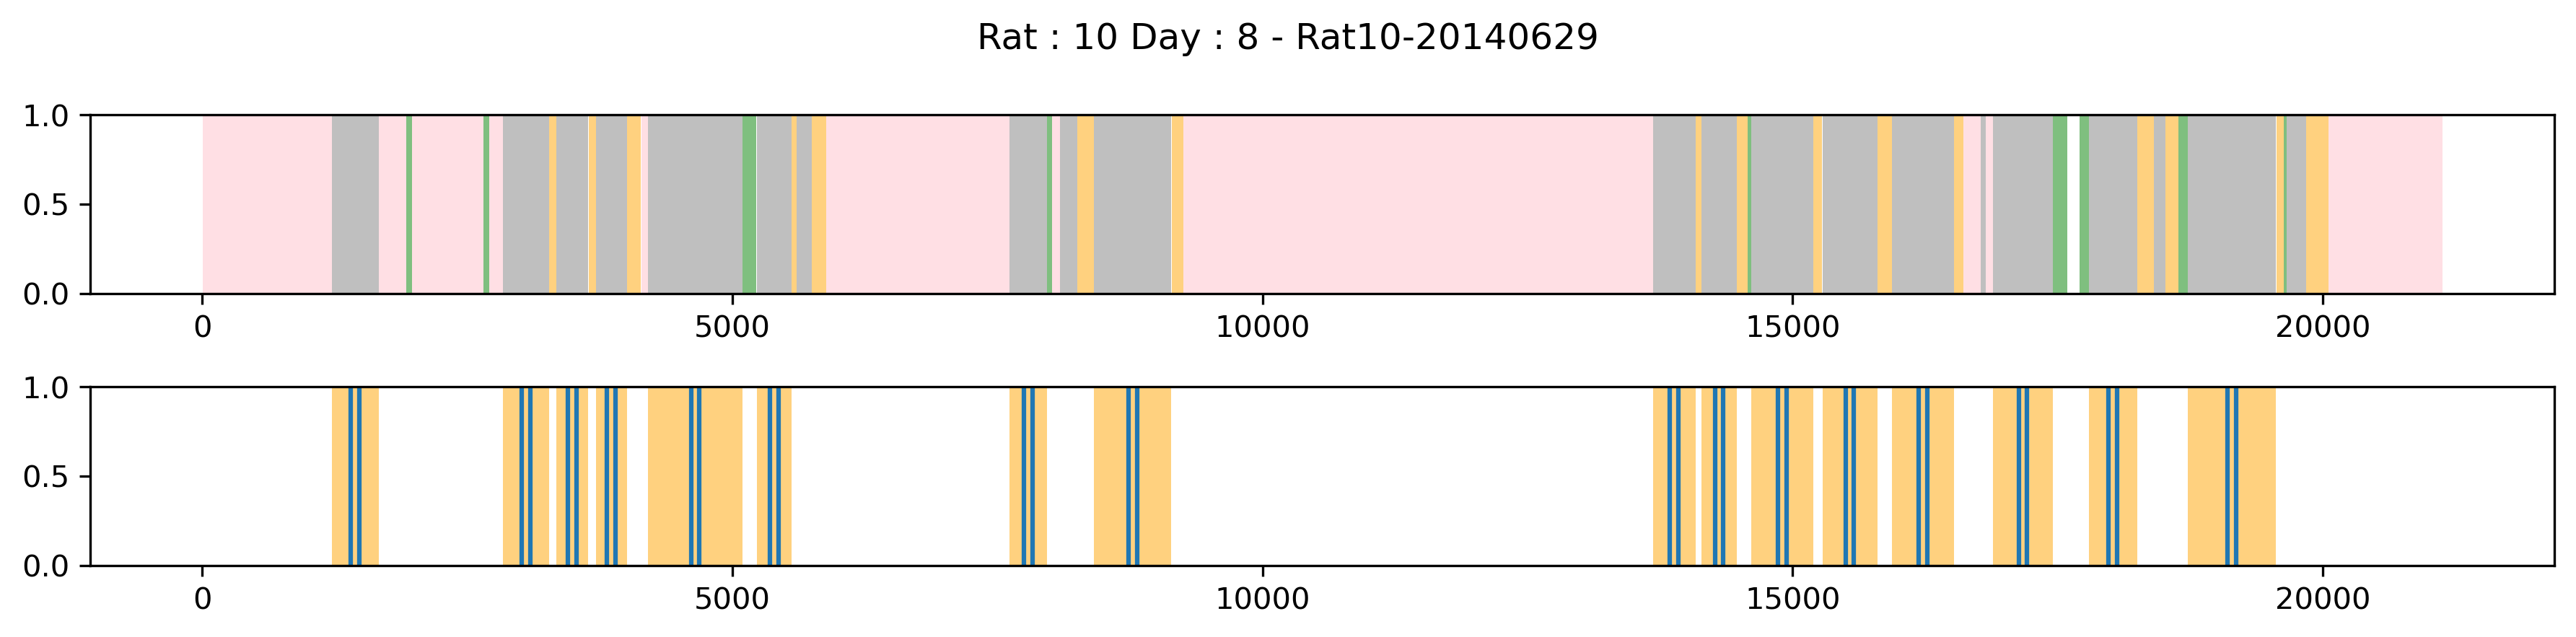

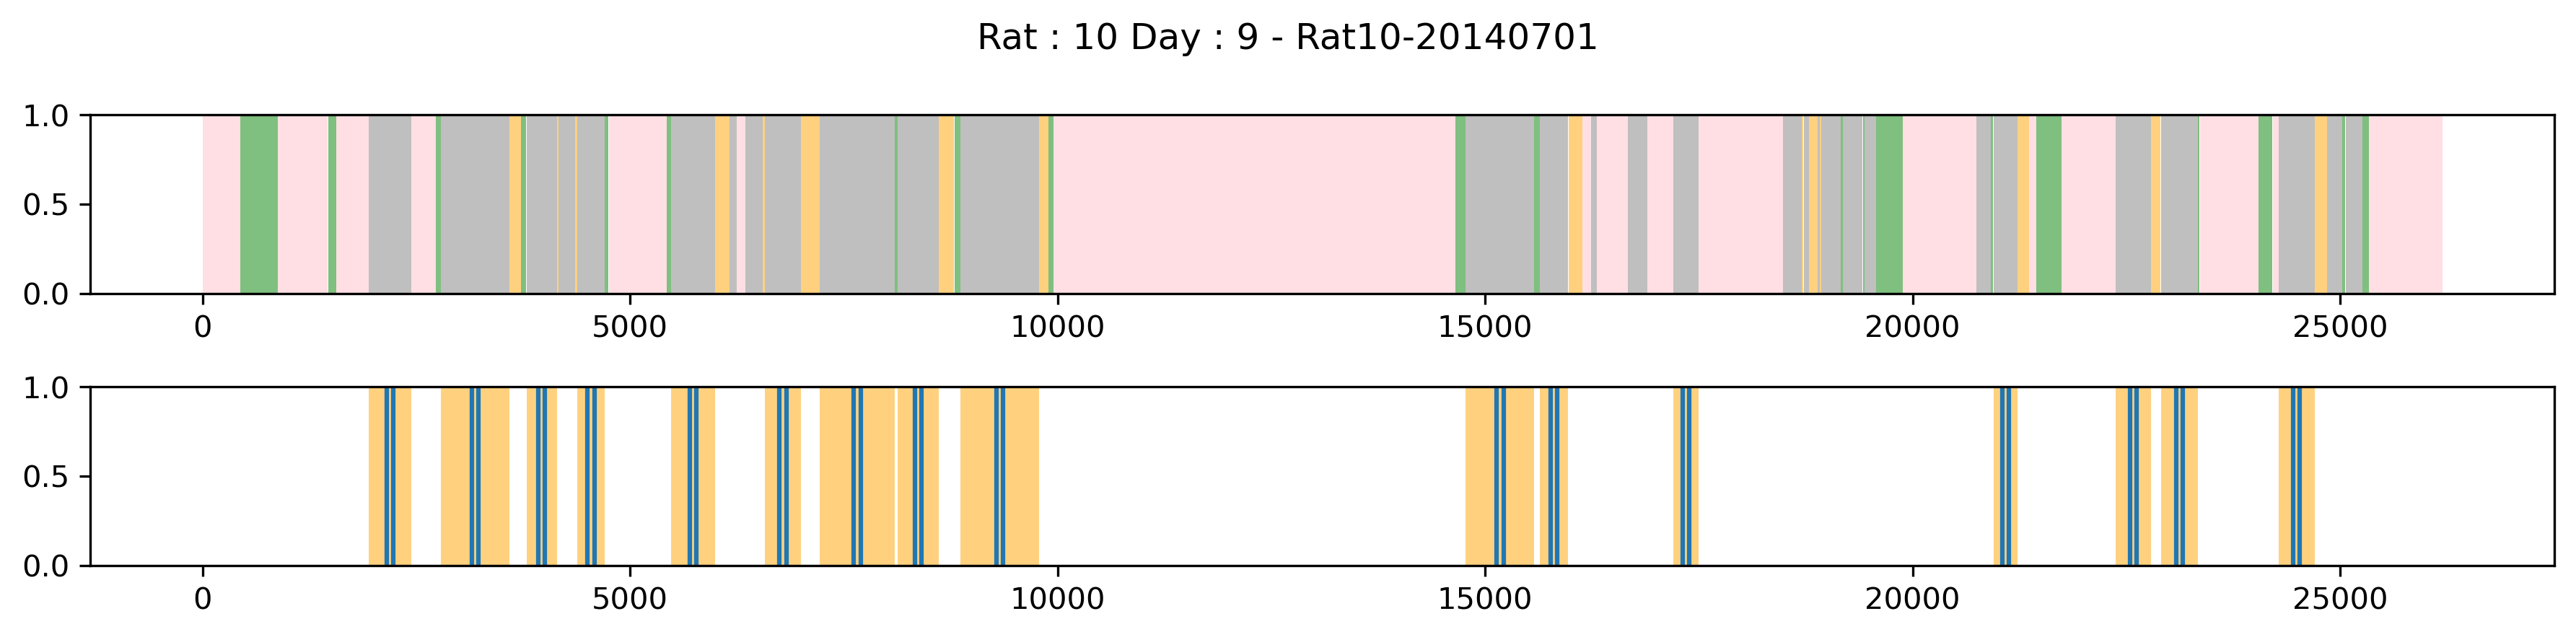

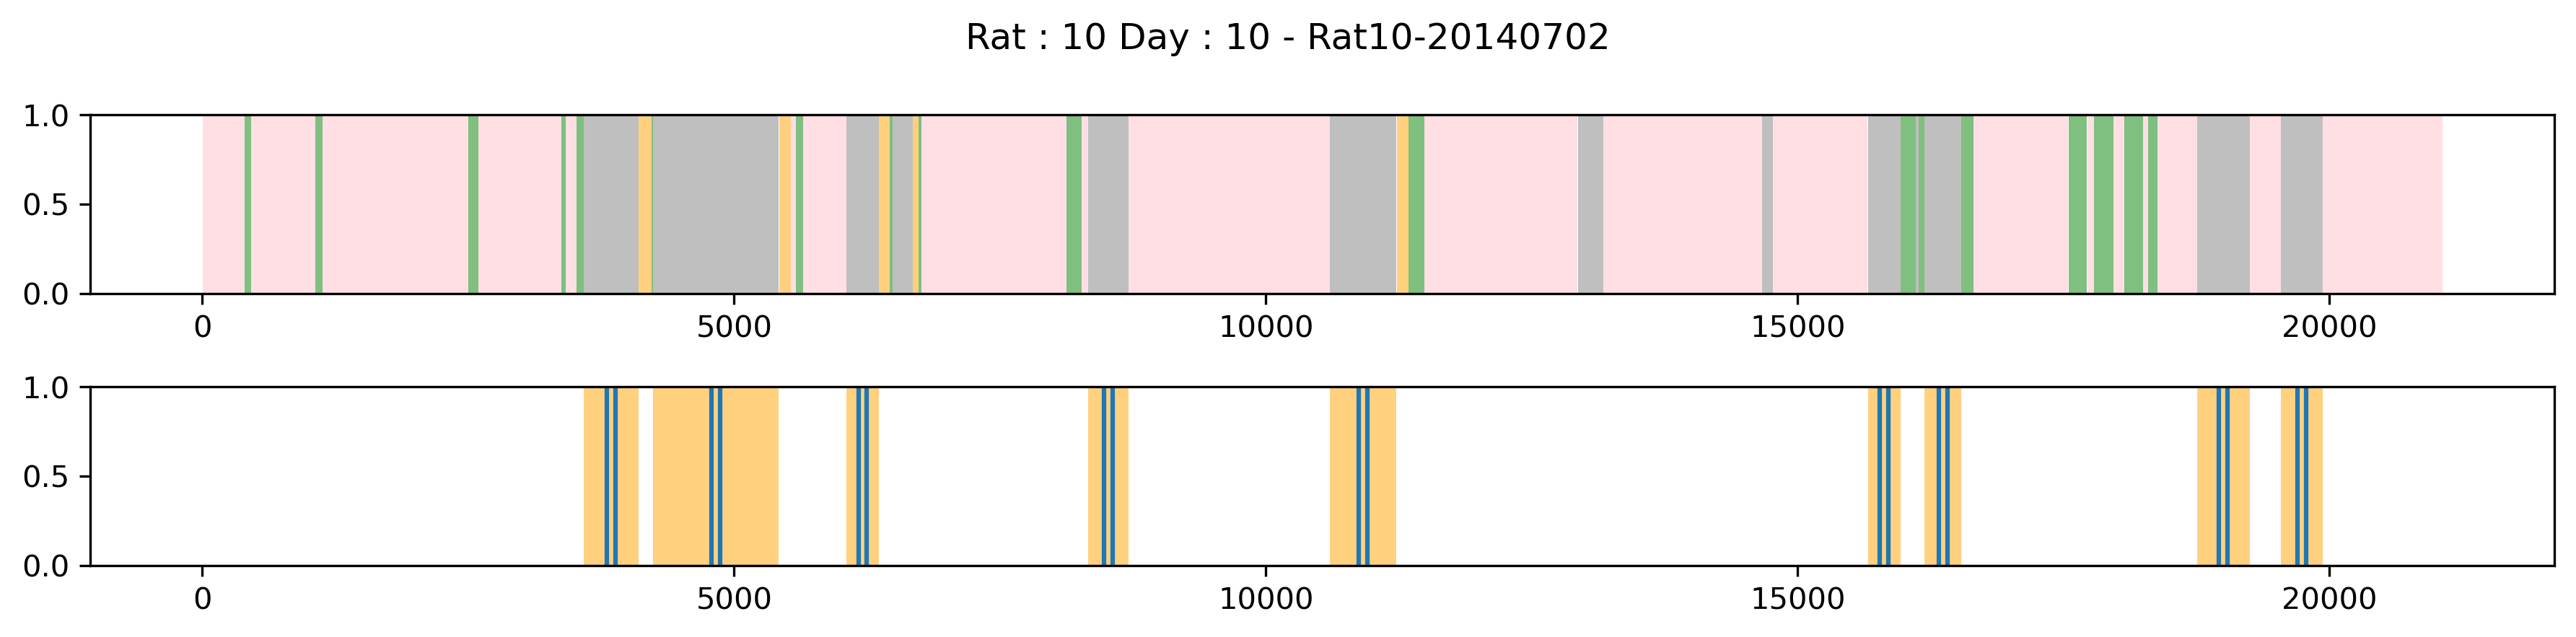

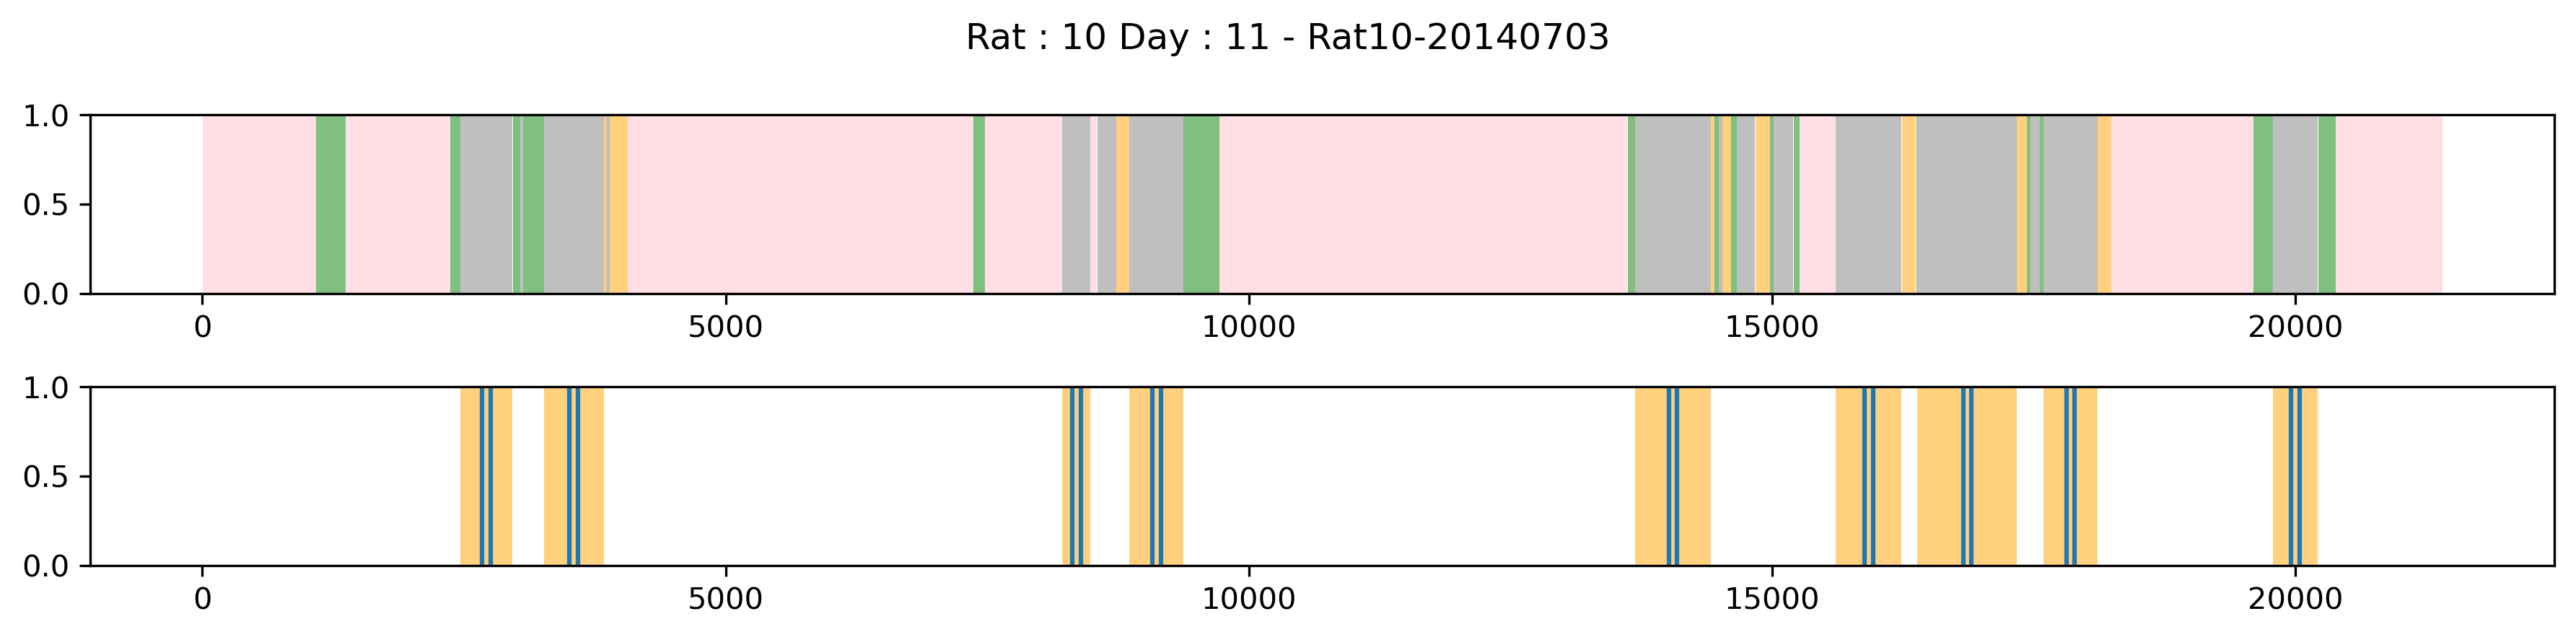

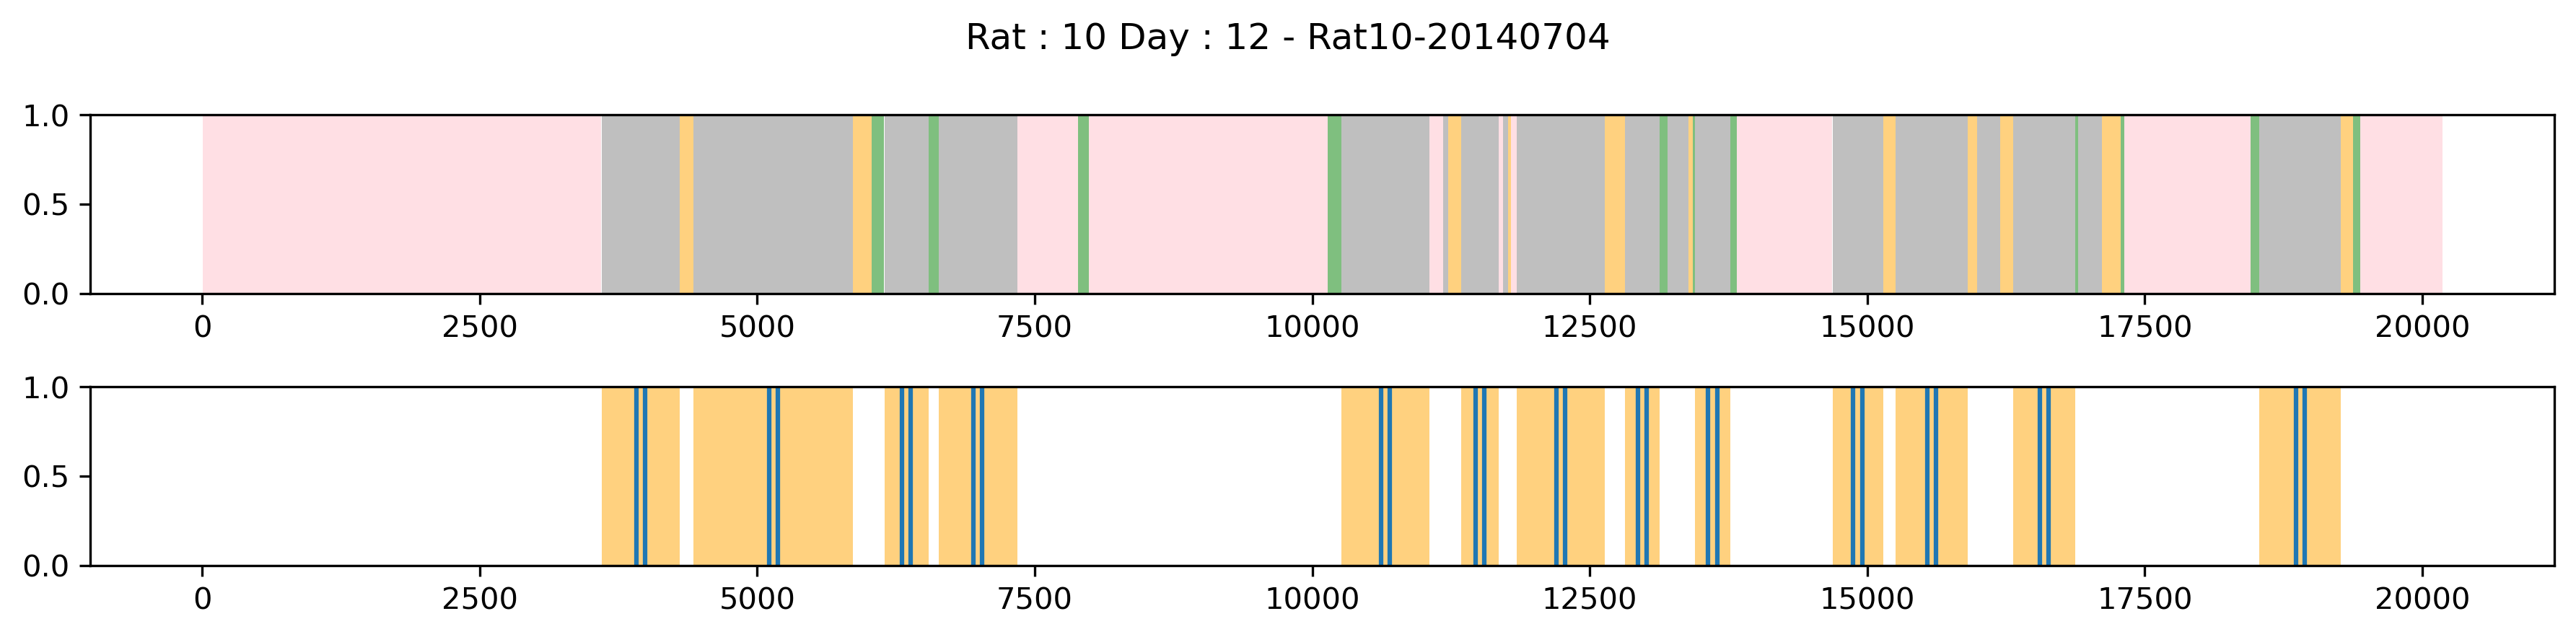

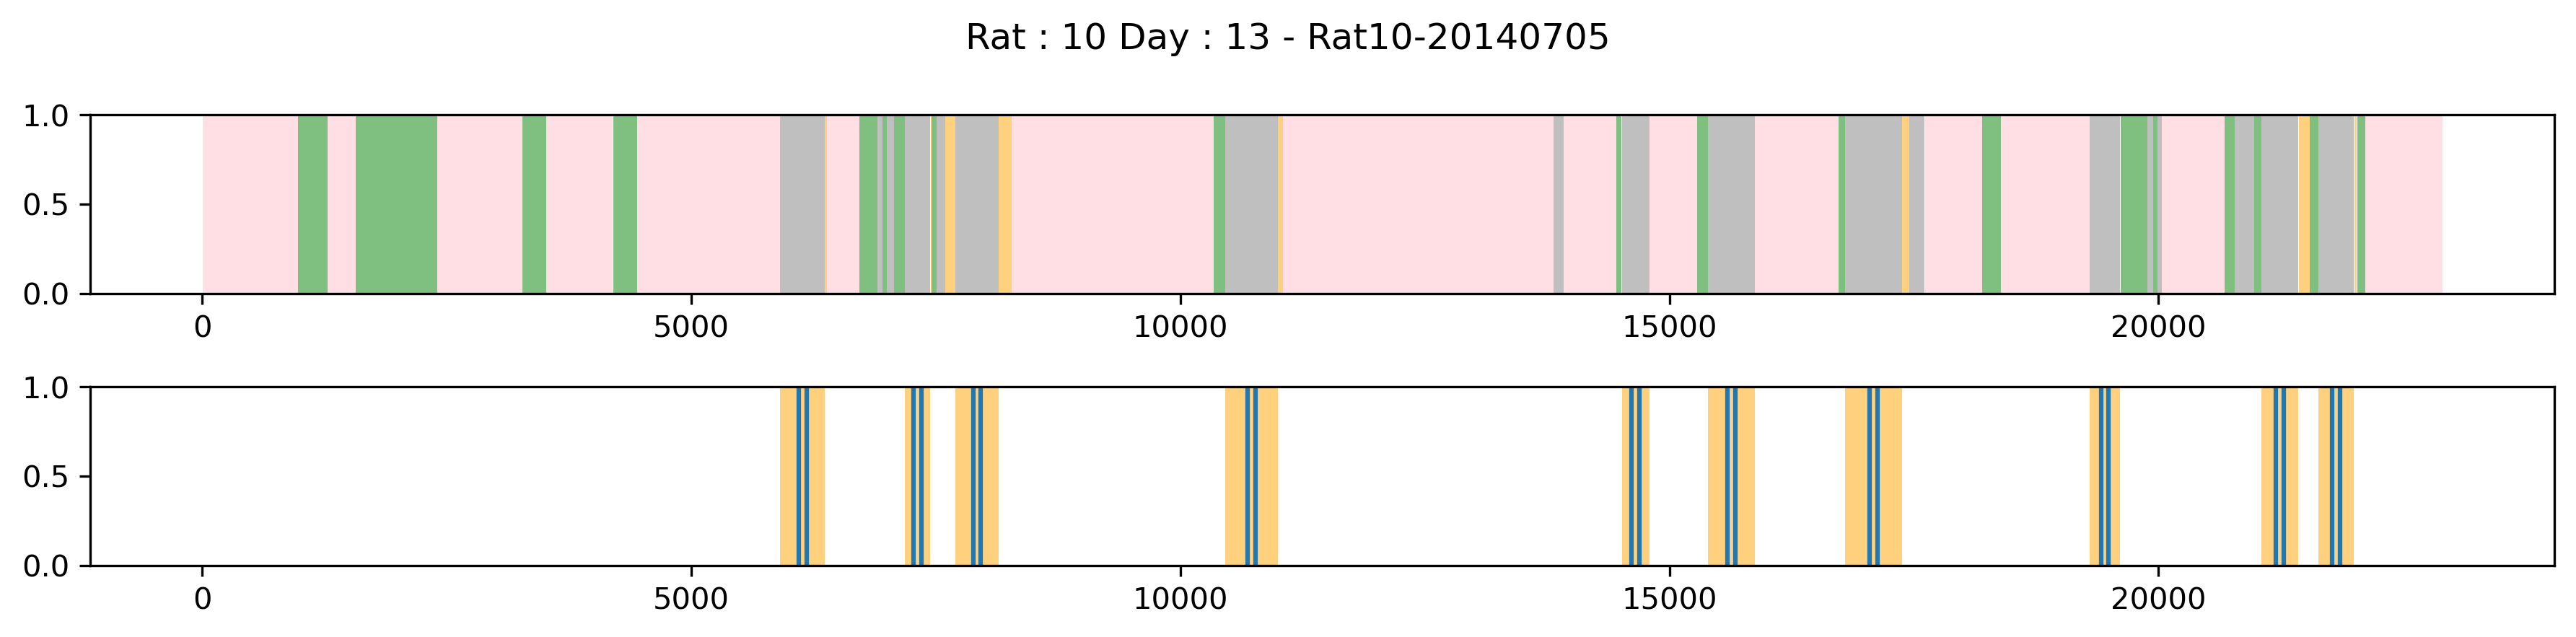

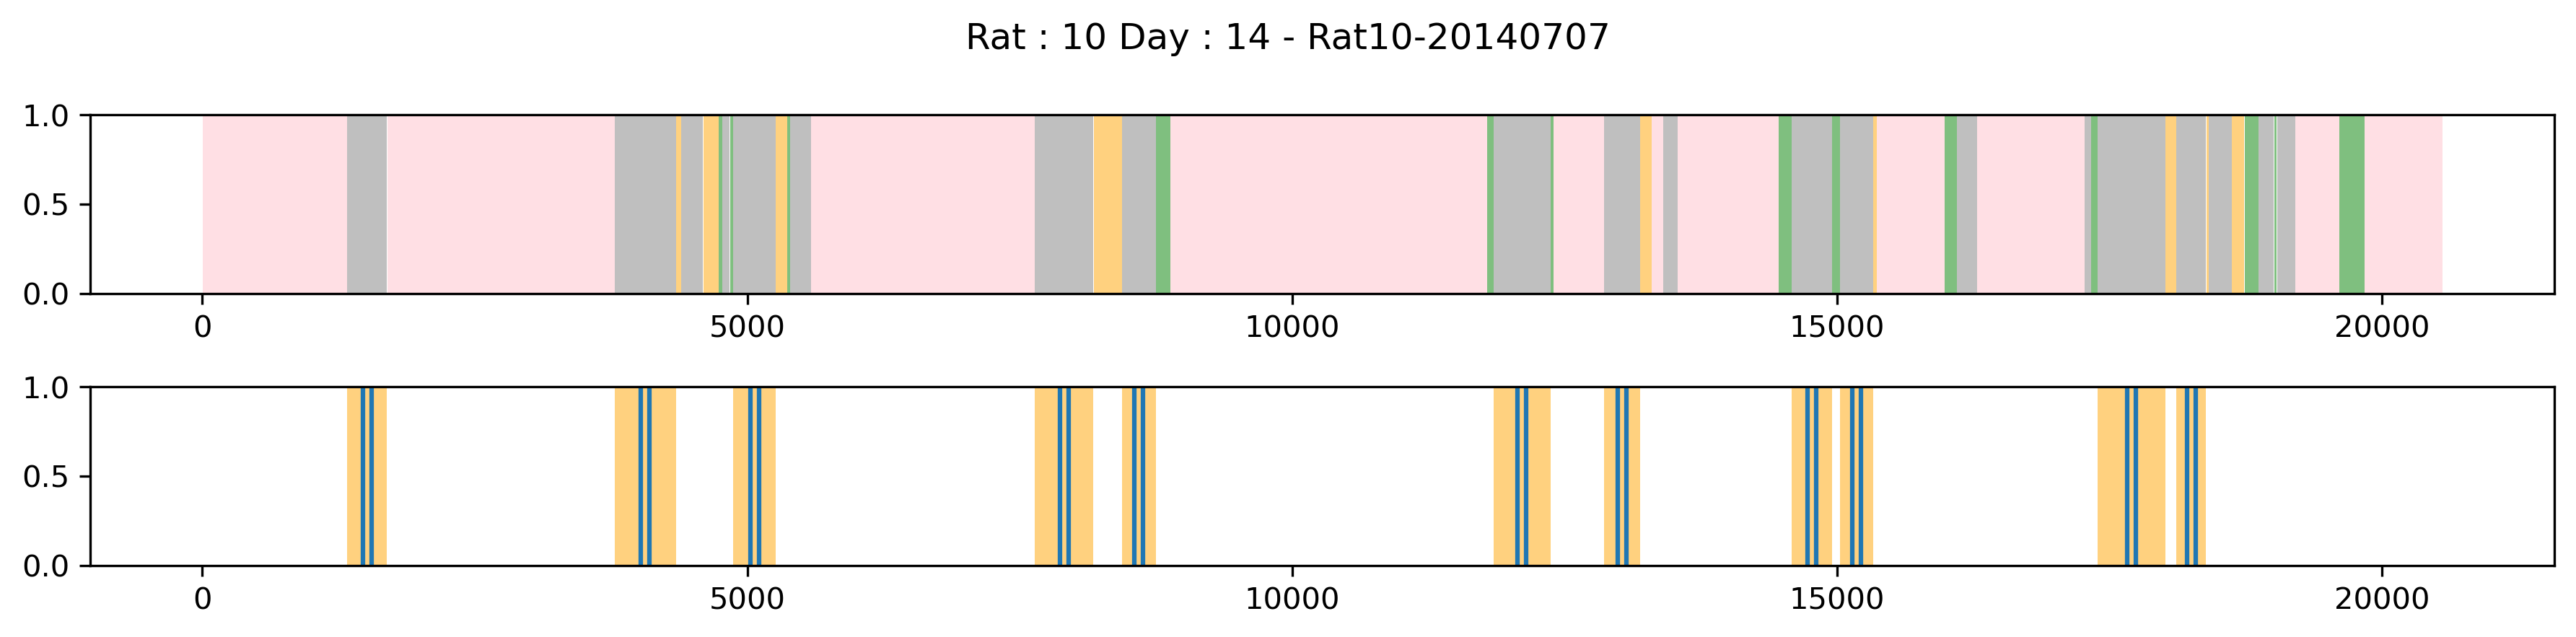

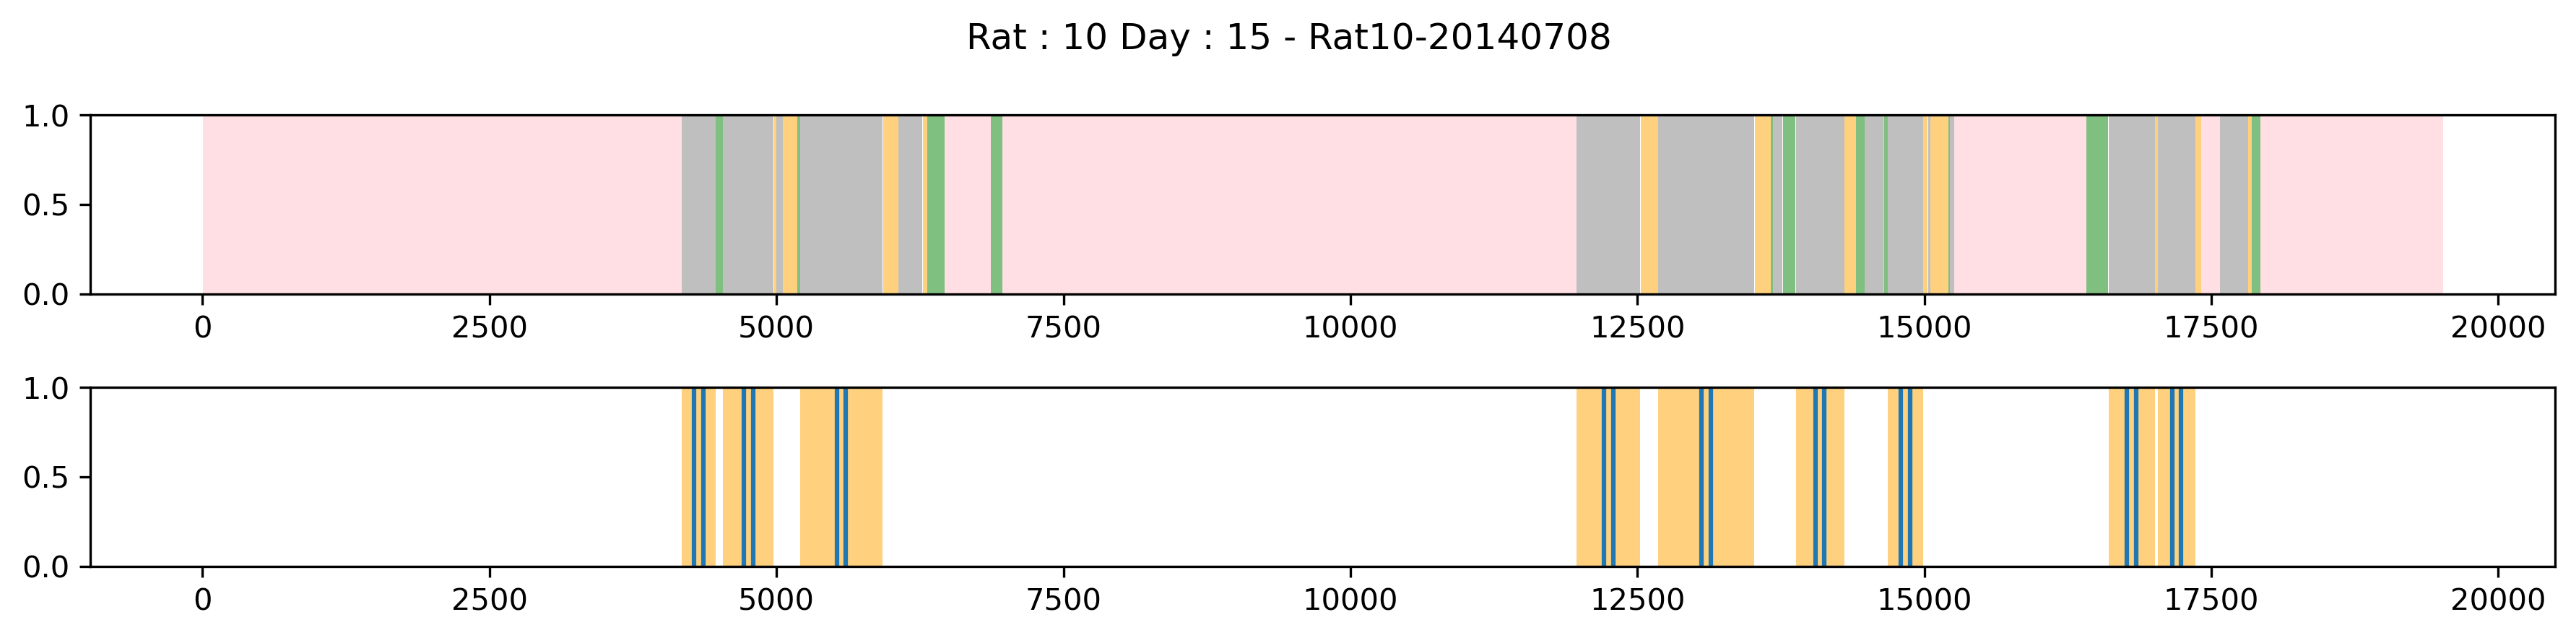

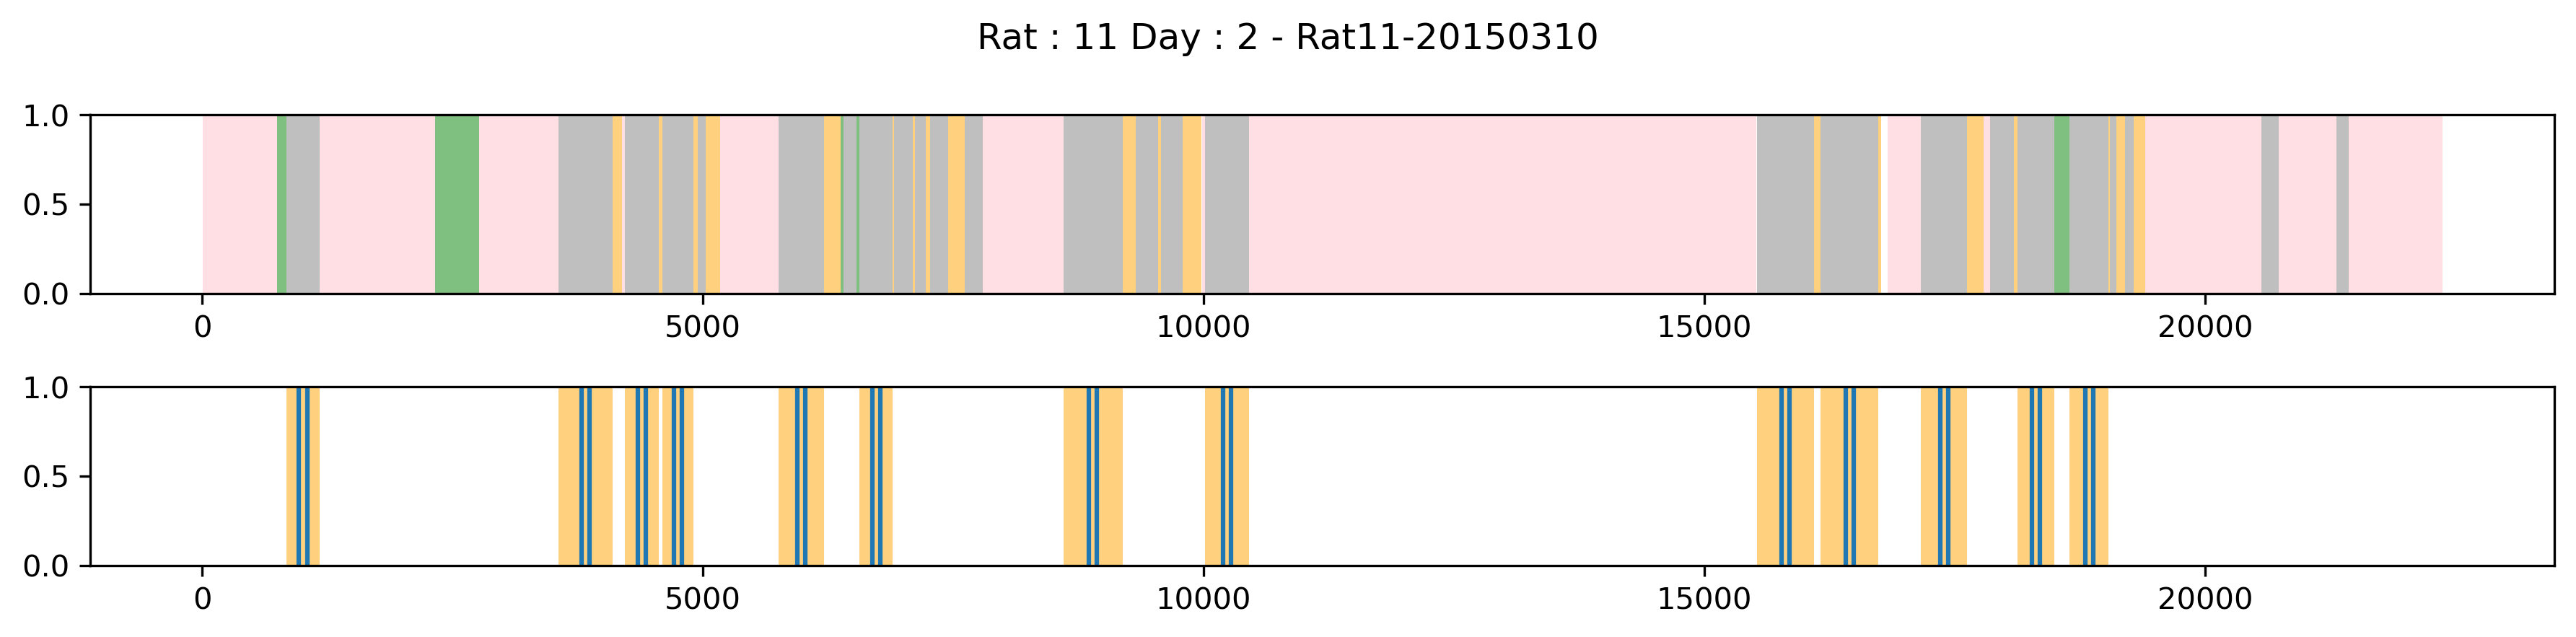

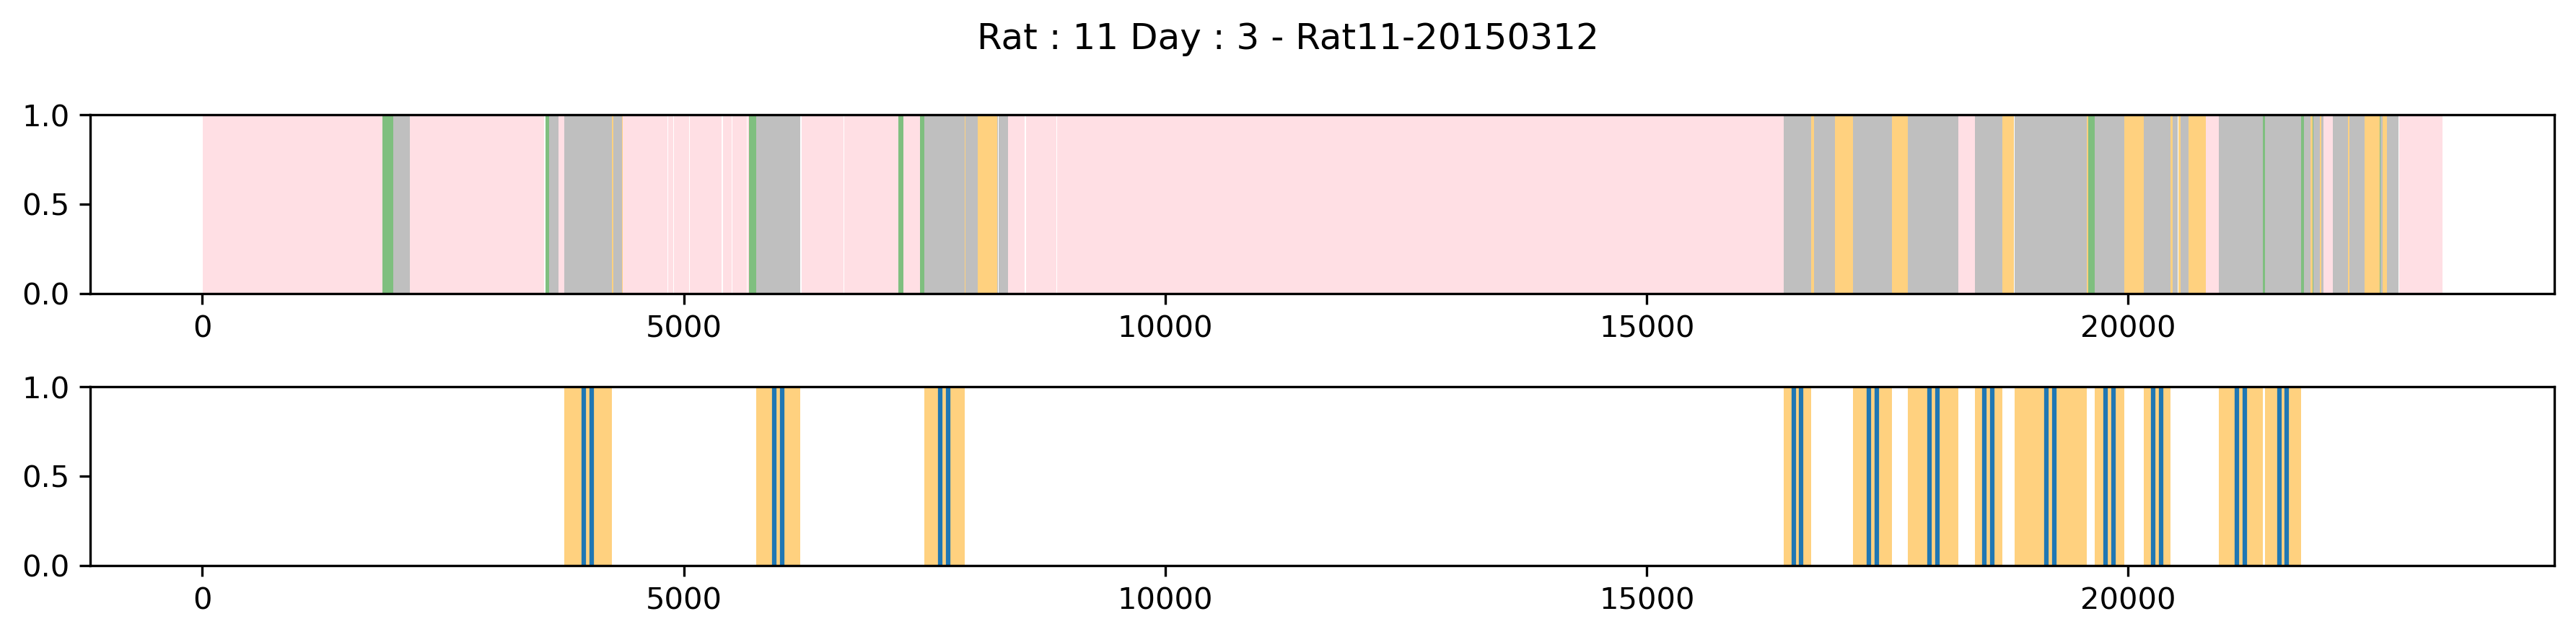

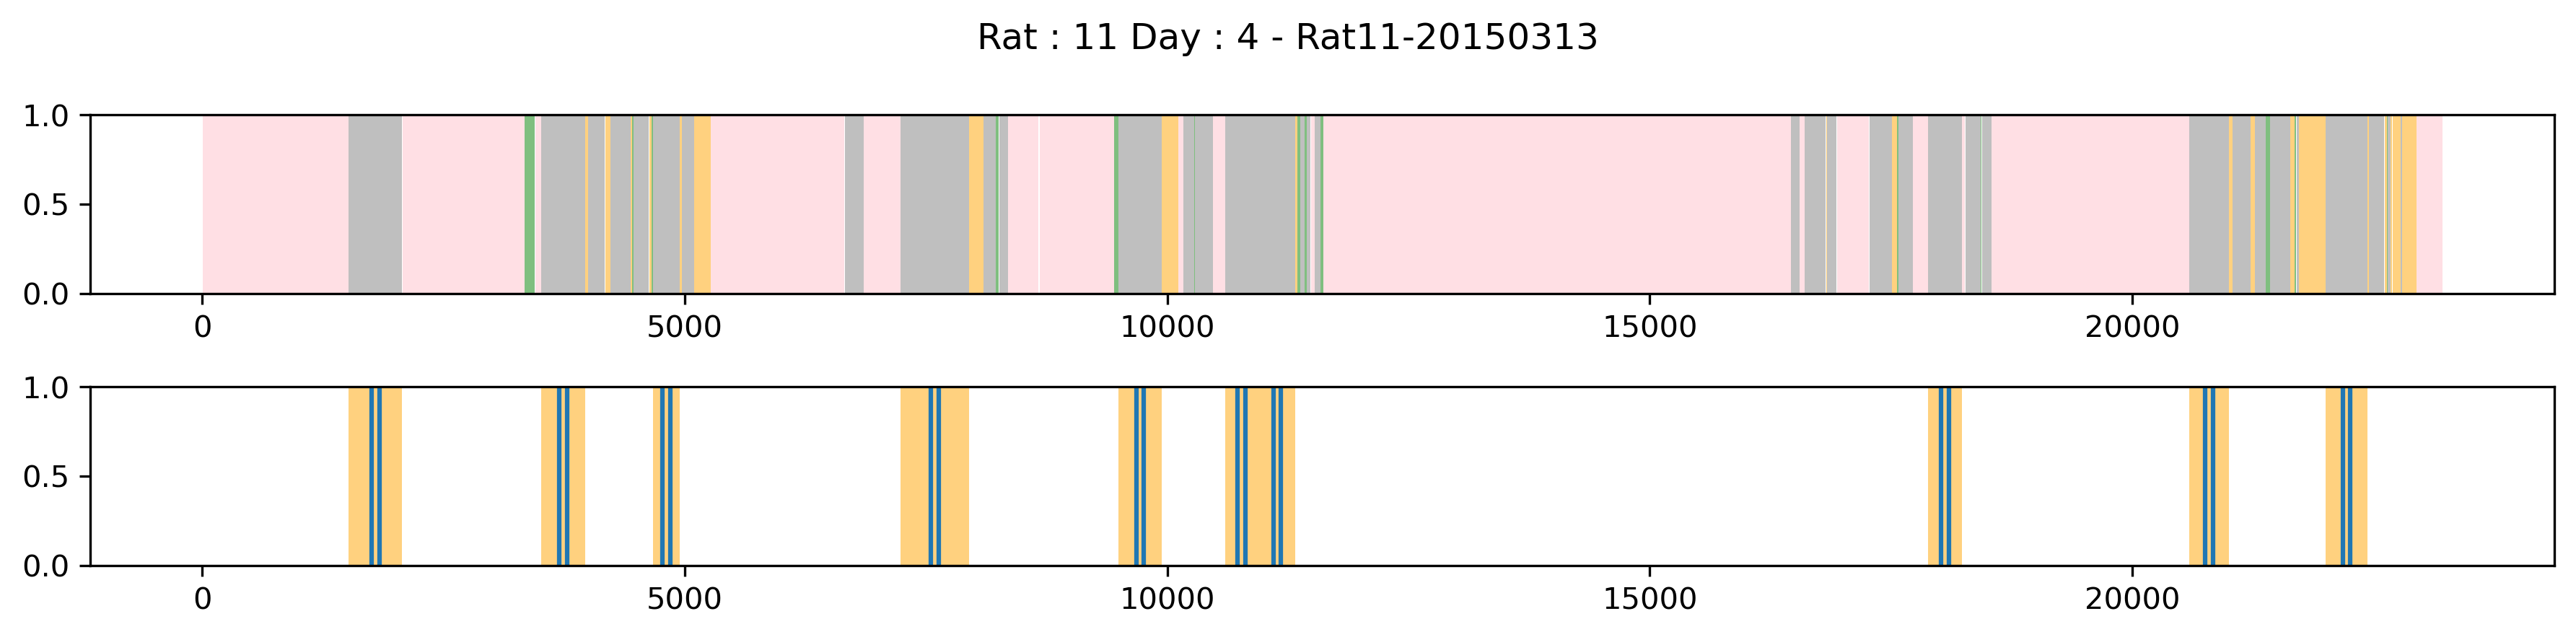

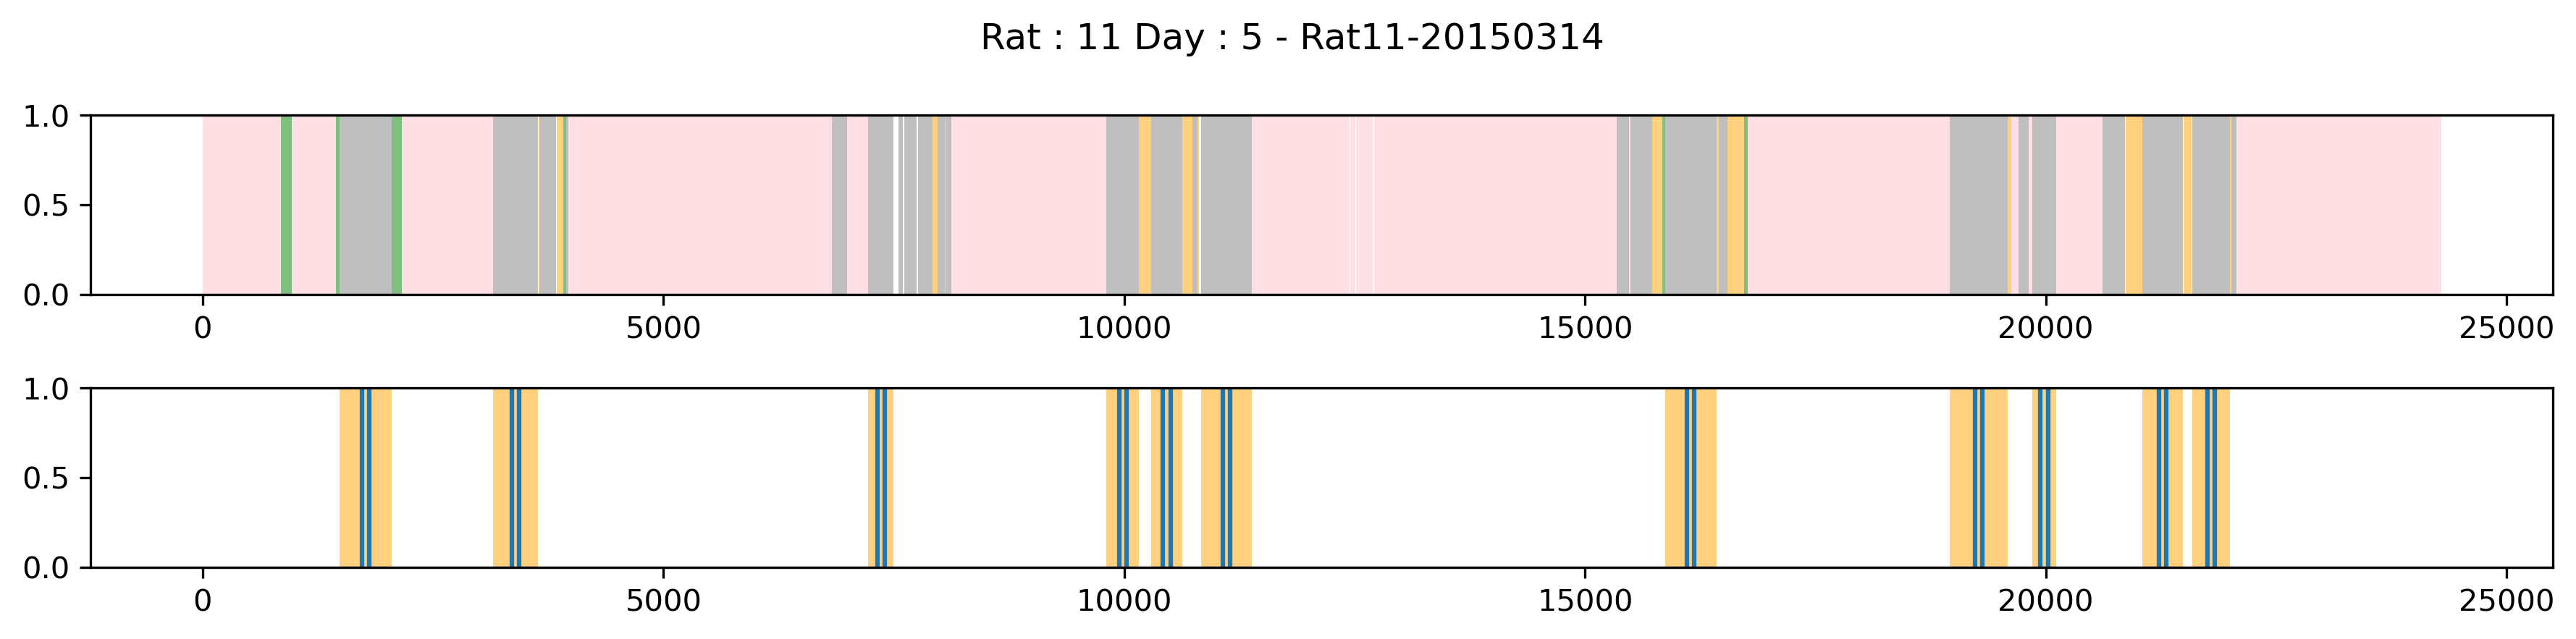

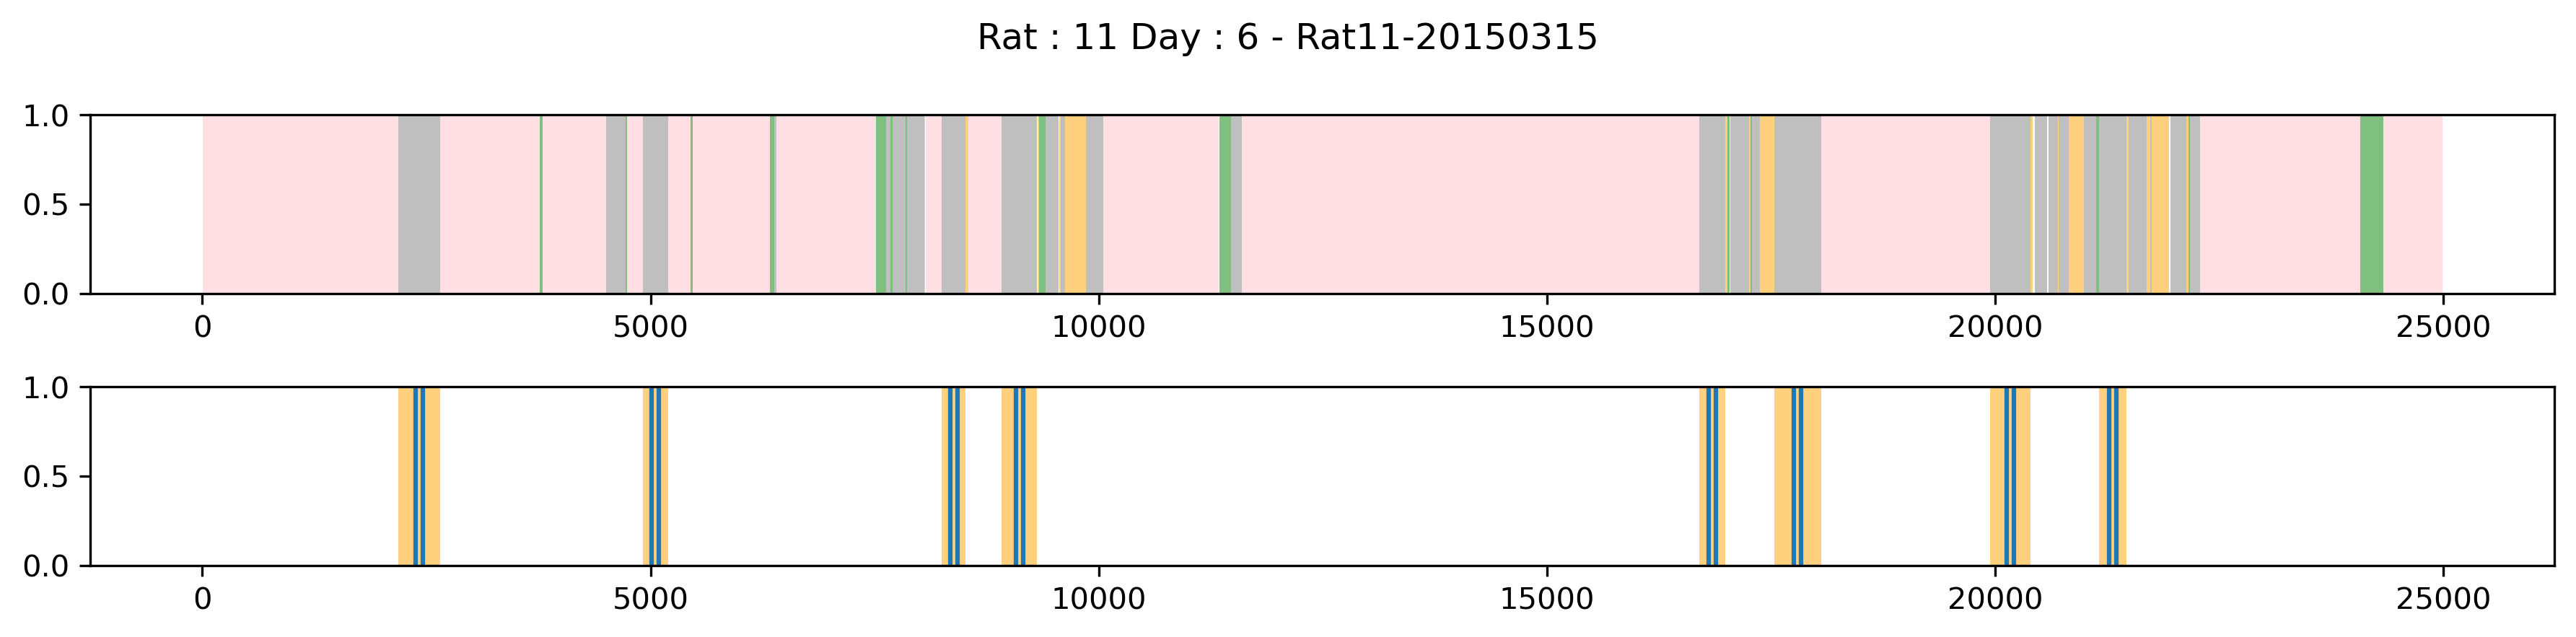

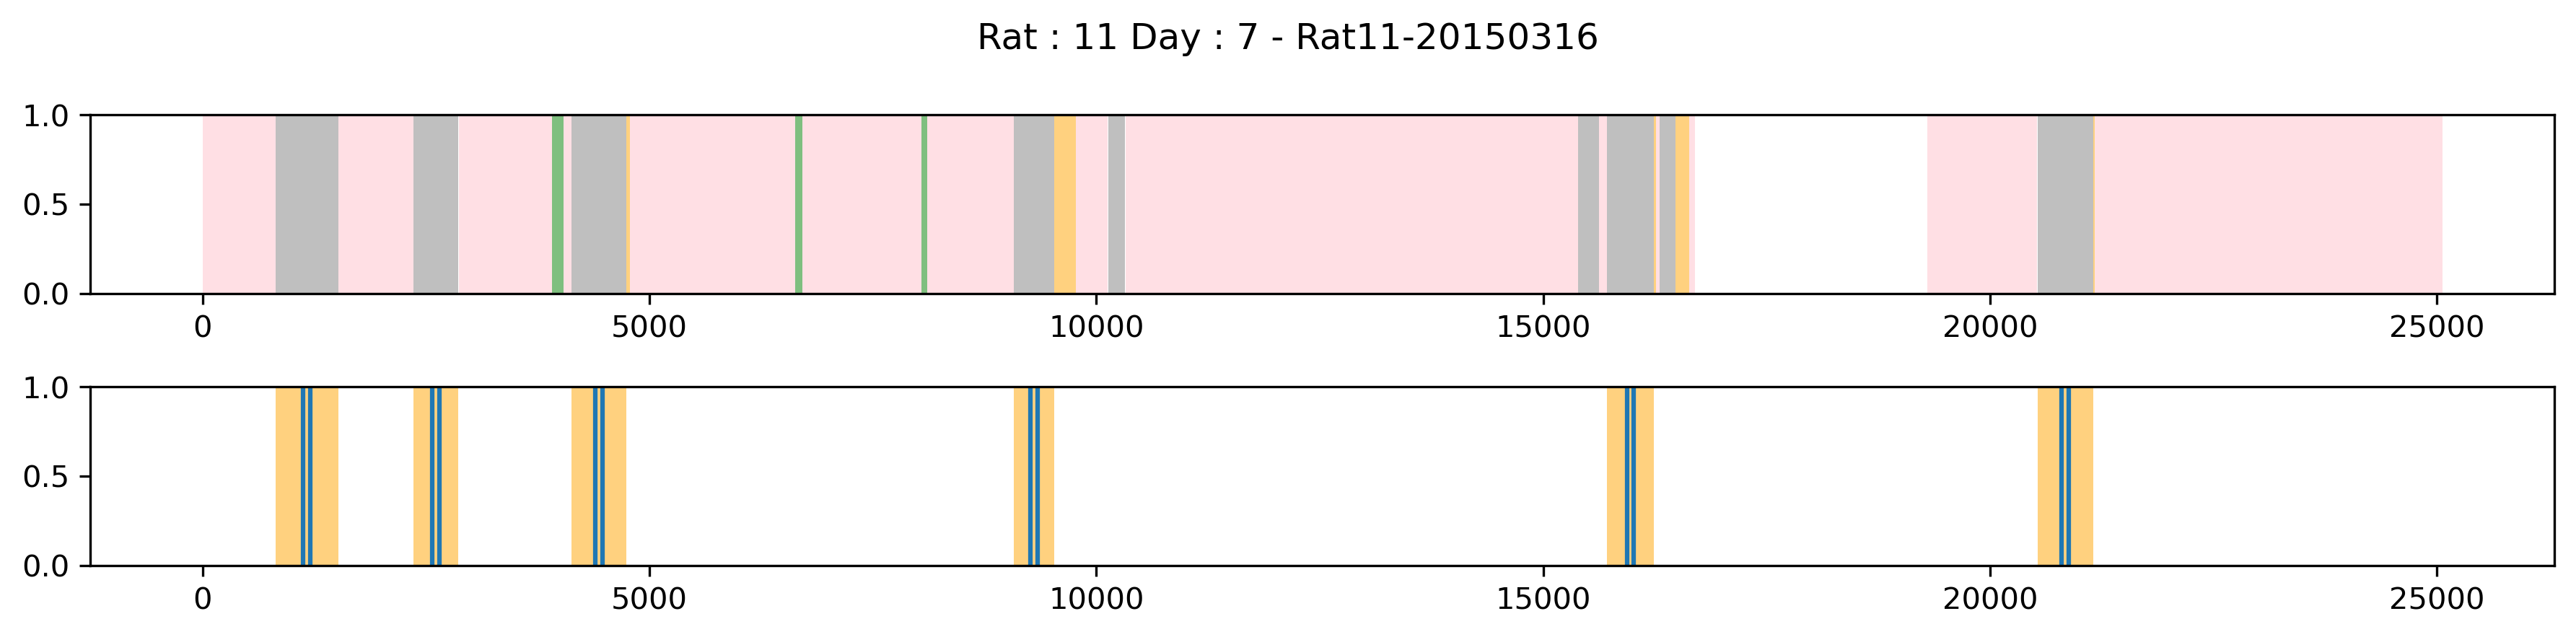

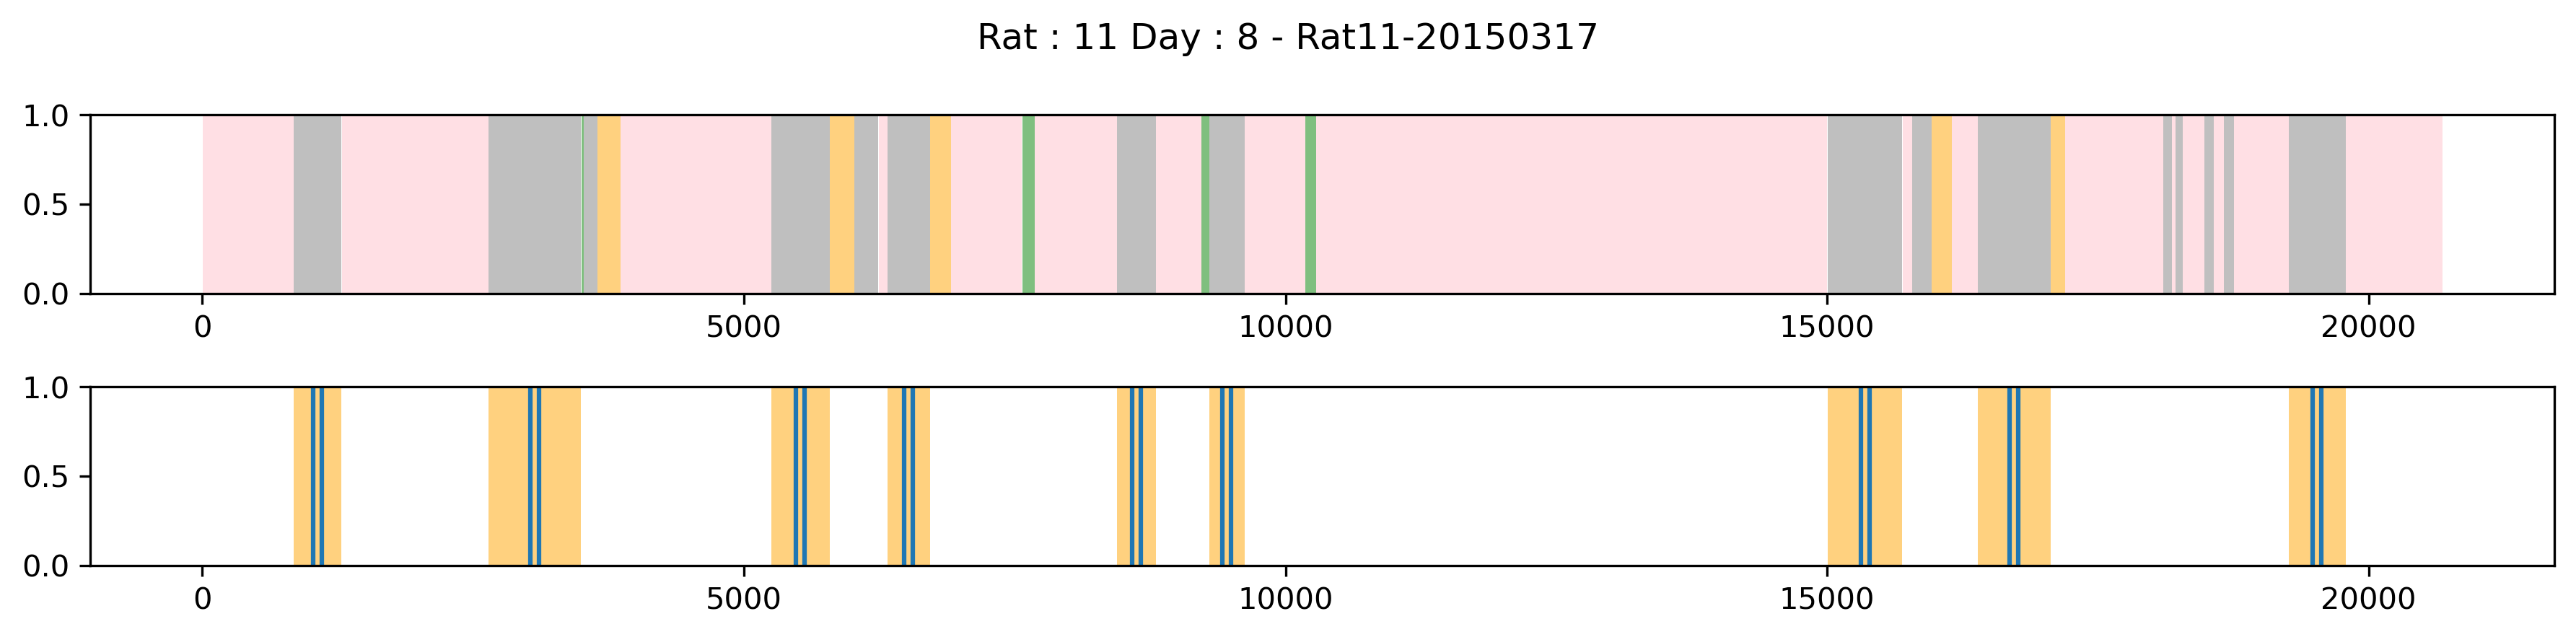

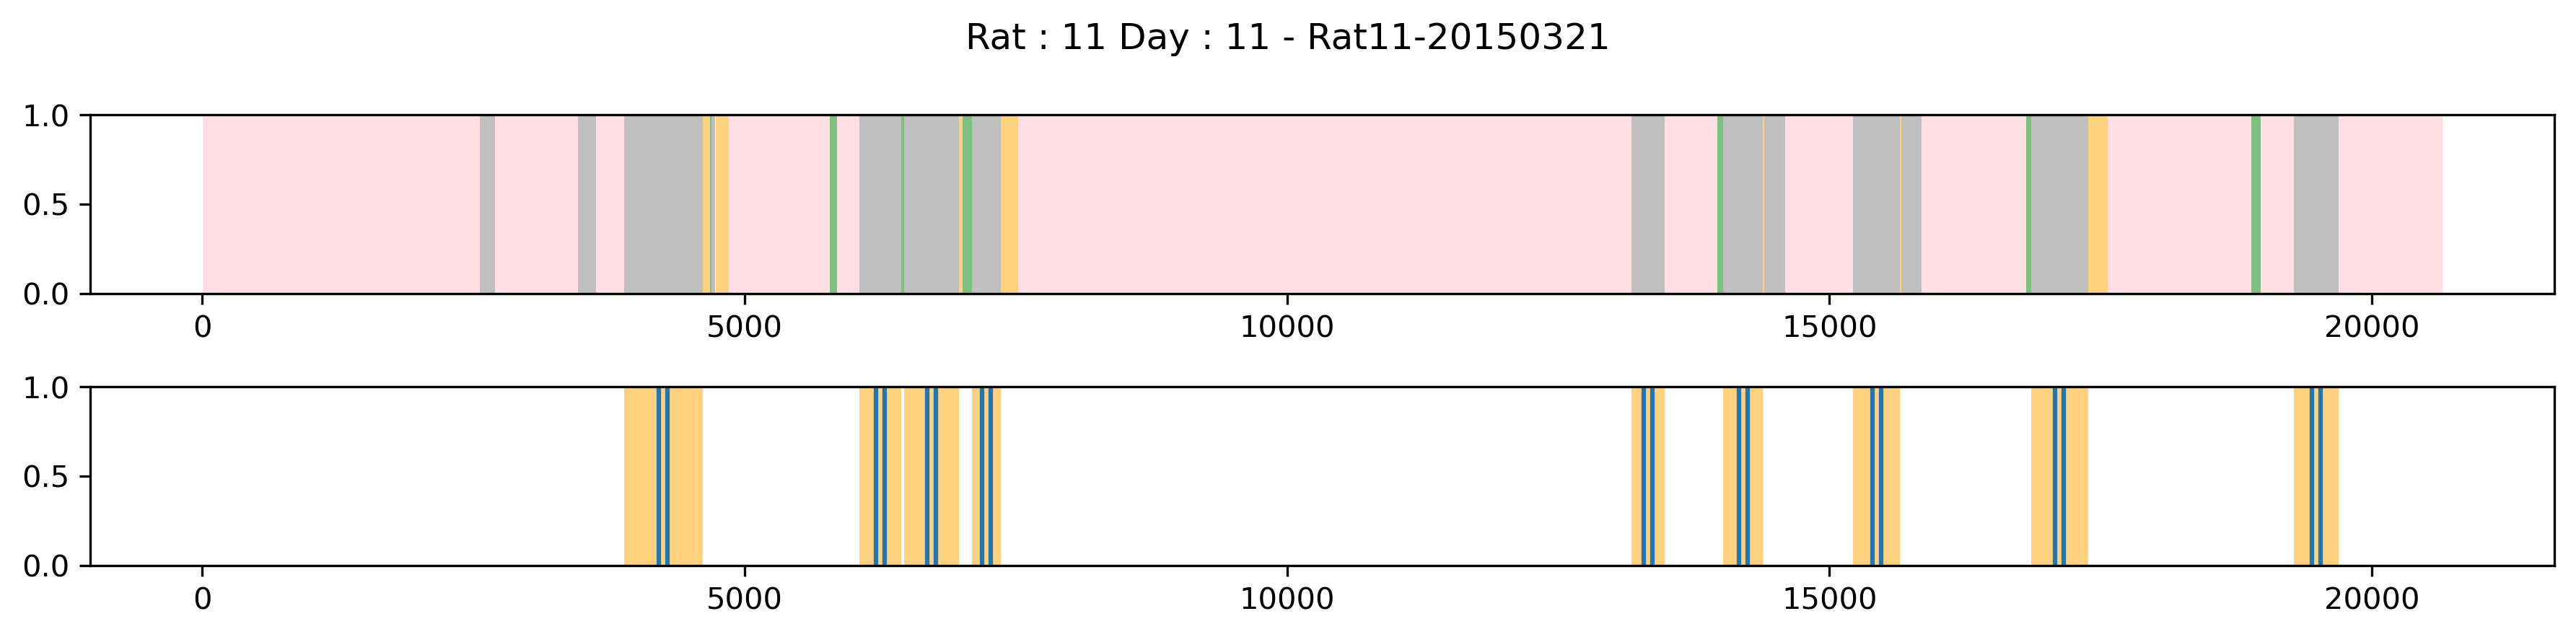

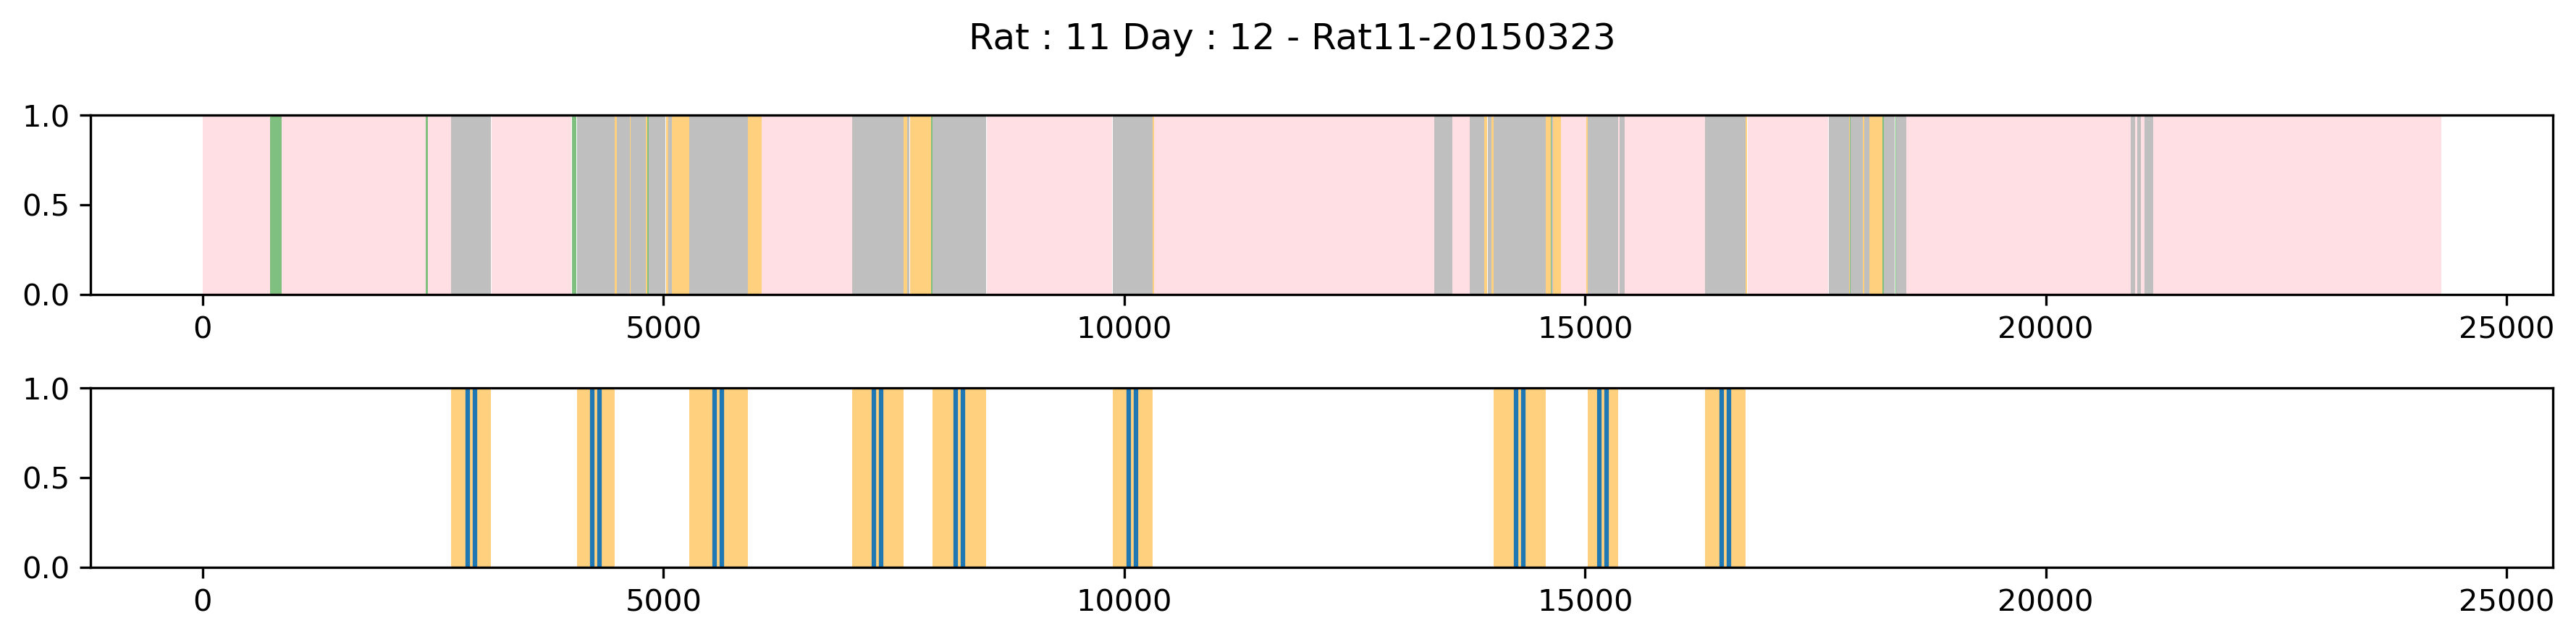

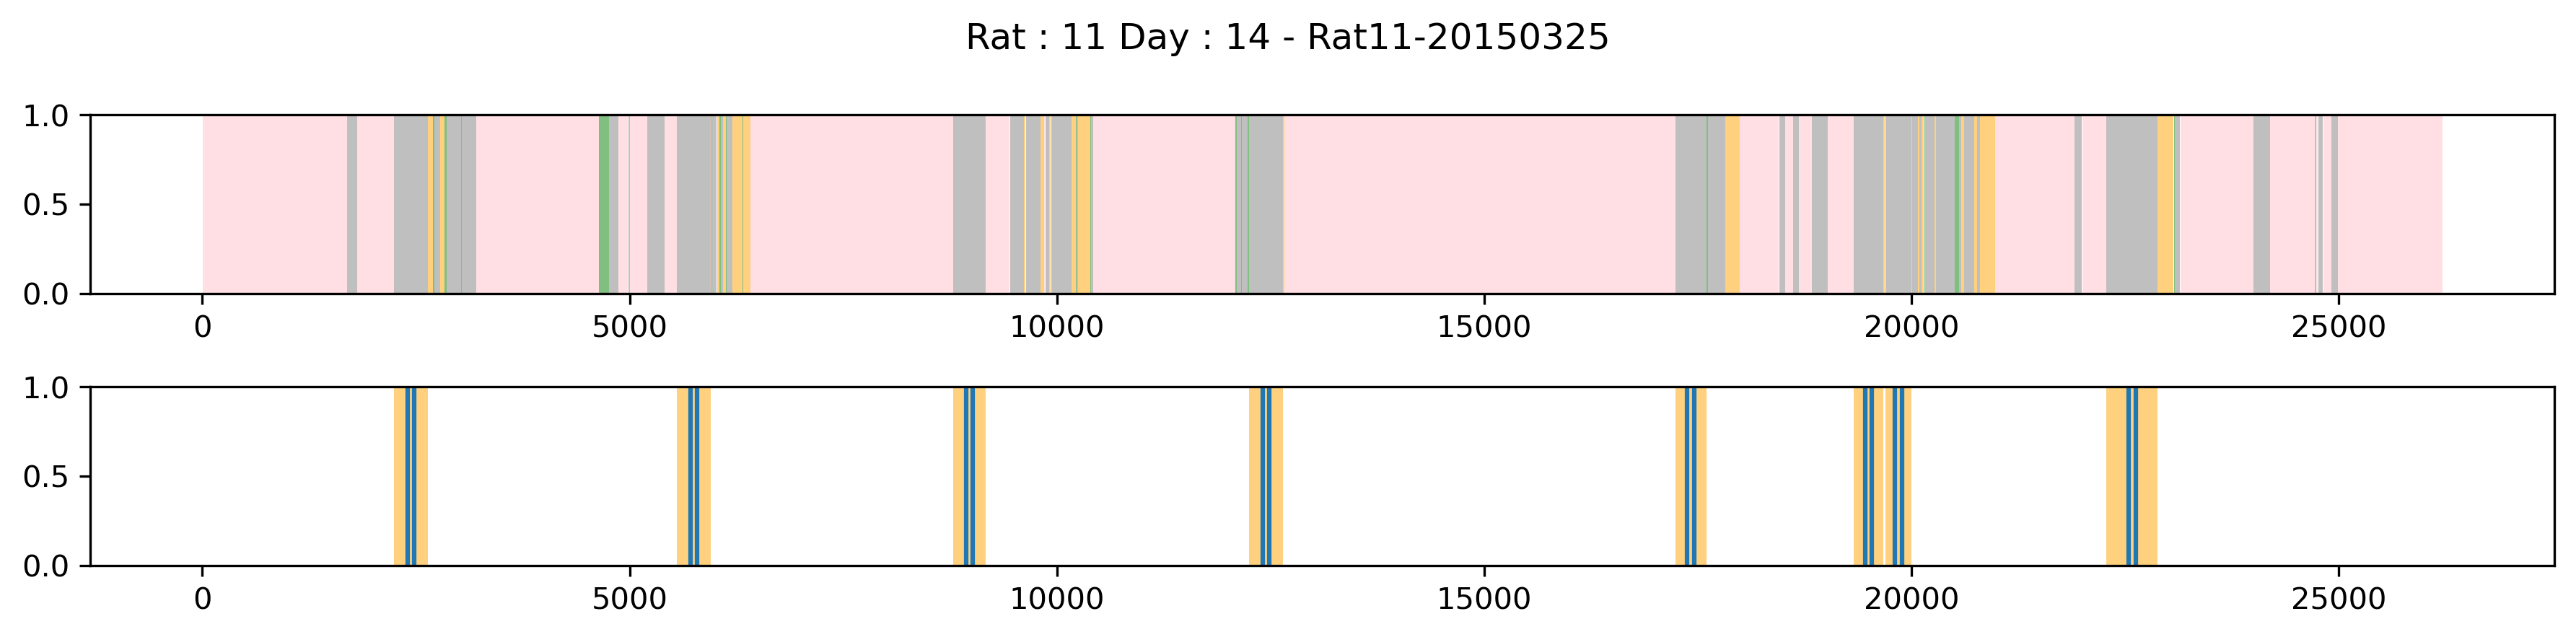

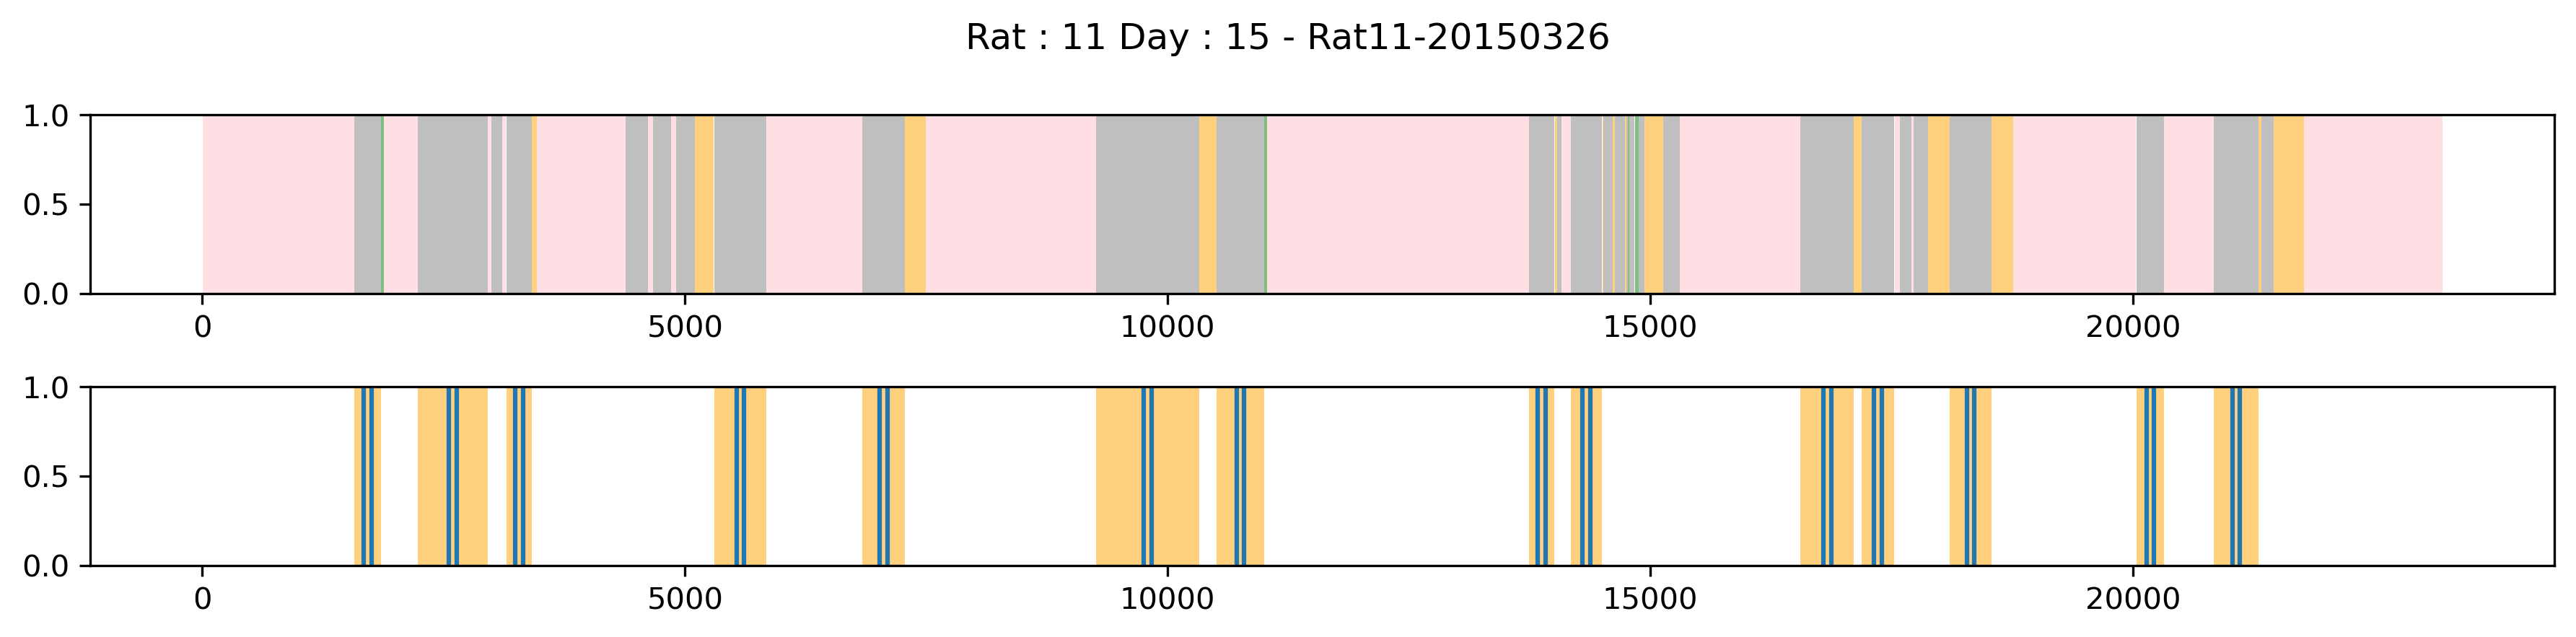

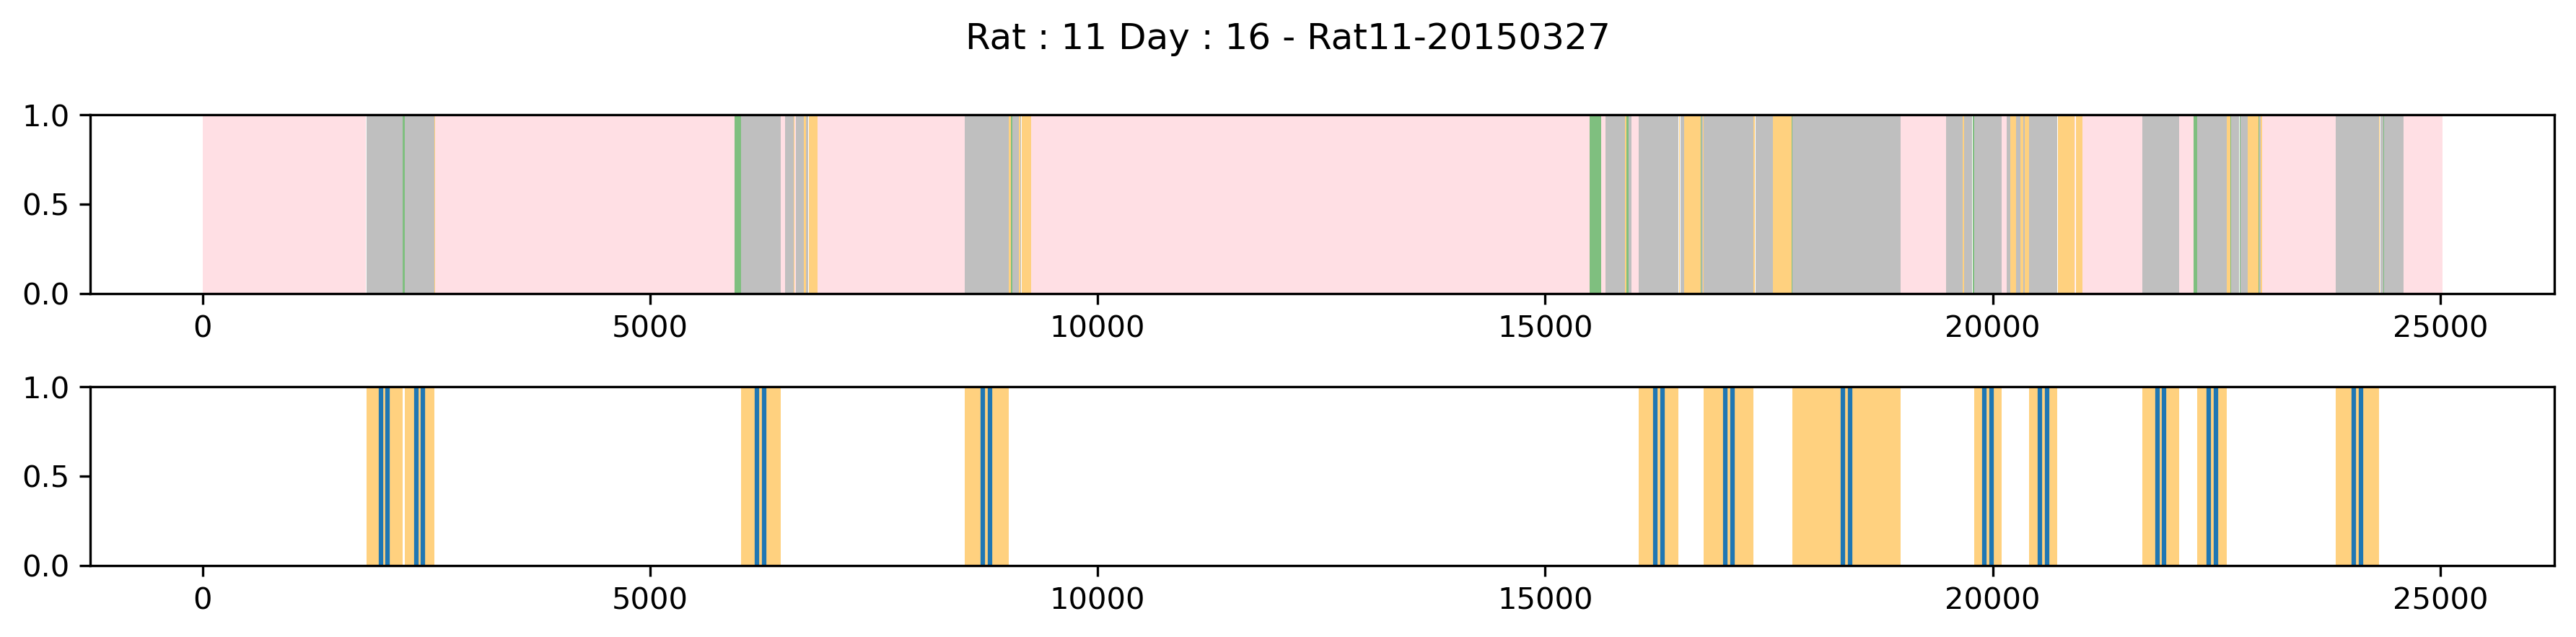

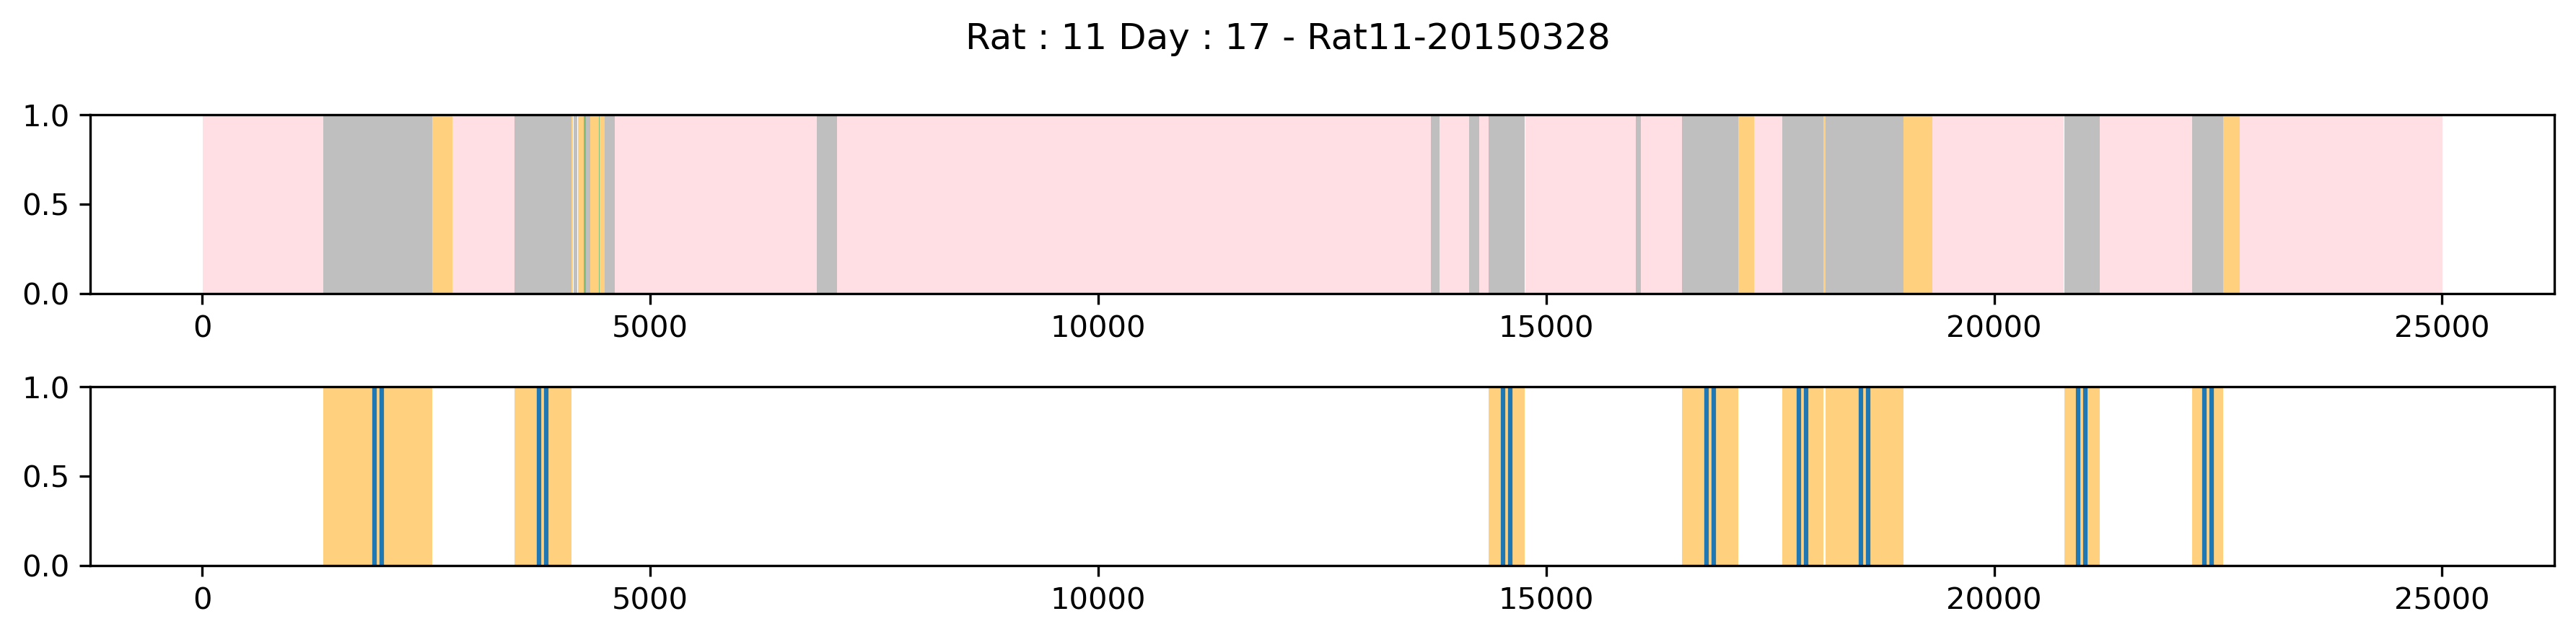

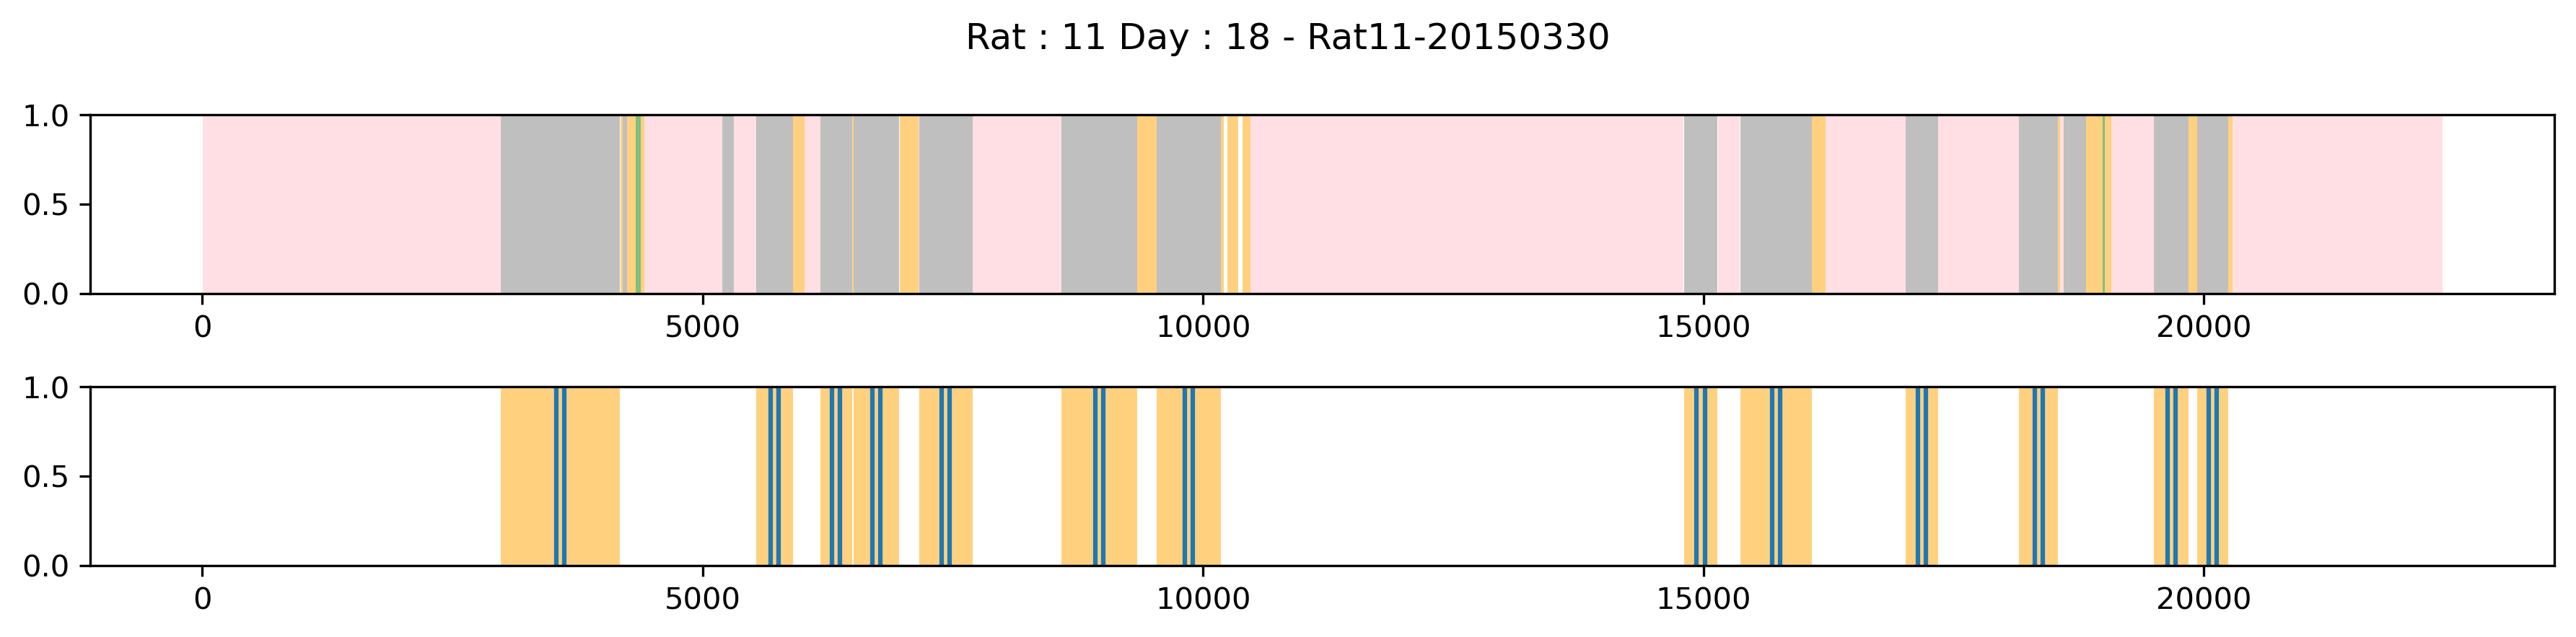

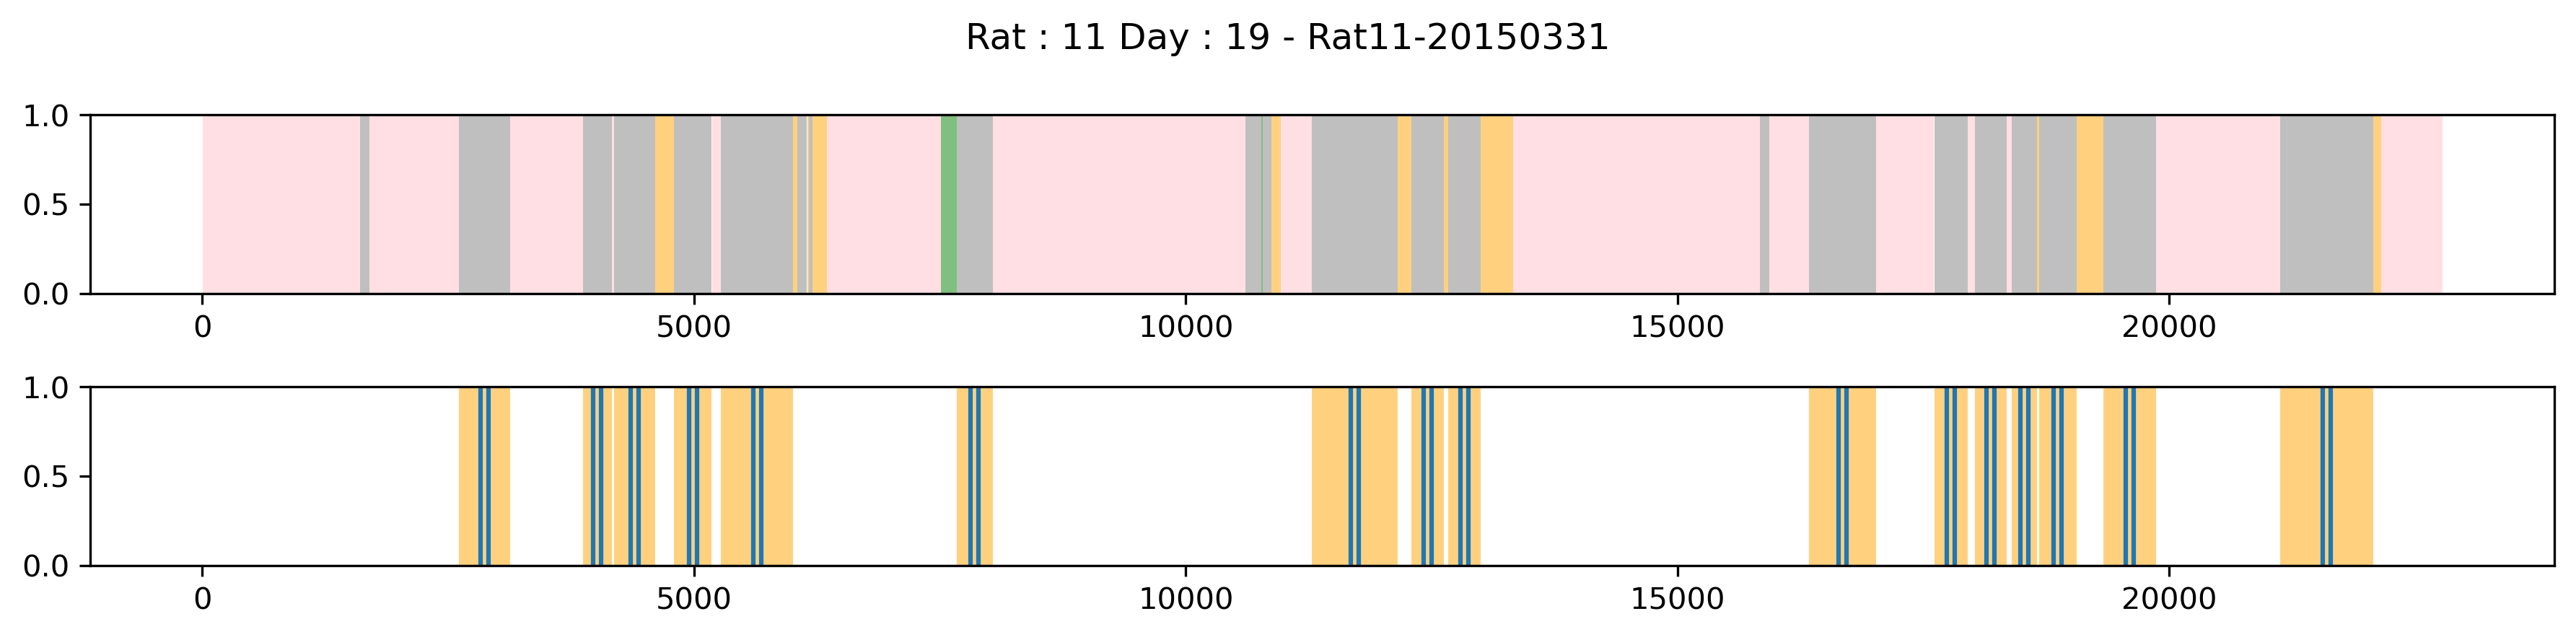

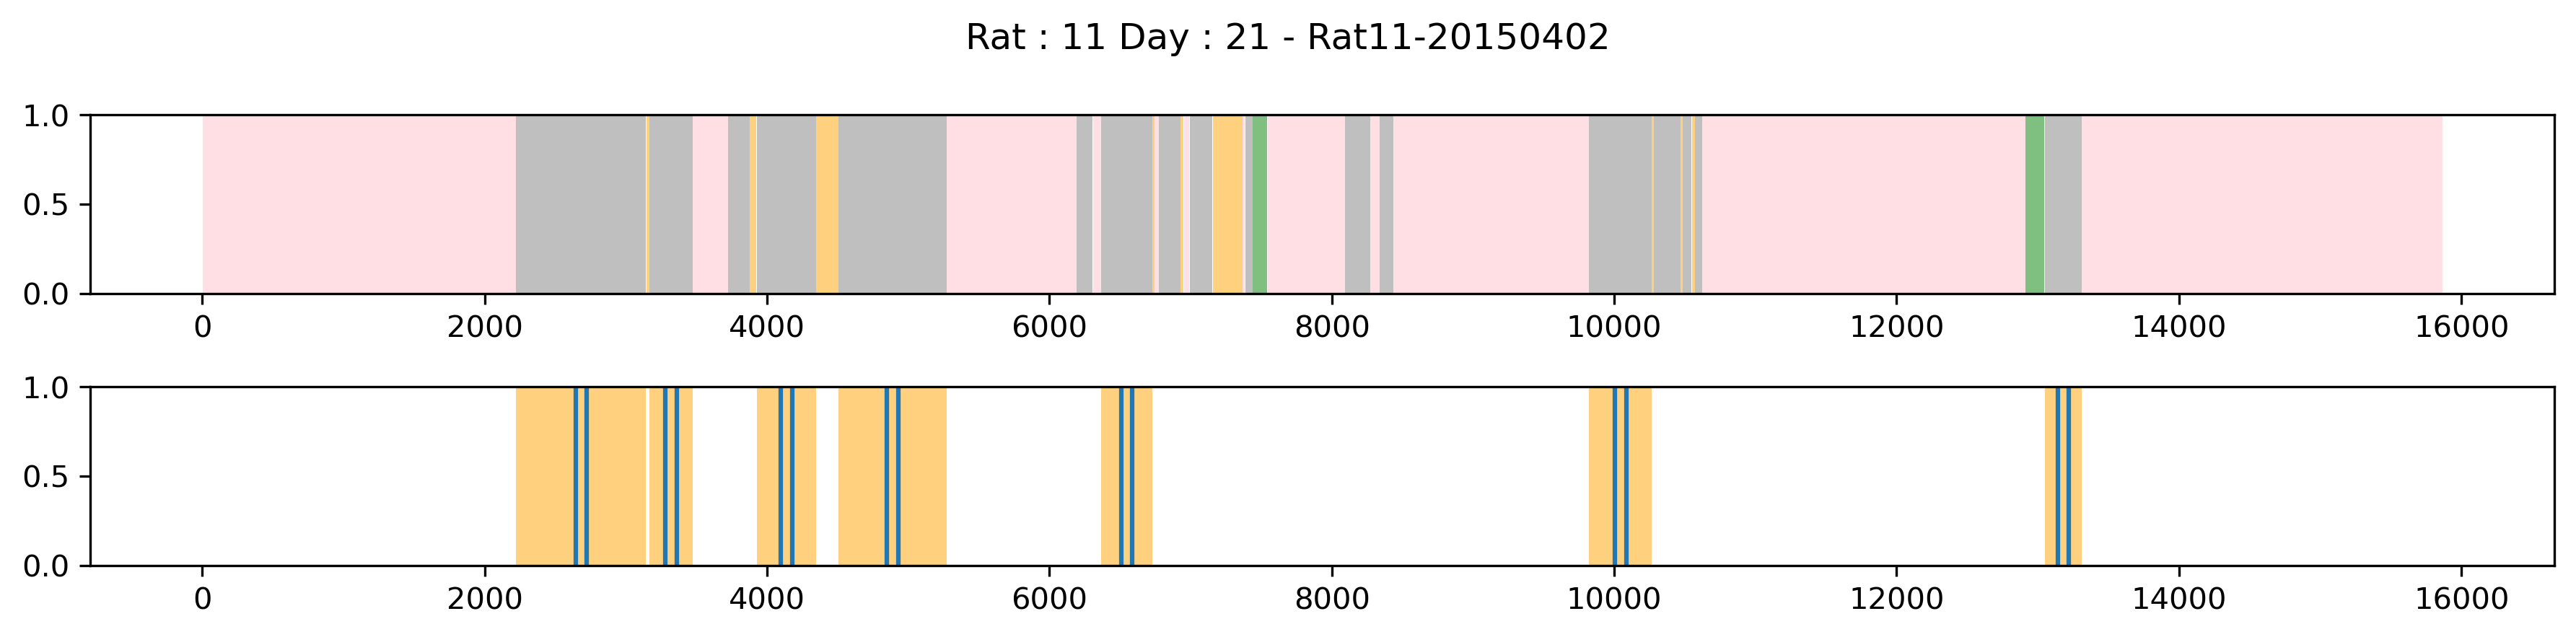

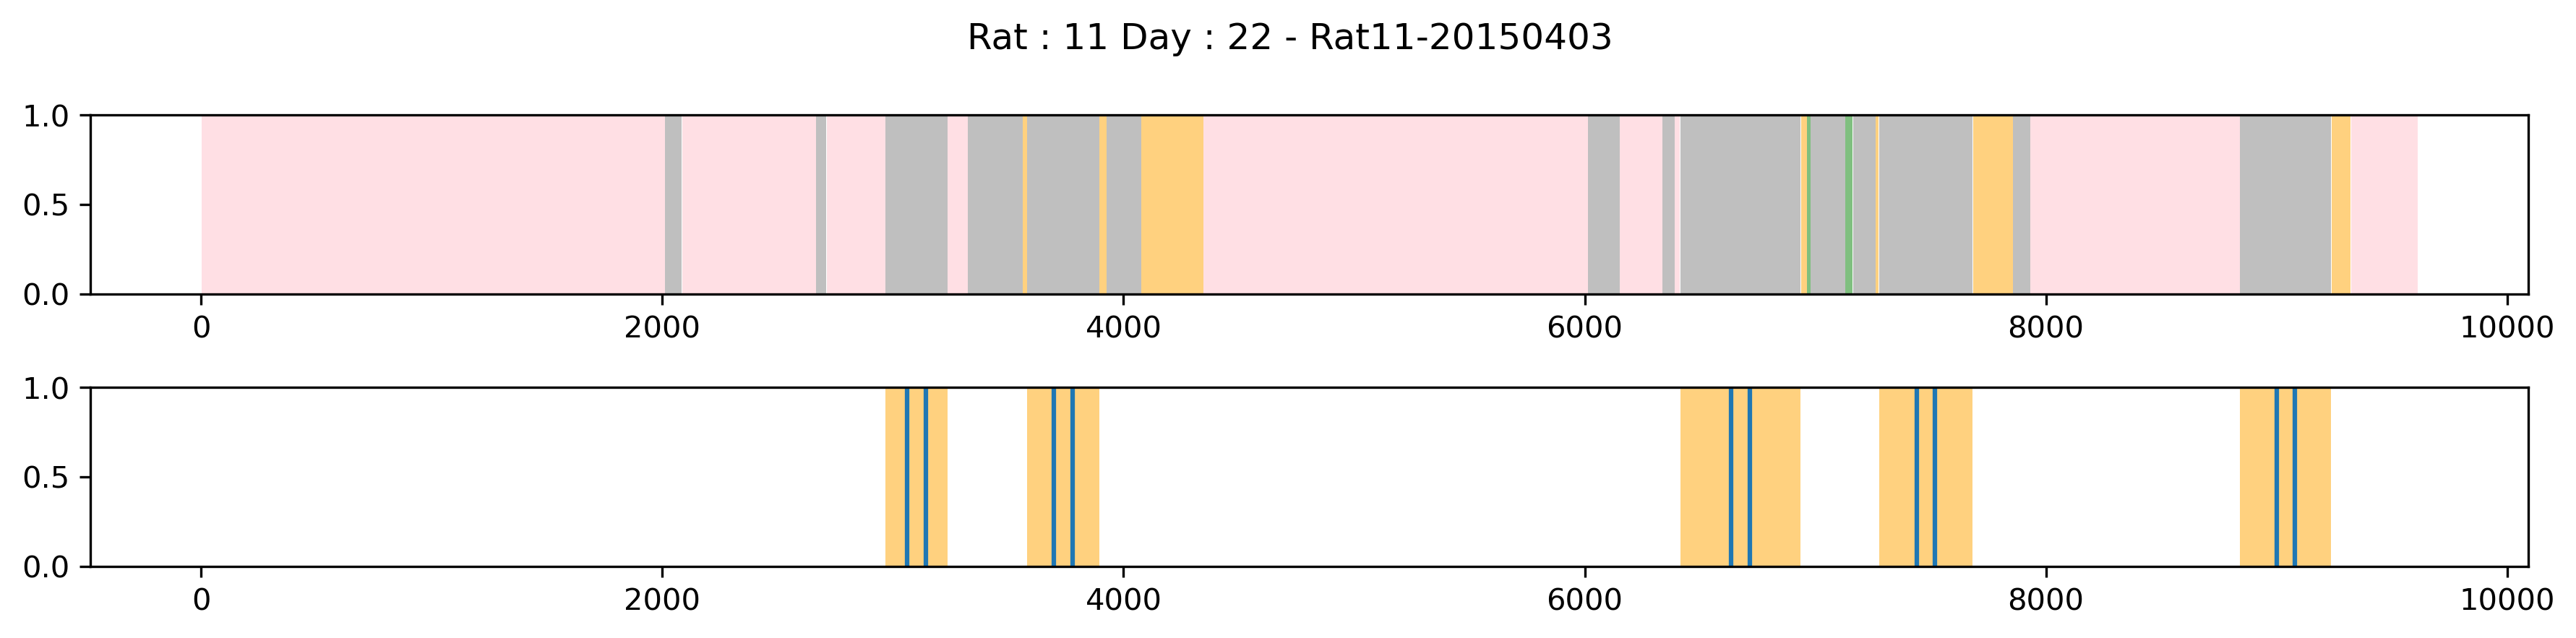

In [73]:
args = None
NREM_Control = bk.load.batch(NREM_Control, args, verbose=False, linux=True)

In [9]:
NREM_REM_NN = bk.load.batch(main_non_normalized, arg=None, linux=True, verbose=True)

TypeError: batch() got an unexpected keyword argument 'arg'

 ## Merging

In [11]:
def merge_with_spec(batch,name,discard):
    transitions_activity = []
    transition_spec = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
            transitions_activity.append(np.nanmean(b[0],2))
            metadata.append(b[2])
            transition_spec.append(np.nanmean(b[1][2],2))
            f = b[1][0]
            t = b[1][1]
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,
              'average_transition':np.vstack(transitions_activity),
              'metadata':pd.concat(metadata),
              'average_spec':transition_spec,
              't_spec':t,
              'f_spec':f,
              'n_transitions':n_transitions,
              'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [21]:
def merge(batch,name,discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i,b in batch.items():
        if i not in discard:
#          if True:
            transitions_activity.append(np.mean(b[0],2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1 
    merged = {'name':name,'average_transition':np.vstack(transitions_activity),'metadata':pd.concat(metadata),'n_transitions':n_transitions,'n_sessions':n_sessions}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged

In [75]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]



In [10]:
discard = []


In [14]:
m_NREM_REM = merge(NREM_REM, "NREM_REM", discard)

NameError: name 'NREM_REM' is not defined

In [46]:
m_NREM_REM_NREM = merge(NREM_REM_NREM, "NREM_REM_NREM", discard)
m_REM_NREM_REM = merge(REM_NREM_REM, "REM_NREM_REM", discard)

NameError: name 'NREM_REM_NREM' is not defined

In [76]:
m_NREM_Control = merge(NREM_Control, "NREM Control", discard)

## Plotting

In [22]:
%matplotlib qt

## NREM-REM Transition

<ipython-input-44-e442a71842a7>:45: RuntimeWarning: invalid value encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100


(42,)
(42,)


<ipython-input-44-e442a71842a7>:45: RuntimeWarning: divide by zero encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100
<ipython-input-44-e442a71842a7>:45: RuntimeWarning: invalid value encountered in true_divide
  average_baseline_pyr = np.nanmean((average_stru_pyr.T/mean_pyr_last_third).T,0)*100


(42,)
(42,)


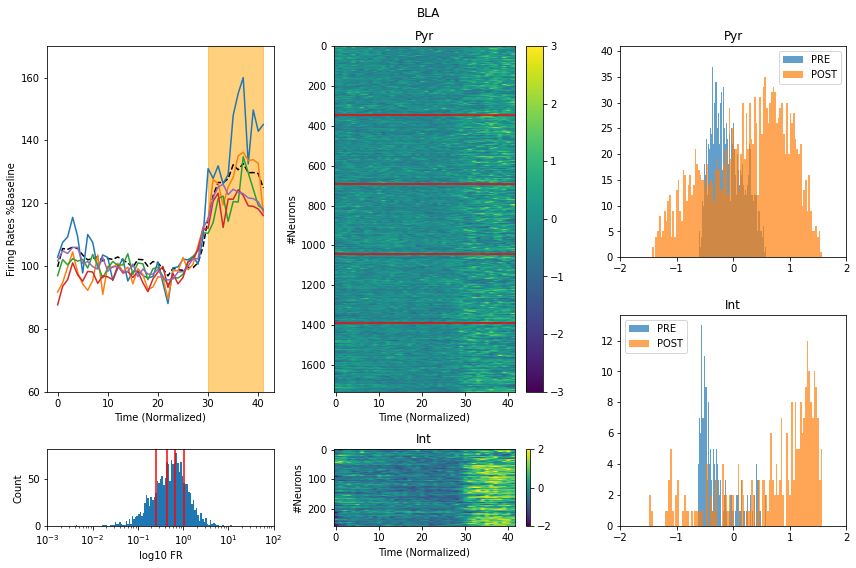

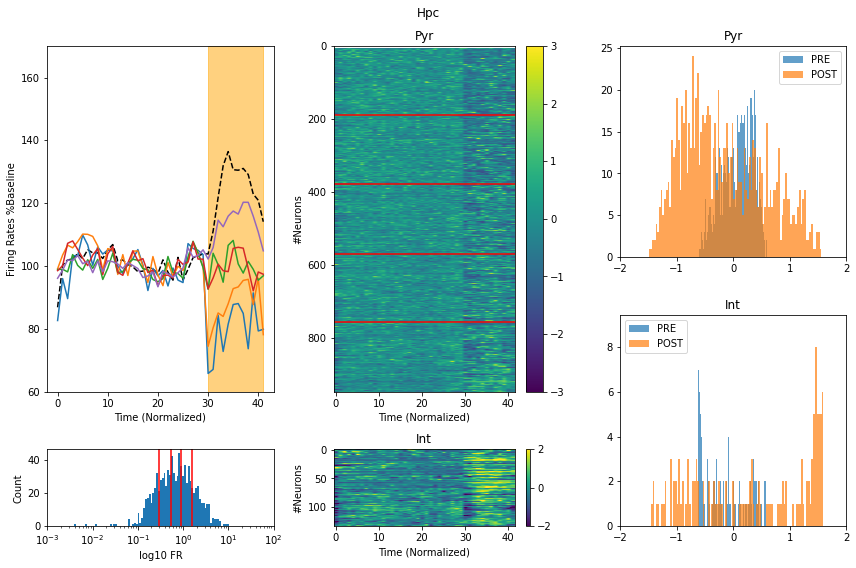

In [44]:
m_NREM_REM = merge(NREM_REM, "NREM_REM", discard)

stru = ["Hpc", "BLA", "CeCM", "Pir", "BMA", "BMP", "BLV"]
stru = ["BLA", "Hpc"]
transition = m_NREM_REM
for s in stru:
    fig, ax = plt.subplot_mosaic(
        """
                                   ABD
                                   ABD
                                   ABE
                                   FCE
                                """,
        figsize=[12, 8],
    )
    metadata = m_NREM_REM["metadata"]
    stru_mask = metadata.Region == s
    pyr_mask = metadata.Type == "Pyr"
    int_mask = metadata.Type == "Int"

    average_stru_pyr = m_NREM_REM["average_transition"][stru_mask & pyr_mask]
    average_stru_int = m_NREM_REM["average_transition"][stru_mask & int_mask]

    if s == "CeCM":
        average_stru_pyr = average_stru_int

    z_average_stru_pyr = zscore(average_stru_pyr, 1)
    z_average_stru_int = zscore(average_stru_int, 1)

    #     z_average_stru_pyr = z_average_stru_pyr[~np.isnan(z_average_stru_pyr[:,0])]
    #     z_average_stru_int = z_average_stru_int[~np.isnan(z_average_stru_int[:,0])]

    mean_pyr_fr_sleep = np.nanmean(average_stru_pyr, 1)
    mean_int_fr_sleep = np.nanmean(average_stru_int, 1)

    mean_pyr_last_third = np.nanmean(average_stru_pyr[:, 20:30], 1)
    mean_int_last_third = np.nanmean(average_stru_int[:, 20:30], 1)

    average_baseline_pyr = (
        np.nanmean((average_stru_pyr.T / mean_pyr_last_third).T, 0) * 100
    )
    average_baseline_int = (
        np.nanmean((average_stru_int.T / mean_int_last_third).T, 0) * 100
    )

    order_pyr = np.argsort(mean_pyr_fr_sleep)
    order_int = np.argsort(mean_int_fr_sleep)

    mean_average_stru_pyr = np.nanmean(average_stru_pyr, 0)
    norm_mean_average_stru_pyr = (
        mean_average_stru_pyr / np.nanmean(mean_average_stru_pyr[20:30]) * 100
    )

    mean_average_stru_int = np.nanmean(average_stru_int, 0)
    print(mean_average_stru_int.shape)
    norm_mean_average_stru_int = (
        mean_average_stru_int / np.nanmean(mean_average_stru_int[20:30]) * 100
    )
    print(norm_mean_average_stru_int.shape)
    #     ax['A'].plot(np.mean(zscore(average_stru_int,1),0),'--',color = 'black')
    #     ax['A'].plot(average_baseline_int,'--',color = 'black')
    ax["A"].plot(norm_mean_average_stru_int, "--", color="black")
    quantiles = pd.qcut(mean_pyr_fr_sleep, 5)
    for q in quantiles.categories:
        #         average_baseline_pyr = 100*np.nanmean((average_stru_pyrc/mean_pyr_last_third[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)]).T,0)
        #         ax['A'].plot(np.mean(zscore(average_stru_pyr[(mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep< q.right)],1).T,1))

        mean_average_stru_pyr = np.nanmean(
            average_stru_pyr[
                (mean_pyr_fr_sleep > q.left) & (mean_pyr_fr_sleep < q.right)
            ],
            0,
        )
        norm_mean_average_stru_pyr = (
            mean_average_stru_pyr / np.nanmean(mean_average_stru_pyr[20:30]) * 100
        )

        ax["A"].plot(norm_mean_average_stru_pyr)
        if q.left > 0:
            ax["F"].axvline((q.left), color="red")
    ax["A"].axvspan(30, 41, color="orange", alpha=0.5)
    ax["A"].set_ylim([60, 170])
    ax["A"].set_xlabel("Time (Normalized)")
    ax["A"].set_ylabel("Firing Rates %Baseline")

    #     l = np.log10(mean_pyr_fr_sleep)
    #     l[np.isinf(l)] = np.nan
    #     ax['F'].hist(mean_pyr_fr_sleep,100,log=True)
    #     ax['F'].set_xscale('log')

    #     ax['F'].set_xlim([0.001,100])
    plt.sca(ax["F"])
    plot_loghist(mean_pyr_fr_sleep[mean_pyr_fr_sleep > 0], 100)
    ax["F"].set_xlim([0.001, 100])
    ax["F"].set_xlabel("log10 FR")
    ax["F"].set_ylabel("Count")

    im = ax["B"].imshow(z_average_stru_pyr[order_pyr, :], aspect="auto")
    im.set_clim([-3, 3])
    fig.colorbar(im, ax=ax["B"])
    ax["B"].set_ylabel("#Neurons")
    ax["B"].set_xlabel("Time (Normalized)")
    ax["B"].set_title("Pyr")

    pourcentiles = [0.20, 0.40, 0.60, 0.80]
    for p in pourcentiles:
        ax["B"].axhline(int(p * len(average_stru_pyr)), color="red")

    im = ax["C"].imshow(z_average_stru_int[order_int, :], aspect="auto")
    im.set_clim([-2, 2])
    ax["C"].set_xlabel("Time (Normalized)")
    ax["C"].set_ylabel("#Neurons")
    ax["C"].set_title("Int")
    fig.colorbar(im, ax=ax["C"])

    #     z_average_stru_pyr = zscore(average_stru_pyr,0)

    ### Violin plot
    mean_pre_pyr = np.mean(z_average_stru_pyr[:, 0:30], 1)
    mean_post_pyr = np.mean(z_average_stru_pyr[:, 30:41], 1)

    mean_pre_int = np.nanmean(z_average_stru_int[:, 0:30], 1)
    mean_post_int = np.nanmean(z_average_stru_int[:, 30:41], 1)

    df_pyr = pd.DataFrame(
        (np.array([mean_pre_pyr, mean_post_pyr]).T), columns=["PRE", "POST"]
    )
    df_int = pd.DataFrame(
        (np.array([mean_pre_int, mean_post_int]).T), columns=["PRE", "POST"]
    )
    df_pyr.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_int.replace([np.inf, -np.inf], np.nan, inplace=True)

    plt.sca(ax["D"])
    #     sns.violinplot(data = df_pyr)
    ax["D"].set_xlim([-2, 2])
    plt.hist(df_pyr["PRE"], 100, alpha=0.7)
    plt.hist(df_pyr["POST"], 100, alpha=0.7)
    plt.legend(["PRE", "POST"])
    plt.title("Pyr")

    plt.sca(ax["E"])
    #     sns.violinplot(data = df_int)
    plt.hist(df_int["PRE"], 100, alpha=0.7)
    plt.hist(df_int["POST"], 100, alpha=0.7)
    plt.legend(["PRE", "POST"])
    ax["E"].set_xlim([-2, 2])

    plt.title("Int")

    plt.suptitle(s)
    plt.tight_layout()

    plt.savefig(f"/home/billel/figs/{s}-NREM-REM.svg")



## NREM-REM-NREM

In [45]:
stru = ["BLA", "CeCM", "Hpc", "Pir"]
types = ["Pyr", "Int"]
transitions = [m_NREM_REM_NREM]


for trans in transitions:
    for s in stru:
        fig, ax = plt.subplot_mosaic(
            """AB
                                       AC"""
        )
        stru_mask = trans["metadata"].Region == s
        for t in types:
            types_mask = trans["metadata"].Type == t
            stru_type_activity = trans["average_transition"][(stru_mask) & types_mask]
            if np.any(stru_type_activity):
                print(s + t)
                z_stru_type_activity = zscore(stru_type_activity, 1)
                pre_fr = np.nanmean(z_stru_type_activity[:, 15:30], 1)
                post_fr = np.nanmean(z_stru_type_activity[:, 42 : 42 + 15], 1)
                print(pre_fr.shape)
                a, p = scipy.stats.wilcoxon(pre_fr, post_fr)
                a = np.array([pre_fr, post_fr]).T
                v = pd.DataFrame(a, columns=[f"{t}Pre", f"{t}Post"])
                ax["A"].plot(zscore(np.mean(stru_type_activity.T, 1)))
                ax["A"].axvspan(15, 30, color="grey")
                ax["A"].axvspan(30, 30 + 12, color="orange")
                ax["A"].axvspan(42, 42 + 15, color="grey")
                ax["A"].set_xlabel("Time (Normalized)")
                ax["A"].set_ylabel("Firing Rates (zScore)")
                if t == "Pyr":
                    plt.sca(ax["B"])
                    sns.violinplot(data=v)
                else:
                    plt.sca(ax["C"])
                    sns.violinplot(data=v)

                plt.suptitle(trans["name"] + s)
            print(p)
            p = np.round(p, 5)
            plt.title(f"{t} {p}")
            plt.tight_layout()
            name = trans["name"]
            plt.savefig(f"/home/billel/Data/figs/{name}_{s}.svg")



NameError: name 'm_NREM_REM_NREM' is not defined

## NREM Control

BLAPyr
(1735,)
8.696934255615771e-16
BLAInt
(257,)
1.2646868243447046e-20


/tmp/ipykernel_197091/63679155.py:19: RuntimeWarning: Mean of empty slice
  pre_fr = np.nanmean(z_stru_type_activity[:, 0:30], 1)
/tmp/ipykernel_197091/63679155.py:20: RuntimeWarning: Mean of empty slice
  post_fr = np.nanmean(z_stru_type_activity[:, 42 : 42 + 30], 1)


0.0
CeCMInt
(707,)
0.5434260476247403
HpcPyr
(932,)
2.0471325829560415e-14
HpcInt
(130,)
4.177729836792234e-10


/tmp/ipykernel_197091/63679155.py:19: RuntimeWarning: Mean of empty slice
  pre_fr = np.nanmean(z_stru_type_activity[:, 0:30], 1)
/tmp/ipykernel_197091/63679155.py:20: RuntimeWarning: Mean of empty slice
  post_fr = np.nanmean(z_stru_type_activity[:, 42 : 42 + 30], 1)


PirPyr
(944,)
6.395744081738528e-67
PirInt
(99,)
1.5416910688468836e-10


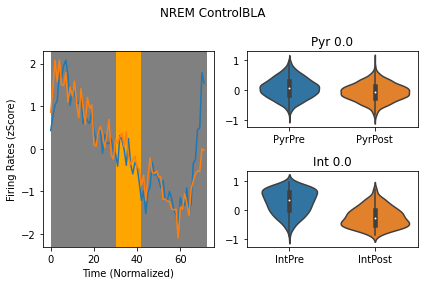

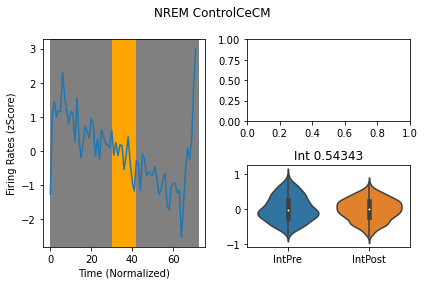

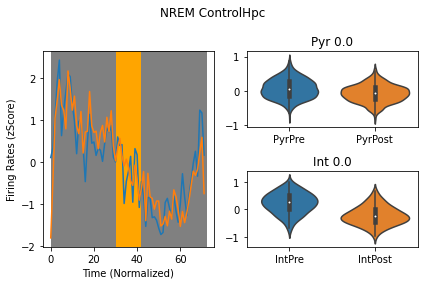

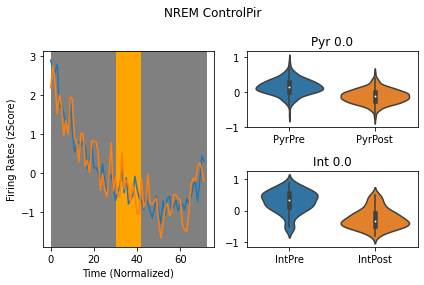

In [78]:
stru = ["BLA", "CeCM", "Hpc", "Pir"]
types = ["Pyr", "Int"]
transitions = [m_NREM_Control]


for trans in transitions:
    for s in stru:
        fig, ax = plt.subplot_mosaic(
            """AB
                                       AC"""
        )
        stru_mask = trans["metadata"].Region == s
        for t in types:
            types_mask = trans["metadata"].Type == t
            stru_type_activity = trans["average_transition"][(stru_mask) & types_mask]
            if np.any(stru_type_activity):
                print(s + t)
                z_stru_type_activity = zscore(stru_type_activity, 1)
                pre_fr = np.nanmean(z_stru_type_activity[:, 0:30], 1)
                post_fr = np.nanmean(z_stru_type_activity[:, 42 : 42 + 30], 1)
                print(pre_fr.shape)
                a, p = scipy.stats.wilcoxon(pre_fr, post_fr)
                a = np.array([pre_fr, post_fr]).T
                v = pd.DataFrame(a, columns=[f"{t}Pre", f"{t}Post"])
                ax["A"].plot(zscore(np.mean(stru_type_activity.T, 1)))
                ax["A"].axvspan(0, 30, color="grey")
                ax["A"].axvspan(30, 30 + 12, color="orange")
                ax["A"].axvspan(42, 42 + 30, color="grey")
                ax["A"].set_xlabel("Time (Normalized)")
                ax["A"].set_ylabel("Firing Rates (zScore)")
                if t == "Pyr":
                    plt.sca(ax["B"])
                    sns.violinplot(data=v)
                else:
                    plt.sca(ax["C"])
                    sns.violinplot(data=v)

                plt.suptitle(trans["name"] + s)
            print(p)
            plt.title(f"{t}")
            p = np.round(p, 5)
            plt.title(f"{t} {p}")
            plt.tight_layout()
            name = trans["name"]
            plt.savefig(f"/home/billel/figs/{name}_{s}.svg")



## REM_NREM_REM 

In [79]:
stru = ["BLA", "CeCM", "Hpc", "Pir"]
types = ["Pyr", "Int"]
transitions = [m_REM_NREM_REM]


for trans in transitions:
    for s in stru:
        fig, ax = plt.subplot_mosaic(
            """AB
                                       AC"""
        )
        stru_mask = trans["metadata"].Region == s
        for t in types:
            types_mask = trans["metadata"].Type == t
            stru_type_activity = trans["average_transition"][(stru_mask) & types_mask]
            if np.any(stru_type_activity):
                print(s + t)
                z_stru_type_activity = zscore(stru_type_activity, 1)
                pre_fr = np.nanmean(z_stru_type_activity[:, 0:12], 1)
                post_fr = np.nanmean(z_stru_type_activity[:, 42:], 1)
                print(pre_fr.shape)
                a, p = scipy.stats.wilcoxon(pre_fr, post_fr)
                a = np.array([pre_fr, post_fr]).T
                v = pd.DataFrame(a, columns=[f"{t}Pre", f"{t}Post"])
                ax["A"].plot(zscore(np.mean(stru_type_activity.T, 1)))
                ax["A"].axvspan(0, 12, color="orange")
                ax["A"].axvspan(12, 12 + 30, color="grey")
                ax["A"].axvspan(42, 42 + 11, color="orange")
                ax["A"].set_xlabel("Time (Normalized)")
                ax["A"].set_ylabel("Firing Rates (zScore)")
                if t == "Pyr":
                    plt.sca(ax["B"])
                    sns.violinplot(data=v)
                else:
                    plt.sca(ax["C"])
                    sns.violinplot(data=v)
                plt.suptitle(trans["name"] + s)

            print(p)
            p = np.round(p, 5)
            plt.title(f"{t} {p}")
            plt.tight_layout()
            name = trans["name"]
            plt.savefig(f"/home/billel/Data/figs/{name}_{s}.svg")



NameError: name 'm_REM_NREM_REM' is not defined

In [38]:
for r, i in enumerate(["Hpc", "CeCM", "BLA", "Pir"]):
    plt.figure()
    for t, j in enumerate(["Pyr", "Int"], 1):
        stru_type_activity = transitions_activity[
            (metadata.Region == i) & (metadata.Type == j)
        ]
        plt.subplot(1, 2, t)
        if np.any(stru_type_activity):
            #             order = np.argsort(np.mean(stru_type_activity[:,30:41],1)/np.mean(stru_type_activity,1))
            plt.title(f"Stru : {i} type : {j}")
            plt.imshow(stru_type_activity[:, :], aspect="auto")
            plt.clim([-5, 5])
    plt.tight_layout()


NameError: name 'transitions_activity' is not defined

<Figure size 432x288 with 0 Axes>

In [4]:
# transition_interest = [('Rem','sws'),('sws','Rem'),('Rem','wake')]
# s = "ABC"
# fig,ax = plt.subplot_mosaic('ABC')
# for ii,i in enumerate(transition_interest):
#     binned = []
#     for event,trans_time in zip(transitions[i].as_units('s').iloc,times[i].as_units('s').index.values):
#         print(trans_time)
#         print('he')
#         start = event.start
#         end = event.end
        
#         if (end-trans_time)<50 or (trans_time-start) <50: continue
# #         if (end-trans_time) > 180: end = trans_time+120
# #         if (trans_time-start) > 180: start = trans_time-120
        
        
        
#         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
#         t_post,b_post = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
#         b_pre = b_pre/((trans_time-start)/30)
#         b_post = b_post/((end-trans_time)/12)
#         t = np.hstack((t_pre,t_post))
#         b = np.hstack((b_pre,b_post))
        
# #         plt.figure()
# #         plt.plot(t,b.T)
# #         plt.axvline(trans_time,color = 'red')
#         binned.append(b)
#     ax[s[ii]].plot(np.mean(binned,0).T)
    
# plt.suptitle('Transition')

# NREM_REM Not Normalized

In [48]:
def plot_average_transition(
    average_transition, metadata, region, types, style, interval
):
    X = scipy.stats.zscore(
        average_transition[(metadata.Region == region) & (metadata.Type == types)],
        1,
        nan_policy="omit",
    ).T
    y = np.nanmean(X, 1)
    y_std = scipy.stats.sem(X, 1, nan_policy="omit")
    #     y_std = np.nanstd(X,1)
    t = np.linspace(0, len(y), len(y))
    plt.plot(t, y, style)
    plt.plot(t, y + y_std, f"{style}--")
    plt.plot(t, y - y_std, f"{style}--")
    plt.axvspan(interval[0], interval[1], color="orange", alpha=0.5)

In [29]:
def plot_average_spec(t_spec, f_spec, average_spec):
    average_spec = np.log(average_spec)
    plt.pcolormesh(
        t_spec - 90, f_spec, average_spec, shading="gouraud", rasterized=True
    )
    #     plt.imshow(average_spec,aspect='auto',origin='lower')
    plt.ylim(0, 20)
    plt.clim(7, 12)
    plt.ylabel("Freq (Hz)")
    plt.xlabel("Time (s)")



In [14]:
NREM_REM_NN = bk.load.batch(main_non_normalized,arg = None,linux = True,verbose = False)

100%|██████████| 61/61 [04:32<00:00,  4.46s/it]

Batch finished in 272.3136067390442
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


In [15]:
m_NREM_REM_NN = merge_with_spec(NREM_REM_NN,'NREM_REM_NN',discard)

# Figure NN NREM_REM

<ipython-input-33-793408e47117>:28: RuntimeWarning: invalid value encountered in true_divide
  order = np.argsort(np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,89:],1)/np.nanmean(m_NREM_REM_NN['average_transition'][BLA_PYR_Filt][:,0:89],1))


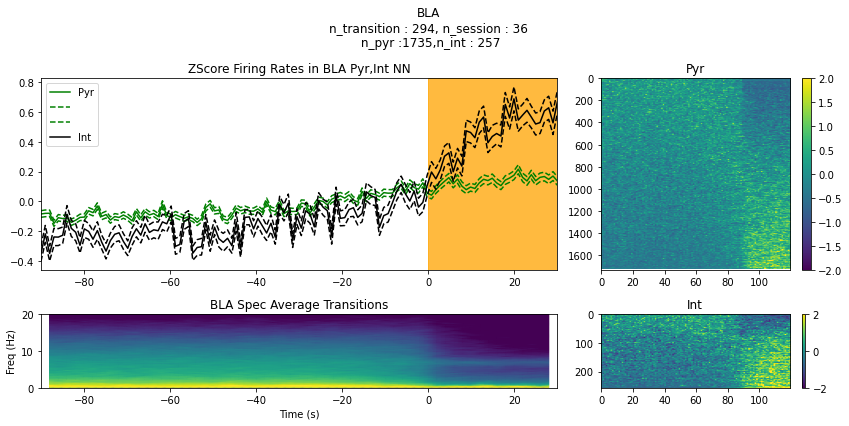

In [33]:
BLA_PYR_Filt = (m_NREM_REM_NN["metadata"].Region == "BLA") & (
    m_NREM_REM_NN["metadata"].Type == "Pyr"
)
BLA_INT_Filt = (m_NREM_REM_NN["metadata"].Region == "BLA") & (
    m_NREM_REM_NN["metadata"].Type == "Int"
)

n_transition = m_NREM_REM_NN["n_transitions"]
n_sessions = m_NREM_REM_NN["n_sessions"]
n_pyr = np.sum(BLA_PYR_Filt)
n_int = np.sum(BLA_INT_Filt)

fig, ax = plt.subplot_mosaic(
    """AAC
                               AAC
                               BBD
                    """,
    figsize=[12, 6],
)
plt.sca(ax["A"])
plot_average_transition(
    m_NREM_REM_NN["average_transition"],
    m_NREM_REM_NN["metadata"],
    "BLA",
    "Pyr",
    "g",
    [0, 30],
)
plot_average_transition(
    m_NREM_REM_NN["average_transition"],
    m_NREM_REM_NN["metadata"],
    "BLA",
    "Int",
    "k",
    [0, 30],
)
plt.legend(["Pyr", "", "", "Int"])
plt.title(f"ZScore Firing Rates in BLA Pyr,Int NN")


plt.sca(ax["B"])
plot_average_spec(
    m_NREM_REM_NN["t_spec"],
    m_NREM_REM_NN["f_spec"],
    np.mean(m_NREM_REM_NN["average_spec"], 0),
)
plt.title("BLA Spec Average Transitions")
plt.xlim(-90, 30)
ax["A"].sharex(ax["B"])

plt.sca(ax["C"])
order = np.argsort(
    np.nanmean(m_NREM_REM_NN["average_transition"][BLA_PYR_Filt][:, 89:], 1)
    / np.nanmean(m_NREM_REM_NN["average_transition"][BLA_PYR_Filt][:, 0:89], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_NREM_REM_NN["average_transition"][BLA_PYR_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Pyr")
plt.colorbar()


plt.sca(ax["D"])
order = np.argsort(
    np.nanmean(m_NREM_REM_NN["average_transition"][BLA_INT_Filt][:, 89:], 1)
    / np.nanmean(m_NREM_REM_NN["average_transition"][BLA_INT_Filt][:, 0:89], 1)
)
plt.imshow(
    scipy.stats.zscore(
        m_NREM_REM_NN["average_transition"][BLA_INT_Filt][order], 1, nan_policy="omit"
    ),
    aspect="auto",
)
plt.clim(-2, 2)
plt.title("Int")
plt.colorbar()


plt.suptitle(
    f"BLA\nn_transition : {n_transition}, n_session : {n_sessions}\n n_pyr :{n_pyr},n_int : {n_int}"
)
plt.tight_layout()
plt.savefig("/mnt/work/Figures_Gabrielle/NREM_REM_NN.svg")



In [217]:
m_NREM_REM_NN['average_transition'][BLA_INT_Filt]

array([], shape=(0, 120), dtype=float64)

In [64]:
def shank_to_structure(rat, day, shank):
    structures_path = os.path.join(bk.load.base, "All-Rats/Structures/structures.mat")
    structures = scipy.io.loadmat(structures_path)
    useless = ["__header__", "__version__", "__globals__", "basal", "olfact"]
    for u in useless:
        del structures[u]

    for stru, array in structures.items():
        filtered_array = array[np.all(array == [rat, day, shank], 1)]
        if np.any(filtered_array):
            print(stru, filtered_array)
            return stru


def channels(session):
    tree = ET.parse(session + ".xml")
    root = tree.getroot()
    shank_channels = {}

    i = 0
    for anatomicalDescription in root.iter("anatomicalDescription"):
        for channelGroups in anatomicalDescription.iter("channelGroups"):
            for group in channelGroups.iter("group"):
                i += 1
                channels = []
                for channel in group.iter("channel"):
                    channels.append(int(channel.text))
                stru = shank_to_structure(rat, day, shank)
                shank_channels.update({i: [channels, stru]})
    return shank_channels


In [51]:
def NREM_Check_FR(local_path, args):
    
    bk.load.current_session_linux(base_folder = "/media/billel/GGLab-01-BK/DATA/GG-Dataset", local_path=local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states()

    binned = np.zeros(shape = (len(neurons),72))

    for epoch in states['sws'].as_units('s').iloc:
        if epoch.end - epoch.start < 250: continue
        t,b = bk.compute.binSpikes(neurons,start = epoch.start, stop = epoch.end,nbins=72)
        binned = np.dstack((binned,b))
        
    binned = np.delete(binned,0,axis = 2)
    return metadata, binned.mean(axis = 2)


In [52]:
NREM_Check_FR('Rat08/Rat08-20130713',None)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /media/billel/GGLab-01-BK/DATA/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


(    Rat Day Shank Id Region Type
 0     8   6     1  2    Hpc  Pyr
 1     8   6     2  2    Hpc  Pyr
 2     8   6     2  3    Hpc  Pyr
 3     8   6     2  4    Hpc  Pyr
 4     8   6     2  5    Hpc  Pyr
 ..   ..  ..   ... ..    ...  ...
 247   8   6    19  2    BLA  Pyr
 248   8   6    19  3    BLA  Pyr
 249   8   6    19  4    BLA  Pyr
 250   8   6    19  5    BLA  Pyr
 251   8   6    19  6    BLA  Pyr
 
 [252 rows x 6 columns],
 array([[ 2.9 ,  2.6 ,  3.45, ...,  2.05,  2.65,  1.05],
        [12.85,  9.7 ,  6.35, ...,  3.2 ,  3.1 ,  2.75],
        [ 2.45,  3.55,  5.1 , ...,  5.4 ,  8.  ,  4.5 ],
        ...,
        [ 0.3 ,  0.8 ,  0.3 , ...,  0.1 ,  0.3 ,  0.95],
        [ 1.  ,  0.65,  0.4 , ...,  0.45,  0.5 ,  0.15],
        [ 1.85,  2.05,  1.25, ...,  0.4 ,  0.95,  1.35]]))

In [53]:
batch = bk.load.batch(NREM_Check_FR,args=[],linux= True)

100%|██████████| 61/61 [00:35<00:00,  1.69it/s]

Batch finished in 36.014678716659546
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


In [54]:
def NREM_Merging(batch):
    
    transitions_activity = []
    metadata = []

    for i,b in batch.items():
        metadata.append(b[0])
        transitions_activity.append(b[1])

    merged = {'average_transition':np.vstack(transitions_activity),'metadata':pd.concat(metadata)}
    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged   

In [56]:
merged = NREM_Merging(batch)

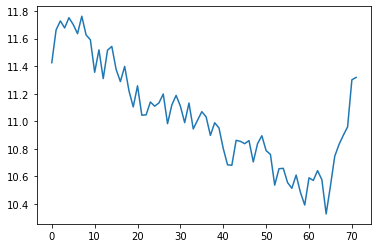

In [63]:
plt.plot(merged['average_transition'][merged['metadata']['Region'] == 'BLA'].mean(axis = 0).T)

# REM_NREM_REM

In [30]:
arg = [["Rem", "sws", "Rem"], [12, 30, 12], 3]
REM_NREM_REM = bk.load.batch(main, arg, verbose=False, linux=True)

discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]
m_REM_NREM_REM = merge(REM_NREM_REM, "REM_NREM_REM", discard)

100%|██████████| 61/61 [00:19<00:00,  3.19it/s]

Batch finished in 19.15813112258911
Some session were not processed correctly
['Rat08-20130712', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140404', 'Rat09-20140407', 'Rat10-20140622', 'Rat10-20140628', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140707', 'Rat11-20150313', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150325', 'Rat11-20150327', 'Rat11-20150328', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
55.73770491803278 %


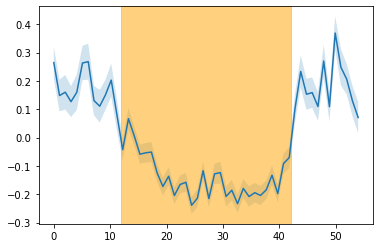

In [59]:
plot_average_transition(m_REM_NREM_REM['metadata'],m_REM_NREM_REM['average_transition'],'Pir','Pyr',(12,12+30))

In [56]:
def plot_average_transition(metadata,average_transition,region,types,interval):
    
    X = scipy.stats.zscore(
        average_transition[(metadata.Region == region) & (metadata.Type == types)],
        1,
        nan_policy="omit",
    ).T
    y = np.nanmean(X, 1)
    y_std = scipy.stats.sem(X, 1, nan_policy="omit")
    #     y_std = np.nanstd(X,1)
    t = np.linspace(0, len(y), len(y))
    plt.plot(t, y)
    plt.fill_between(t,y+y_std,y-y_std,alpha = 0.2)


    plt.axvspan(interval[0], interval[1], color="orange", alpha=0.5)
    